In [2]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from persim import PersImage
import gudhi
import os
import glob
from matplotlib import ticker, cm
from matplotlib.colors import LogNorm
from sklearn.cluster import KMeans
import time
from sklearn.decomposition import PCA
import matplotlib as mpl
from sklearn import preprocessing

load specific PD for tests

In [497]:
temp=np.loadtxt("Data_2d_Ising_Wolff_N=50/2.49/1550489717PD1.dat")

Define persistence image function... this can likely be sped up

In [746]:
#pdlocnum has format [[birth1, persistence1, counts1],...]
#bounds should be a list [bmin,bmax,pmin,pmax]
#bins should be a list [bbins, pbins]
def PerIm(pdlocnum,bounds,bins,stdev,res=1000):
    x = np.linspace(bounds[0], bounds[1], res)
    y = np.linspace(bounds[2], bounds[3], res)
    xx, yy = np.meshgrid(x, y, sparse=True)
    z=np.zeros([res,res])
    for i in np.arange(len(pdlocnum)):
        z=z+np.log(1+pdlocnum[i][1])*pdlocnum[i][2]*np.exp((-0.5*(xx-pdlocnum[i][0])**2-0.5*(yy-pdlocnum[i][1])**2)*stdev**-2)
    return z.reshape(bins[0],res//bins[0],bins[1],res//bins[1]).sum(3).sum(1)

In [747]:
def PerImAlt(pdlocnum,bounds,bins,stdev,res=1000):
    x = np.linspace(bounds[0], bounds[1], res)
    y = np.linspace(bounds[2], bounds[3], res)
    xx, yy = np.meshgrid(x, y, sparse=True)
    z=np.sum(np.array([np.log(1+elm[1])*elm[2]*np.exp((-0.5*(xx-elm[0])**2-0.5*(yy-elm[1])**2)*stdev**-2) for elm in pdlocnum]),axis=0)
    return z.reshape(bins[0],res//bins[0],bins[1],res//bins[1]).sum(3).sum(1)

try it out on test PD

In [750]:
bounds=[0,15.5,0,13]
bins=[10,10]
res=bins[0]*10
x = np.linspace(bounds[0], bounds[1], bins[0])
y = np.linspace(bounds[2], bounds[3], bins[1])
t1=time.time()
z=PerIm(temp,bounds,bins,1,res=res)
t2=time.time()
z=PerImAlt(temp,bounds,bins,1,res=res)
t3=time.time()
#fig, ax = plt.subplots()
#cs=ax.imshow(np.log(1+z),origin='lower')
#cs = ax.contourf(x, y, z,locator=ticker.LogLocator())
#locator=ticker.LogLocator()
#cbar = fig.colorbar(cs)
print((t2-t1,t3-t2))

(0.00792694091796875, 0.010153055191040039)


PerIm is faster than PerImAlt

In [5]:
np.sort(os.listdir('Data_2d_Ising_Wolff_N=50'))

array(['1.5', '1.51', '1.52', '1.53', '1.54', '1.55', '1.56', '1.57',
       '1.58', '1.59', '1.6', '1.61', '1.62', '1.63', '1.64', '1.65',
       '1.66', '1.67', '1.68', '1.69', '1.7', '1.71', '1.72', '1.73',
       '1.74', '1.75', '1.76', '1.77', '1.78', '1.79', '1.8', '1.81',
       '1.82', '1.83', '1.84', '1.85', '1.86', '1.87', '1.88', '1.89',
       '1.9', '1.91', '1.92', '1.93', '1.94', '1.95', '1.96', '1.97',
       '1.98', '1.99', '2.0', '2.01', '2.02', '2.03', '2.04', '2.05',
       '2.06', '2.07', '2.08', '2.09', '2.1', '2.11', '2.12', '2.13',
       '2.14', '2.15', '2.16', '2.17', '2.18', '2.19', '2.2', '2.21',
       '2.22', '2.23', '2.24', '2.25', '2.26', '2.27', '2.28', '2.29',
       '2.3', '2.31', '2.32', '2.33', '2.34', '2.35', '2.36', '2.37',
       '2.38', '2.39', '2.4', '2.41', '2.42', '2.43', '2.44', '2.45',
       '2.46', '2.47', '2.48', '2.49', '2.5', '2.51', '2.52', '2.53',
       '2.54', '2.55', '2.56', '2.57', '2.58', '2.59', '2.6', '2.61',
       '2.62', '2.

# Compute, save PDs for $\alpha$ filtrations

There could be a more efficient way to do the below. E.g. the extra check for infinity is inefficient, should remove at the end. Also it's likely faster to load all files at once, etc.

In [401]:
Tlist=[]
PD0list=[]
PD1list=[]
flist=np.sort(glob.glob("*Ising*/*/*.txt"))
flistAlt=np.append(flist[0:10],flist[-11:-1])
for f in flist:
#for f in flistAlt:
    bounds=[x for x,y in enumerate(f) if y == '/']
    Tlist.append(float(f[bounds[0]+1:bounds[1]]))
    data = np.loadtxt(f, dtype=int)
    alpha_complex=gudhi.AlphaComplex(data)
    simplex_tree=alpha_complex.create_simplex_tree()
    PD=simplex_tree.persistence()
    PD0=[]
    PD1=[]
    for elm in PD:
        if elm[0]==1:
            PD1.append((elm[1][0],elm[1][1]-elm[1][0]))
        else:
            if elm[1][1]!=float('inf'):
                PD0.append((elm[1][0],elm[1][1]-elm[1][0]))
    PD0=np.round(PD0,decimals=5)
    PD1=np.round(PD1,decimals=5)
    loc,counts=np.unique(PD0,axis=0,return_counts=True)
    toSave=np.array([[loc[i][0],loc[i][1],counts[i]] for i in np.arange(len(counts))])
    np.savetxt(f[:len(f)-4]+"PD0.dat",toSave)
    loc,counts=np.unique(PD1,axis=0,return_counts=True)
    toSave=np.array([[loc[i][0],loc[i][1],counts[i]] for i in np.arange(len(counts))])
    np.savetxt(f[:len(f)-4]+"PD1.dat",toSave)
    print(f)

Data_2d_Ising_Wolff_N=50/1.5/1550204599.txt
Data_2d_Ising_Wolff_N=50/1.5/1550204606.txt
Data_2d_Ising_Wolff_N=50/1.5/1550204614.txt
Data_2d_Ising_Wolff_N=50/1.5/1550204621.txt
Data_2d_Ising_Wolff_N=50/1.5/1550204628.txt
Data_2d_Ising_Wolff_N=50/1.5/1550204635.txt
Data_2d_Ising_Wolff_N=50/1.5/1550204643.txt
Data_2d_Ising_Wolff_N=50/1.5/1550204650.txt
Data_2d_Ising_Wolff_N=50/1.5/1550204657.txt
Data_2d_Ising_Wolff_N=50/1.5/1550204664.txt
Data_2d_Ising_Wolff_N=50/1.5/1550204671.txt
Data_2d_Ising_Wolff_N=50/1.5/1550204678.txt
Data_2d_Ising_Wolff_N=50/1.5/1550204686.txt
Data_2d_Ising_Wolff_N=50/1.5/1550204693.txt
Data_2d_Ising_Wolff_N=50/1.5/1550204700.txt
Data_2d_Ising_Wolff_N=50/1.5/1550204707.txt
Data_2d_Ising_Wolff_N=50/1.5/1550204715.txt
Data_2d_Ising_Wolff_N=50/1.5/1550204722.txt
Data_2d_Ising_Wolff_N=50/1.5/1550204729.txt
Data_2d_Ising_Wolff_N=50/1.5/1550204736.txt
Data_2d_Ising_Wolff_N=50/1.5/1550204743.txt
Data_2d_Ising_Wolff_N=50/1.5/1550204751.txt
Data_2d_Ising_Wolff_N=50/1.5/155

Data_2d_Ising_Wolff_N=50/1.5/1550206013.txt
Data_2d_Ising_Wolff_N=50/1.5/1550206021.txt
Data_2d_Ising_Wolff_N=50/1.5/1550206028.txt
Data_2d_Ising_Wolff_N=50/1.5/1550206035.txt
Data_2d_Ising_Wolff_N=50/1.5/1550206042.txt
Data_2d_Ising_Wolff_N=50/1.5/1550206049.txt
Data_2d_Ising_Wolff_N=50/1.5/1550206057.txt
Data_2d_Ising_Wolff_N=50/1.5/1550206065.txt
Data_2d_Ising_Wolff_N=50/1.5/1550206072.txt
Data_2d_Ising_Wolff_N=50/1.5/1550206079.txt
Data_2d_Ising_Wolff_N=50/1.5/1550206086.txt
Data_2d_Ising_Wolff_N=50/1.5/1550206094.txt
Data_2d_Ising_Wolff_N=50/1.5/1550206101.txt
Data_2d_Ising_Wolff_N=50/1.51/1550206108.txt
Data_2d_Ising_Wolff_N=50/1.51/1550206116.txt
Data_2d_Ising_Wolff_N=50/1.51/1550206123.txt
Data_2d_Ising_Wolff_N=50/1.51/1550206131.txt
Data_2d_Ising_Wolff_N=50/1.51/1550206138.txt
Data_2d_Ising_Wolff_N=50/1.51/1550206145.txt
Data_2d_Ising_Wolff_N=50/1.51/1550206152.txt
Data_2d_Ising_Wolff_N=50/1.51/1550206160.txt
Data_2d_Ising_Wolff_N=50/1.51/1550206167.txt
Data_2d_Ising_Wolff_N=5

Data_2d_Ising_Wolff_N=50/1.51/1550207458.txt
Data_2d_Ising_Wolff_N=50/1.51/1550207465.txt
Data_2d_Ising_Wolff_N=50/1.51/1550207473.txt
Data_2d_Ising_Wolff_N=50/1.51/1550207480.txt
Data_2d_Ising_Wolff_N=50/1.51/1550207488.txt
Data_2d_Ising_Wolff_N=50/1.51/1550207497.txt
Data_2d_Ising_Wolff_N=50/1.51/1550207506.txt
Data_2d_Ising_Wolff_N=50/1.51/1550207515.txt
Data_2d_Ising_Wolff_N=50/1.51/1550207523.txt
Data_2d_Ising_Wolff_N=50/1.51/1550207530.txt
Data_2d_Ising_Wolff_N=50/1.51/1550207539.txt
Data_2d_Ising_Wolff_N=50/1.51/1550207548.txt
Data_2d_Ising_Wolff_N=50/1.51/1550207557.txt
Data_2d_Ising_Wolff_N=50/1.51/1550207564.txt
Data_2d_Ising_Wolff_N=50/1.51/1550207572.txt
Data_2d_Ising_Wolff_N=50/1.51/1550207580.txt
Data_2d_Ising_Wolff_N=50/1.51/1550207588.txt
Data_2d_Ising_Wolff_N=50/1.51/1550207596.txt
Data_2d_Ising_Wolff_N=50/1.51/1550207604.txt
Data_2d_Ising_Wolff_N=50/1.51/1550207612.txt
Data_2d_Ising_Wolff_N=50/1.51/1550207620.txt
Data_2d_Ising_Wolff_N=50/1.51/1550207628.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.52/1550344192.txt
Data_2d_Ising_Wolff_N=50/1.52/1550344199.txt
Data_2d_Ising_Wolff_N=50/1.52/1550344207.txt
Data_2d_Ising_Wolff_N=50/1.52/1550344215.txt
Data_2d_Ising_Wolff_N=50/1.52/1550344222.txt
Data_2d_Ising_Wolff_N=50/1.52/1550344230.txt
Data_2d_Ising_Wolff_N=50/1.52/1550344237.txt
Data_2d_Ising_Wolff_N=50/1.52/1550344245.txt
Data_2d_Ising_Wolff_N=50/1.52/1550344252.txt
Data_2d_Ising_Wolff_N=50/1.52/1550344260.txt
Data_2d_Ising_Wolff_N=50/1.52/1550344267.txt
Data_2d_Ising_Wolff_N=50/1.52/1550344275.txt
Data_2d_Ising_Wolff_N=50/1.52/1550344282.txt
Data_2d_Ising_Wolff_N=50/1.52/1550344290.txt
Data_2d_Ising_Wolff_N=50/1.52/1550344298.txt
Data_2d_Ising_Wolff_N=50/1.52/1550344305.txt
Data_2d_Ising_Wolff_N=50/1.52/1550344313.txt
Data_2d_Ising_Wolff_N=50/1.52/1550344320.txt
Data_2d_Ising_Wolff_N=50/1.52/1550344328.txt
Data_2d_Ising_Wolff_N=50/1.52/1550344336.txt
Data_2d_Ising_Wolff_N=50/1.52/1550344343.txt
Data_2d_Ising_Wolff_N=50/1.52/1550344351.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.53/1550345566.txt
Data_2d_Ising_Wolff_N=50/1.53/1550345573.txt
Data_2d_Ising_Wolff_N=50/1.53/1550345580.txt
Data_2d_Ising_Wolff_N=50/1.53/1550345588.txt
Data_2d_Ising_Wolff_N=50/1.53/1550345595.txt
Data_2d_Ising_Wolff_N=50/1.53/1550345603.txt
Data_2d_Ising_Wolff_N=50/1.53/1550345610.txt
Data_2d_Ising_Wolff_N=50/1.53/1550345618.txt
Data_2d_Ising_Wolff_N=50/1.53/1550345625.txt
Data_2d_Ising_Wolff_N=50/1.53/1550345633.txt
Data_2d_Ising_Wolff_N=50/1.53/1550345640.txt
Data_2d_Ising_Wolff_N=50/1.53/1550345648.txt
Data_2d_Ising_Wolff_N=50/1.53/1550345655.txt
Data_2d_Ising_Wolff_N=50/1.53/1550345663.txt
Data_2d_Ising_Wolff_N=50/1.53/1550345671.txt
Data_2d_Ising_Wolff_N=50/1.53/1550345678.txt
Data_2d_Ising_Wolff_N=50/1.53/1550345686.txt
Data_2d_Ising_Wolff_N=50/1.53/1550345693.txt
Data_2d_Ising_Wolff_N=50/1.53/1550345701.txt
Data_2d_Ising_Wolff_N=50/1.53/1550345708.txt
Data_2d_Ising_Wolff_N=50/1.53/1550345716.txt
Data_2d_Ising_Wolff_N=50/1.53/1550345723.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.54/1550346951.txt
Data_2d_Ising_Wolff_N=50/1.54/1550346959.txt
Data_2d_Ising_Wolff_N=50/1.54/1550346967.txt
Data_2d_Ising_Wolff_N=50/1.54/1550346975.txt
Data_2d_Ising_Wolff_N=50/1.54/1550346983.txt
Data_2d_Ising_Wolff_N=50/1.54/1550346991.txt
Data_2d_Ising_Wolff_N=50/1.54/1550346998.txt
Data_2d_Ising_Wolff_N=50/1.54/1550347006.txt
Data_2d_Ising_Wolff_N=50/1.54/1550347013.txt
Data_2d_Ising_Wolff_N=50/1.54/1550347021.txt
Data_2d_Ising_Wolff_N=50/1.54/1550347028.txt
Data_2d_Ising_Wolff_N=50/1.54/1550347036.txt
Data_2d_Ising_Wolff_N=50/1.54/1550347043.txt
Data_2d_Ising_Wolff_N=50/1.54/1550347051.txt
Data_2d_Ising_Wolff_N=50/1.54/1550347058.txt
Data_2d_Ising_Wolff_N=50/1.54/1550347066.txt
Data_2d_Ising_Wolff_N=50/1.54/1550347074.txt
Data_2d_Ising_Wolff_N=50/1.54/1550347081.txt
Data_2d_Ising_Wolff_N=50/1.54/1550347089.txt
Data_2d_Ising_Wolff_N=50/1.54/1550347096.txt
Data_2d_Ising_Wolff_N=50/1.54/1550347104.txt
Data_2d_Ising_Wolff_N=50/1.54/1550347111.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.55/1550348336.txt
Data_2d_Ising_Wolff_N=50/1.55/1550348343.txt
Data_2d_Ising_Wolff_N=50/1.55/1550348351.txt
Data_2d_Ising_Wolff_N=50/1.55/1550348358.txt
Data_2d_Ising_Wolff_N=50/1.55/1550348366.txt
Data_2d_Ising_Wolff_N=50/1.55/1550348373.txt
Data_2d_Ising_Wolff_N=50/1.55/1550348381.txt
Data_2d_Ising_Wolff_N=50/1.55/1550348388.txt
Data_2d_Ising_Wolff_N=50/1.55/1550348396.txt
Data_2d_Ising_Wolff_N=50/1.55/1550348403.txt
Data_2d_Ising_Wolff_N=50/1.55/1550348411.txt
Data_2d_Ising_Wolff_N=50/1.55/1550348418.txt
Data_2d_Ising_Wolff_N=50/1.55/1550348426.txt
Data_2d_Ising_Wolff_N=50/1.55/1550348434.txt
Data_2d_Ising_Wolff_N=50/1.55/1550348441.txt
Data_2d_Ising_Wolff_N=50/1.55/1550348449.txt
Data_2d_Ising_Wolff_N=50/1.55/1550348456.txt
Data_2d_Ising_Wolff_N=50/1.55/1550348464.txt
Data_2d_Ising_Wolff_N=50/1.55/1550348471.txt
Data_2d_Ising_Wolff_N=50/1.55/1550348479.txt
Data_2d_Ising_Wolff_N=50/1.55/1550348486.txt
Data_2d_Ising_Wolff_N=50/1.55/1550348494.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.56/1550427427.txt
Data_2d_Ising_Wolff_N=50/1.56/1550427434.txt
Data_2d_Ising_Wolff_N=50/1.56/1550427442.txt
Data_2d_Ising_Wolff_N=50/1.56/1550427449.txt
Data_2d_Ising_Wolff_N=50/1.56/1550427457.txt
Data_2d_Ising_Wolff_N=50/1.56/1550427464.txt
Data_2d_Ising_Wolff_N=50/1.56/1550427472.txt
Data_2d_Ising_Wolff_N=50/1.56/1550427479.txt
Data_2d_Ising_Wolff_N=50/1.56/1550427486.txt
Data_2d_Ising_Wolff_N=50/1.56/1550427493.txt
Data_2d_Ising_Wolff_N=50/1.56/1550427501.txt
Data_2d_Ising_Wolff_N=50/1.56/1550427508.txt
Data_2d_Ising_Wolff_N=50/1.56/1550427515.txt
Data_2d_Ising_Wolff_N=50/1.56/1550427523.txt
Data_2d_Ising_Wolff_N=50/1.56/1550427530.txt
Data_2d_Ising_Wolff_N=50/1.56/1550427538.txt
Data_2d_Ising_Wolff_N=50/1.56/1550427545.txt
Data_2d_Ising_Wolff_N=50/1.56/1550427553.txt
Data_2d_Ising_Wolff_N=50/1.56/1550427561.txt
Data_2d_Ising_Wolff_N=50/1.56/1550427568.txt
Data_2d_Ising_Wolff_N=50/1.56/1550427576.txt
Data_2d_Ising_Wolff_N=50/1.56/1550427584.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.57/1550428779.txt
Data_2d_Ising_Wolff_N=50/1.57/1550428787.txt
Data_2d_Ising_Wolff_N=50/1.57/1550428794.txt
Data_2d_Ising_Wolff_N=50/1.57/1550428802.txt
Data_2d_Ising_Wolff_N=50/1.57/1550428809.txt
Data_2d_Ising_Wolff_N=50/1.57/1550428817.txt
Data_2d_Ising_Wolff_N=50/1.57/1550428825.txt
Data_2d_Ising_Wolff_N=50/1.57/1550428832.txt
Data_2d_Ising_Wolff_N=50/1.57/1550428840.txt
Data_2d_Ising_Wolff_N=50/1.57/1550428847.txt
Data_2d_Ising_Wolff_N=50/1.57/1550428855.txt
Data_2d_Ising_Wolff_N=50/1.57/1550428862.txt
Data_2d_Ising_Wolff_N=50/1.57/1550428870.txt
Data_2d_Ising_Wolff_N=50/1.57/1550428878.txt
Data_2d_Ising_Wolff_N=50/1.57/1550428885.txt
Data_2d_Ising_Wolff_N=50/1.57/1550428893.txt
Data_2d_Ising_Wolff_N=50/1.57/1550428901.txt
Data_2d_Ising_Wolff_N=50/1.57/1550428908.txt
Data_2d_Ising_Wolff_N=50/1.57/1550428916.txt
Data_2d_Ising_Wolff_N=50/1.57/1550428924.txt
Data_2d_Ising_Wolff_N=50/1.57/1550428931.txt
Data_2d_Ising_Wolff_N=50/1.57/1550428939.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.58/1550430197.txt
Data_2d_Ising_Wolff_N=50/1.58/1550430204.txt
Data_2d_Ising_Wolff_N=50/1.58/1550430212.txt
Data_2d_Ising_Wolff_N=50/1.58/1550430220.txt
Data_2d_Ising_Wolff_N=50/1.58/1550430228.txt
Data_2d_Ising_Wolff_N=50/1.58/1550430236.txt
Data_2d_Ising_Wolff_N=50/1.58/1550430244.txt
Data_2d_Ising_Wolff_N=50/1.58/1550430252.txt
Data_2d_Ising_Wolff_N=50/1.58/1550430260.txt
Data_2d_Ising_Wolff_N=50/1.58/1550430268.txt
Data_2d_Ising_Wolff_N=50/1.58/1550430275.txt
Data_2d_Ising_Wolff_N=50/1.58/1550430283.txt
Data_2d_Ising_Wolff_N=50/1.58/1550430291.txt
Data_2d_Ising_Wolff_N=50/1.58/1550430299.txt
Data_2d_Ising_Wolff_N=50/1.58/1550430307.txt
Data_2d_Ising_Wolff_N=50/1.58/1550430315.txt
Data_2d_Ising_Wolff_N=50/1.58/1550430323.txt
Data_2d_Ising_Wolff_N=50/1.58/1550430331.txt
Data_2d_Ising_Wolff_N=50/1.58/1550430339.txt
Data_2d_Ising_Wolff_N=50/1.58/1550430346.txt
Data_2d_Ising_Wolff_N=50/1.58/1550430354.txt
Data_2d_Ising_Wolff_N=50/1.58/1550430362.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.59/1550431787.txt
Data_2d_Ising_Wolff_N=50/1.59/1550431795.txt
Data_2d_Ising_Wolff_N=50/1.59/1550431804.txt
Data_2d_Ising_Wolff_N=50/1.59/1550431813.txt
Data_2d_Ising_Wolff_N=50/1.59/1550431822.txt
Data_2d_Ising_Wolff_N=50/1.59/1550431830.txt
Data_2d_Ising_Wolff_N=50/1.59/1550431839.txt
Data_2d_Ising_Wolff_N=50/1.59/1550431848.txt
Data_2d_Ising_Wolff_N=50/1.59/1550431857.txt
Data_2d_Ising_Wolff_N=50/1.59/1550431866.txt
Data_2d_Ising_Wolff_N=50/1.59/1550431874.txt
Data_2d_Ising_Wolff_N=50/1.59/1550431882.txt
Data_2d_Ising_Wolff_N=50/1.59/1550431891.txt
Data_2d_Ising_Wolff_N=50/1.59/1550431900.txt
Data_2d_Ising_Wolff_N=50/1.59/1550431910.txt
Data_2d_Ising_Wolff_N=50/1.59/1550431920.txt
Data_2d_Ising_Wolff_N=50/1.59/1550431929.txt
Data_2d_Ising_Wolff_N=50/1.59/1550431939.txt
Data_2d_Ising_Wolff_N=50/1.59/1550431947.txt
Data_2d_Ising_Wolff_N=50/1.59/1550431956.txt
Data_2d_Ising_Wolff_N=50/1.59/1550431965.txt
Data_2d_Ising_Wolff_N=50/1.59/1550431973.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.6/1550433263.txt
Data_2d_Ising_Wolff_N=50/1.6/1550433272.txt
Data_2d_Ising_Wolff_N=50/1.6/1550433280.txt
Data_2d_Ising_Wolff_N=50/1.6/1550433288.txt
Data_2d_Ising_Wolff_N=50/1.6/1550433296.txt
Data_2d_Ising_Wolff_N=50/1.6/1550433304.txt
Data_2d_Ising_Wolff_N=50/1.6/1550433312.txt
Data_2d_Ising_Wolff_N=50/1.6/1550433320.txt
Data_2d_Ising_Wolff_N=50/1.6/1550433328.txt
Data_2d_Ising_Wolff_N=50/1.6/1550433337.txt
Data_2d_Ising_Wolff_N=50/1.6/1550433345.txt
Data_2d_Ising_Wolff_N=50/1.6/1550433353.txt
Data_2d_Ising_Wolff_N=50/1.6/1550433362.txt
Data_2d_Ising_Wolff_N=50/1.6/1550433370.txt
Data_2d_Ising_Wolff_N=50/1.6/1550433378.txt
Data_2d_Ising_Wolff_N=50/1.6/1550433386.txt
Data_2d_Ising_Wolff_N=50/1.6/1550433394.txt
Data_2d_Ising_Wolff_N=50/1.6/1550433402.txt
Data_2d_Ising_Wolff_N=50/1.6/1550433410.txt
Data_2d_Ising_Wolff_N=50/1.6/1550433418.txt
Data_2d_Ising_Wolff_N=50/1.6/1550433426.txt
Data_2d_Ising_Wolff_N=50/1.6/1550433434.txt
Data_2d_Ising_Wolff_N=50/1.6/155

Data_2d_Ising_Wolff_N=50/1.61/1550544197.txt
Data_2d_Ising_Wolff_N=50/1.61/1550544206.txt
Data_2d_Ising_Wolff_N=50/1.61/1550544214.txt
Data_2d_Ising_Wolff_N=50/1.61/1550544222.txt
Data_2d_Ising_Wolff_N=50/1.61/1550544230.txt
Data_2d_Ising_Wolff_N=50/1.61/1550544238.txt
Data_2d_Ising_Wolff_N=50/1.61/1550544246.txt
Data_2d_Ising_Wolff_N=50/1.61/1550544254.txt
Data_2d_Ising_Wolff_N=50/1.61/1550544262.txt
Data_2d_Ising_Wolff_N=50/1.61/1550544270.txt
Data_2d_Ising_Wolff_N=50/1.61/1550544278.txt
Data_2d_Ising_Wolff_N=50/1.61/1550544286.txt
Data_2d_Ising_Wolff_N=50/1.61/1550544294.txt
Data_2d_Ising_Wolff_N=50/1.61/1550544301.txt
Data_2d_Ising_Wolff_N=50/1.61/1550544310.txt
Data_2d_Ising_Wolff_N=50/1.61/1550544317.txt
Data_2d_Ising_Wolff_N=50/1.61/1550544325.txt
Data_2d_Ising_Wolff_N=50/1.61/1550544334.txt
Data_2d_Ising_Wolff_N=50/1.61/1550544342.txt
Data_2d_Ising_Wolff_N=50/1.61/1550544351.txt
Data_2d_Ising_Wolff_N=50/1.61/1550544359.txt
Data_2d_Ising_Wolff_N=50/1.61/1550544366.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.61/1550545640.txt
Data_2d_Ising_Wolff_N=50/1.61/1550545648.txt
Data_2d_Ising_Wolff_N=50/1.61/1550545656.txt
Data_2d_Ising_Wolff_N=50/1.61/1550545663.txt
Data_2d_Ising_Wolff_N=50/1.61/1550545671.txt
Data_2d_Ising_Wolff_N=50/1.61/1550545679.txt
Data_2d_Ising_Wolff_N=50/1.61/1550545686.txt
Data_2d_Ising_Wolff_N=50/1.61/1550545694.txt
Data_2d_Ising_Wolff_N=50/1.61/1550545702.txt
Data_2d_Ising_Wolff_N=50/1.61/1550545709.txt
Data_2d_Ising_Wolff_N=50/1.61/1550545717.txt
Data_2d_Ising_Wolff_N=50/1.61/1550545725.txt
Data_2d_Ising_Wolff_N=50/1.61/1550545733.txt
Data_2d_Ising_Wolff_N=50/1.62/1550545740.txt
Data_2d_Ising_Wolff_N=50/1.62/1550545748.txt
Data_2d_Ising_Wolff_N=50/1.62/1550545756.txt
Data_2d_Ising_Wolff_N=50/1.62/1550545763.txt
Data_2d_Ising_Wolff_N=50/1.62/1550545771.txt
Data_2d_Ising_Wolff_N=50/1.62/1550545779.txt
Data_2d_Ising_Wolff_N=50/1.62/1550545787.txt
Data_2d_Ising_Wolff_N=50/1.62/1550545795.txt
Data_2d_Ising_Wolff_N=50/1.62/1550545802.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.62/1550547039.txt
Data_2d_Ising_Wolff_N=50/1.62/1550547046.txt
Data_2d_Ising_Wolff_N=50/1.62/1550547054.txt
Data_2d_Ising_Wolff_N=50/1.62/1550547061.txt
Data_2d_Ising_Wolff_N=50/1.62/1550547069.txt
Data_2d_Ising_Wolff_N=50/1.62/1550547077.txt
Data_2d_Ising_Wolff_N=50/1.62/1550547084.txt
Data_2d_Ising_Wolff_N=50/1.62/1550547092.txt
Data_2d_Ising_Wolff_N=50/1.62/1550547099.txt
Data_2d_Ising_Wolff_N=50/1.62/1550547106.txt
Data_2d_Ising_Wolff_N=50/1.62/1550547114.txt
Data_2d_Ising_Wolff_N=50/1.62/1550547121.txt
Data_2d_Ising_Wolff_N=50/1.62/1550547128.txt
Data_2d_Ising_Wolff_N=50/1.62/1550547136.txt
Data_2d_Ising_Wolff_N=50/1.62/1550547143.txt
Data_2d_Ising_Wolff_N=50/1.62/1550547151.txt
Data_2d_Ising_Wolff_N=50/1.62/1550547158.txt
Data_2d_Ising_Wolff_N=50/1.62/1550547165.txt
Data_2d_Ising_Wolff_N=50/1.62/1550547173.txt
Data_2d_Ising_Wolff_N=50/1.62/1550547180.txt
Data_2d_Ising_Wolff_N=50/1.62/1550547188.txt
Data_2d_Ising_Wolff_N=50/1.62/1550547195.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.63/1550548424.txt
Data_2d_Ising_Wolff_N=50/1.63/1550548432.txt
Data_2d_Ising_Wolff_N=50/1.63/1550548439.txt
Data_2d_Ising_Wolff_N=50/1.63/1550548447.txt
Data_2d_Ising_Wolff_N=50/1.63/1550548454.txt
Data_2d_Ising_Wolff_N=50/1.63/1550548462.txt
Data_2d_Ising_Wolff_N=50/1.63/1550548469.txt
Data_2d_Ising_Wolff_N=50/1.63/1550548477.txt
Data_2d_Ising_Wolff_N=50/1.63/1550548484.txt
Data_2d_Ising_Wolff_N=50/1.63/1550548492.txt
Data_2d_Ising_Wolff_N=50/1.63/1550548499.txt
Data_2d_Ising_Wolff_N=50/1.63/1550548507.txt
Data_2d_Ising_Wolff_N=50/1.63/1550548515.txt
Data_2d_Ising_Wolff_N=50/1.63/1550548522.txt
Data_2d_Ising_Wolff_N=50/1.63/1550548530.txt
Data_2d_Ising_Wolff_N=50/1.63/1550548538.txt
Data_2d_Ising_Wolff_N=50/1.63/1550548546.txt
Data_2d_Ising_Wolff_N=50/1.63/1550548554.txt
Data_2d_Ising_Wolff_N=50/1.63/1550548562.txt
Data_2d_Ising_Wolff_N=50/1.63/1550548570.txt
Data_2d_Ising_Wolff_N=50/1.63/1550548577.txt
Data_2d_Ising_Wolff_N=50/1.63/1550548586.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.64/1550549834.txt
Data_2d_Ising_Wolff_N=50/1.64/1550549842.txt
Data_2d_Ising_Wolff_N=50/1.64/1550549849.txt
Data_2d_Ising_Wolff_N=50/1.64/1550549857.txt
Data_2d_Ising_Wolff_N=50/1.64/1550549865.txt
Data_2d_Ising_Wolff_N=50/1.64/1550549872.txt
Data_2d_Ising_Wolff_N=50/1.64/1550549880.txt
Data_2d_Ising_Wolff_N=50/1.64/1550549887.txt
Data_2d_Ising_Wolff_N=50/1.64/1550549895.txt
Data_2d_Ising_Wolff_N=50/1.64/1550549903.txt
Data_2d_Ising_Wolff_N=50/1.64/1550549910.txt
Data_2d_Ising_Wolff_N=50/1.64/1550549918.txt
Data_2d_Ising_Wolff_N=50/1.64/1550549926.txt
Data_2d_Ising_Wolff_N=50/1.64/1550549933.txt
Data_2d_Ising_Wolff_N=50/1.64/1550549941.txt
Data_2d_Ising_Wolff_N=50/1.64/1550549949.txt
Data_2d_Ising_Wolff_N=50/1.64/1550549956.txt
Data_2d_Ising_Wolff_N=50/1.64/1550549963.txt
Data_2d_Ising_Wolff_N=50/1.64/1550549971.txt
Data_2d_Ising_Wolff_N=50/1.64/1550549978.txt
Data_2d_Ising_Wolff_N=50/1.64/1550549986.txt
Data_2d_Ising_Wolff_N=50/1.64/1550549994.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.65/1550551241.txt
Data_2d_Ising_Wolff_N=50/1.65/1550551248.txt
Data_2d_Ising_Wolff_N=50/1.65/1550551256.txt
Data_2d_Ising_Wolff_N=50/1.65/1550551263.txt
Data_2d_Ising_Wolff_N=50/1.65/1550551271.txt
Data_2d_Ising_Wolff_N=50/1.65/1550551279.txt
Data_2d_Ising_Wolff_N=50/1.65/1550551286.txt
Data_2d_Ising_Wolff_N=50/1.65/1550551294.txt
Data_2d_Ising_Wolff_N=50/1.65/1550551302.txt
Data_2d_Ising_Wolff_N=50/1.65/1550551309.txt
Data_2d_Ising_Wolff_N=50/1.65/1550551317.txt
Data_2d_Ising_Wolff_N=50/1.65/1550551325.txt
Data_2d_Ising_Wolff_N=50/1.65/1550551333.txt
Data_2d_Ising_Wolff_N=50/1.65/1550551341.txt
Data_2d_Ising_Wolff_N=50/1.65/1550551349.txt
Data_2d_Ising_Wolff_N=50/1.65/1550551357.txt
Data_2d_Ising_Wolff_N=50/1.65/1550551364.txt
Data_2d_Ising_Wolff_N=50/1.65/1550551372.txt
Data_2d_Ising_Wolff_N=50/1.65/1550551379.txt
Data_2d_Ising_Wolff_N=50/1.65/1550551387.txt
Data_2d_Ising_Wolff_N=50/1.65/1550551395.txt
Data_2d_Ising_Wolff_N=50/1.65/1550551403.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.66/1550552662.txt
Data_2d_Ising_Wolff_N=50/1.66/1550552670.txt
Data_2d_Ising_Wolff_N=50/1.66/1550552678.txt
Data_2d_Ising_Wolff_N=50/1.66/1550552686.txt
Data_2d_Ising_Wolff_N=50/1.66/1550552694.txt
Data_2d_Ising_Wolff_N=50/1.66/1550552701.txt
Data_2d_Ising_Wolff_N=50/1.66/1550552709.txt
Data_2d_Ising_Wolff_N=50/1.66/1550552716.txt
Data_2d_Ising_Wolff_N=50/1.66/1550552724.txt
Data_2d_Ising_Wolff_N=50/1.66/1550552731.txt
Data_2d_Ising_Wolff_N=50/1.66/1550552739.txt
Data_2d_Ising_Wolff_N=50/1.66/1550552747.txt
Data_2d_Ising_Wolff_N=50/1.66/1550552755.txt
Data_2d_Ising_Wolff_N=50/1.66/1550552763.txt
Data_2d_Ising_Wolff_N=50/1.66/1550552771.txt
Data_2d_Ising_Wolff_N=50/1.66/1550552779.txt
Data_2d_Ising_Wolff_N=50/1.66/1550552787.txt
Data_2d_Ising_Wolff_N=50/1.66/1550552795.txt
Data_2d_Ising_Wolff_N=50/1.66/1550552802.txt
Data_2d_Ising_Wolff_N=50/1.66/1550552810.txt
Data_2d_Ising_Wolff_N=50/1.66/1550552818.txt
Data_2d_Ising_Wolff_N=50/1.66/1550552825.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.67/1550554128.txt
Data_2d_Ising_Wolff_N=50/1.67/1550554136.txt
Data_2d_Ising_Wolff_N=50/1.67/1550554145.txt
Data_2d_Ising_Wolff_N=50/1.67/1550554154.txt
Data_2d_Ising_Wolff_N=50/1.67/1550554163.txt
Data_2d_Ising_Wolff_N=50/1.67/1550554172.txt
Data_2d_Ising_Wolff_N=50/1.67/1550554181.txt
Data_2d_Ising_Wolff_N=50/1.67/1550554189.txt
Data_2d_Ising_Wolff_N=50/1.67/1550554198.txt
Data_2d_Ising_Wolff_N=50/1.67/1550554208.txt
Data_2d_Ising_Wolff_N=50/1.67/1550554222.txt
Data_2d_Ising_Wolff_N=50/1.67/1550554236.txt
Data_2d_Ising_Wolff_N=50/1.67/1550554248.txt
Data_2d_Ising_Wolff_N=50/1.67/1550554260.txt
Data_2d_Ising_Wolff_N=50/1.67/1550554272.txt
Data_2d_Ising_Wolff_N=50/1.67/1550554285.txt
Data_2d_Ising_Wolff_N=50/1.67/1550554297.txt
Data_2d_Ising_Wolff_N=50/1.67/1550554310.txt
Data_2d_Ising_Wolff_N=50/1.67/1550554323.txt
Data_2d_Ising_Wolff_N=50/1.67/1550554337.txt
Data_2d_Ising_Wolff_N=50/1.67/1550554350.txt
Data_2d_Ising_Wolff_N=50/1.67/1550554364.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.68/1550555790.txt
Data_2d_Ising_Wolff_N=50/1.68/1550555797.txt
Data_2d_Ising_Wolff_N=50/1.68/1550555804.txt
Data_2d_Ising_Wolff_N=50/1.68/1550555812.txt
Data_2d_Ising_Wolff_N=50/1.68/1550555819.txt
Data_2d_Ising_Wolff_N=50/1.68/1550555826.txt
Data_2d_Ising_Wolff_N=50/1.68/1550555833.txt
Data_2d_Ising_Wolff_N=50/1.68/1550555840.txt
Data_2d_Ising_Wolff_N=50/1.68/1550555847.txt
Data_2d_Ising_Wolff_N=50/1.68/1550555854.txt
Data_2d_Ising_Wolff_N=50/1.68/1550555861.txt
Data_2d_Ising_Wolff_N=50/1.68/1550555869.txt
Data_2d_Ising_Wolff_N=50/1.68/1550555876.txt
Data_2d_Ising_Wolff_N=50/1.68/1550555883.txt
Data_2d_Ising_Wolff_N=50/1.68/1550555890.txt
Data_2d_Ising_Wolff_N=50/1.68/1550555897.txt
Data_2d_Ising_Wolff_N=50/1.68/1550555905.txt
Data_2d_Ising_Wolff_N=50/1.68/1550555912.txt
Data_2d_Ising_Wolff_N=50/1.68/1550555919.txt
Data_2d_Ising_Wolff_N=50/1.68/1550555926.txt
Data_2d_Ising_Wolff_N=50/1.68/1550555933.txt
Data_2d_Ising_Wolff_N=50/1.68/1550555940.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.69/1550557100.txt
Data_2d_Ising_Wolff_N=50/1.69/1550557108.txt
Data_2d_Ising_Wolff_N=50/1.69/1550557115.txt
Data_2d_Ising_Wolff_N=50/1.69/1550557122.txt
Data_2d_Ising_Wolff_N=50/1.69/1550557129.txt
Data_2d_Ising_Wolff_N=50/1.69/1550557136.txt
Data_2d_Ising_Wolff_N=50/1.69/1550557143.txt
Data_2d_Ising_Wolff_N=50/1.69/1550557150.txt
Data_2d_Ising_Wolff_N=50/1.69/1550557157.txt
Data_2d_Ising_Wolff_N=50/1.69/1550557165.txt
Data_2d_Ising_Wolff_N=50/1.69/1550557172.txt
Data_2d_Ising_Wolff_N=50/1.69/1550557179.txt
Data_2d_Ising_Wolff_N=50/1.69/1550557186.txt
Data_2d_Ising_Wolff_N=50/1.69/1550557193.txt
Data_2d_Ising_Wolff_N=50/1.69/1550557200.txt
Data_2d_Ising_Wolff_N=50/1.69/1550557207.txt
Data_2d_Ising_Wolff_N=50/1.69/1550557214.txt
Data_2d_Ising_Wolff_N=50/1.69/1550557221.txt
Data_2d_Ising_Wolff_N=50/1.69/1550557228.txt
Data_2d_Ising_Wolff_N=50/1.69/1550557236.txt
Data_2d_Ising_Wolff_N=50/1.69/1550557243.txt
Data_2d_Ising_Wolff_N=50/1.69/1550557250.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.7/1550558403.txt
Data_2d_Ising_Wolff_N=50/1.7/1550558410.txt
Data_2d_Ising_Wolff_N=50/1.7/1550558417.txt
Data_2d_Ising_Wolff_N=50/1.7/1550558425.txt
Data_2d_Ising_Wolff_N=50/1.7/1550558432.txt
Data_2d_Ising_Wolff_N=50/1.7/1550558439.txt
Data_2d_Ising_Wolff_N=50/1.7/1550558446.txt
Data_2d_Ising_Wolff_N=50/1.7/1550558453.txt
Data_2d_Ising_Wolff_N=50/1.7/1550558460.txt
Data_2d_Ising_Wolff_N=50/1.7/1550558467.txt
Data_2d_Ising_Wolff_N=50/1.7/1550558475.txt
Data_2d_Ising_Wolff_N=50/1.7/1550558482.txt
Data_2d_Ising_Wolff_N=50/1.7/1550558489.txt
Data_2d_Ising_Wolff_N=50/1.7/1550558496.txt
Data_2d_Ising_Wolff_N=50/1.7/1550558503.txt
Data_2d_Ising_Wolff_N=50/1.7/1550558510.txt
Data_2d_Ising_Wolff_N=50/1.7/1550558517.txt
Data_2d_Ising_Wolff_N=50/1.7/1550558524.txt
Data_2d_Ising_Wolff_N=50/1.7/1550558531.txt
Data_2d_Ising_Wolff_N=50/1.7/1550558538.txt
Data_2d_Ising_Wolff_N=50/1.7/1550558546.txt
Data_2d_Ising_Wolff_N=50/1.7/1550558553.txt
Data_2d_Ising_Wolff_N=50/1.7/155

Data_2d_Ising_Wolff_N=50/1.71/1550559728.txt
Data_2d_Ising_Wolff_N=50/1.71/1550559735.txt
Data_2d_Ising_Wolff_N=50/1.71/1550559742.txt
Data_2d_Ising_Wolff_N=50/1.71/1550559749.txt
Data_2d_Ising_Wolff_N=50/1.71/1550559756.txt
Data_2d_Ising_Wolff_N=50/1.71/1550559763.txt
Data_2d_Ising_Wolff_N=50/1.71/1550559770.txt
Data_2d_Ising_Wolff_N=50/1.71/1550559777.txt
Data_2d_Ising_Wolff_N=50/1.71/1550559784.txt
Data_2d_Ising_Wolff_N=50/1.71/1550559791.txt
Data_2d_Ising_Wolff_N=50/1.71/1550559799.txt
Data_2d_Ising_Wolff_N=50/1.71/1550559806.txt
Data_2d_Ising_Wolff_N=50/1.71/1550559813.txt
Data_2d_Ising_Wolff_N=50/1.71/1550559820.txt
Data_2d_Ising_Wolff_N=50/1.71/1550559827.txt
Data_2d_Ising_Wolff_N=50/1.71/1550559834.txt
Data_2d_Ising_Wolff_N=50/1.71/1550559841.txt
Data_2d_Ising_Wolff_N=50/1.71/1550559848.txt
Data_2d_Ising_Wolff_N=50/1.71/1550559855.txt
Data_2d_Ising_Wolff_N=50/1.71/1550559862.txt
Data_2d_Ising_Wolff_N=50/1.71/1550559869.txt
Data_2d_Ising_Wolff_N=50/1.71/1550559877.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.72/1550561034.txt
Data_2d_Ising_Wolff_N=50/1.72/1550561041.txt
Data_2d_Ising_Wolff_N=50/1.72/1550561048.txt
Data_2d_Ising_Wolff_N=50/1.72/1550561055.txt
Data_2d_Ising_Wolff_N=50/1.72/1550561062.txt
Data_2d_Ising_Wolff_N=50/1.72/1550561069.txt
Data_2d_Ising_Wolff_N=50/1.72/1550561076.txt
Data_2d_Ising_Wolff_N=50/1.72/1550561084.txt
Data_2d_Ising_Wolff_N=50/1.72/1550561091.txt
Data_2d_Ising_Wolff_N=50/1.72/1550561098.txt
Data_2d_Ising_Wolff_N=50/1.72/1550561105.txt
Data_2d_Ising_Wolff_N=50/1.72/1550561112.txt
Data_2d_Ising_Wolff_N=50/1.72/1550561119.txt
Data_2d_Ising_Wolff_N=50/1.72/1550561126.txt
Data_2d_Ising_Wolff_N=50/1.72/1550561133.txt
Data_2d_Ising_Wolff_N=50/1.72/1550561140.txt
Data_2d_Ising_Wolff_N=50/1.72/1550561147.txt
Data_2d_Ising_Wolff_N=50/1.72/1550561154.txt
Data_2d_Ising_Wolff_N=50/1.72/1550561161.txt
Data_2d_Ising_Wolff_N=50/1.72/1550561169.txt
Data_2d_Ising_Wolff_N=50/1.72/1550561176.txt
Data_2d_Ising_Wolff_N=50/1.72/1550561183.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.72/1550562334.txt
Data_2d_Ising_Wolff_N=50/1.72/1550562341.txt
Data_2d_Ising_Wolff_N=50/1.72/1550562348.txt
Data_2d_Ising_Wolff_N=50/1.72/1550562355.txt
Data_2d_Ising_Wolff_N=50/1.72/1550562362.txt
Data_2d_Ising_Wolff_N=50/1.72/1550562369.txt
Data_2d_Ising_Wolff_N=50/1.72/1550562376.txt
Data_2d_Ising_Wolff_N=50/1.72/1550562383.txt
Data_2d_Ising_Wolff_N=50/1.72/1550562390.txt
Data_2d_Ising_Wolff_N=50/1.72/1550562397.txt
Data_2d_Ising_Wolff_N=50/1.72/1550562405.txt
Data_2d_Ising_Wolff_N=50/1.72/1550562412.txt
Data_2d_Ising_Wolff_N=50/1.72/1550562419.txt
Data_2d_Ising_Wolff_N=50/1.72/1550562426.txt
Data_2d_Ising_Wolff_N=50/1.73/1550562433.txt
Data_2d_Ising_Wolff_N=50/1.73/1550562441.txt
Data_2d_Ising_Wolff_N=50/1.73/1550562448.txt
Data_2d_Ising_Wolff_N=50/1.73/1550562455.txt
Data_2d_Ising_Wolff_N=50/1.73/1550562462.txt
Data_2d_Ising_Wolff_N=50/1.73/1550562469.txt
Data_2d_Ising_Wolff_N=50/1.73/1550562476.txt
Data_2d_Ising_Wolff_N=50/1.73/1550562483.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.73/1550563634.txt
Data_2d_Ising_Wolff_N=50/1.73/1550563641.txt
Data_2d_Ising_Wolff_N=50/1.73/1550563649.txt
Data_2d_Ising_Wolff_N=50/1.73/1550563656.txt
Data_2d_Ising_Wolff_N=50/1.73/1550563663.txt
Data_2d_Ising_Wolff_N=50/1.73/1550563670.txt
Data_2d_Ising_Wolff_N=50/1.73/1550563677.txt
Data_2d_Ising_Wolff_N=50/1.73/1550563684.txt
Data_2d_Ising_Wolff_N=50/1.73/1550563691.txt
Data_2d_Ising_Wolff_N=50/1.73/1550563698.txt
Data_2d_Ising_Wolff_N=50/1.73/1550563705.txt
Data_2d_Ising_Wolff_N=50/1.73/1550563712.txt
Data_2d_Ising_Wolff_N=50/1.73/1550563719.txt
Data_2d_Ising_Wolff_N=50/1.73/1550563726.txt
Data_2d_Ising_Wolff_N=50/1.73/1550563733.txt
Data_2d_Ising_Wolff_N=50/1.73/1550563741.txt
Data_2d_Ising_Wolff_N=50/1.73/1550563748.txt
Data_2d_Ising_Wolff_N=50/1.73/1550563755.txt
Data_2d_Ising_Wolff_N=50/1.73/1550563762.txt
Data_2d_Ising_Wolff_N=50/1.73/1550563769.txt
Data_2d_Ising_Wolff_N=50/1.73/1550563776.txt
Data_2d_Ising_Wolff_N=50/1.73/1550563783.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.74/1550564927.txt
Data_2d_Ising_Wolff_N=50/1.74/1550564934.txt
Data_2d_Ising_Wolff_N=50/1.74/1550564942.txt
Data_2d_Ising_Wolff_N=50/1.74/1550564949.txt
Data_2d_Ising_Wolff_N=50/1.74/1550564956.txt
Data_2d_Ising_Wolff_N=50/1.74/1550564963.txt
Data_2d_Ising_Wolff_N=50/1.74/1550564970.txt
Data_2d_Ising_Wolff_N=50/1.74/1550564977.txt
Data_2d_Ising_Wolff_N=50/1.74/1550564984.txt
Data_2d_Ising_Wolff_N=50/1.74/1550564991.txt
Data_2d_Ising_Wolff_N=50/1.74/1550564999.txt
Data_2d_Ising_Wolff_N=50/1.74/1550565006.txt
Data_2d_Ising_Wolff_N=50/1.74/1550565013.txt
Data_2d_Ising_Wolff_N=50/1.74/1550565020.txt
Data_2d_Ising_Wolff_N=50/1.74/1550565027.txt
Data_2d_Ising_Wolff_N=50/1.74/1550565035.txt
Data_2d_Ising_Wolff_N=50/1.74/1550565042.txt
Data_2d_Ising_Wolff_N=50/1.74/1550565049.txt
Data_2d_Ising_Wolff_N=50/1.74/1550565056.txt
Data_2d_Ising_Wolff_N=50/1.74/1550565063.txt
Data_2d_Ising_Wolff_N=50/1.74/1550565070.txt
Data_2d_Ising_Wolff_N=50/1.74/1550565077.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.75/1550566222.txt
Data_2d_Ising_Wolff_N=50/1.75/1550566229.txt
Data_2d_Ising_Wolff_N=50/1.75/1550566236.txt
Data_2d_Ising_Wolff_N=50/1.75/1550566243.txt
Data_2d_Ising_Wolff_N=50/1.75/1550566250.txt
Data_2d_Ising_Wolff_N=50/1.75/1550566257.txt
Data_2d_Ising_Wolff_N=50/1.75/1550566264.txt
Data_2d_Ising_Wolff_N=50/1.75/1550566271.txt
Data_2d_Ising_Wolff_N=50/1.75/1550566278.txt
Data_2d_Ising_Wolff_N=50/1.75/1550566285.txt
Data_2d_Ising_Wolff_N=50/1.75/1550566293.txt
Data_2d_Ising_Wolff_N=50/1.75/1550566300.txt
Data_2d_Ising_Wolff_N=50/1.75/1550566307.txt
Data_2d_Ising_Wolff_N=50/1.75/1550566314.txt
Data_2d_Ising_Wolff_N=50/1.75/1550566321.txt
Data_2d_Ising_Wolff_N=50/1.75/1550566328.txt
Data_2d_Ising_Wolff_N=50/1.75/1550566335.txt
Data_2d_Ising_Wolff_N=50/1.75/1550566342.txt
Data_2d_Ising_Wolff_N=50/1.75/1550566349.txt
Data_2d_Ising_Wolff_N=50/1.75/1550566356.txt
Data_2d_Ising_Wolff_N=50/1.75/1550566364.txt
Data_2d_Ising_Wolff_N=50/1.75/1550566371.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.76/1550567518.txt
Data_2d_Ising_Wolff_N=50/1.76/1550567525.txt
Data_2d_Ising_Wolff_N=50/1.76/1550567532.txt
Data_2d_Ising_Wolff_N=50/1.76/1550567539.txt
Data_2d_Ising_Wolff_N=50/1.76/1550567546.txt
Data_2d_Ising_Wolff_N=50/1.76/1550567553.txt
Data_2d_Ising_Wolff_N=50/1.76/1550567560.txt
Data_2d_Ising_Wolff_N=50/1.76/1550567567.txt
Data_2d_Ising_Wolff_N=50/1.76/1550567574.txt
Data_2d_Ising_Wolff_N=50/1.76/1550567581.txt
Data_2d_Ising_Wolff_N=50/1.76/1550567588.txt
Data_2d_Ising_Wolff_N=50/1.76/1550567595.txt
Data_2d_Ising_Wolff_N=50/1.76/1550567603.txt
Data_2d_Ising_Wolff_N=50/1.76/1550567610.txt
Data_2d_Ising_Wolff_N=50/1.76/1550567617.txt
Data_2d_Ising_Wolff_N=50/1.76/1550567624.txt
Data_2d_Ising_Wolff_N=50/1.76/1550567631.txt
Data_2d_Ising_Wolff_N=50/1.76/1550567638.txt
Data_2d_Ising_Wolff_N=50/1.76/1550567645.txt
Data_2d_Ising_Wolff_N=50/1.76/1550567652.txt
Data_2d_Ising_Wolff_N=50/1.76/1550567660.txt
Data_2d_Ising_Wolff_N=50/1.76/1550567667.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.77/1550568810.txt
Data_2d_Ising_Wolff_N=50/1.77/1550568817.txt
Data_2d_Ising_Wolff_N=50/1.77/1550568824.txt
Data_2d_Ising_Wolff_N=50/1.77/1550568831.txt
Data_2d_Ising_Wolff_N=50/1.77/1550568838.txt
Data_2d_Ising_Wolff_N=50/1.77/1550568845.txt
Data_2d_Ising_Wolff_N=50/1.77/1550568852.txt
Data_2d_Ising_Wolff_N=50/1.77/1550568859.txt
Data_2d_Ising_Wolff_N=50/1.77/1550568867.txt
Data_2d_Ising_Wolff_N=50/1.77/1550568874.txt
Data_2d_Ising_Wolff_N=50/1.77/1550568881.txt
Data_2d_Ising_Wolff_N=50/1.77/1550568888.txt
Data_2d_Ising_Wolff_N=50/1.77/1550568895.txt
Data_2d_Ising_Wolff_N=50/1.77/1550568902.txt
Data_2d_Ising_Wolff_N=50/1.77/1550568909.txt
Data_2d_Ising_Wolff_N=50/1.77/1550568916.txt
Data_2d_Ising_Wolff_N=50/1.77/1550568923.txt
Data_2d_Ising_Wolff_N=50/1.77/1550568930.txt
Data_2d_Ising_Wolff_N=50/1.77/1550568937.txt
Data_2d_Ising_Wolff_N=50/1.77/1550568944.txt
Data_2d_Ising_Wolff_N=50/1.77/1550568951.txt
Data_2d_Ising_Wolff_N=50/1.77/1550568958.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.78/1550570100.txt
Data_2d_Ising_Wolff_N=50/1.78/1550570107.txt
Data_2d_Ising_Wolff_N=50/1.78/1550570114.txt
Data_2d_Ising_Wolff_N=50/1.78/1550570121.txt
Data_2d_Ising_Wolff_N=50/1.78/1550570128.txt
Data_2d_Ising_Wolff_N=50/1.78/1550570135.txt
Data_2d_Ising_Wolff_N=50/1.78/1550570142.txt
Data_2d_Ising_Wolff_N=50/1.78/1550570149.txt
Data_2d_Ising_Wolff_N=50/1.78/1550570156.txt
Data_2d_Ising_Wolff_N=50/1.78/1550570163.txt
Data_2d_Ising_Wolff_N=50/1.78/1550570170.txt
Data_2d_Ising_Wolff_N=50/1.78/1550570178.txt
Data_2d_Ising_Wolff_N=50/1.78/1550570185.txt
Data_2d_Ising_Wolff_N=50/1.78/1550570191.txt
Data_2d_Ising_Wolff_N=50/1.78/1550570199.txt
Data_2d_Ising_Wolff_N=50/1.78/1550570206.txt
Data_2d_Ising_Wolff_N=50/1.78/1550570213.txt
Data_2d_Ising_Wolff_N=50/1.78/1550570220.txt
Data_2d_Ising_Wolff_N=50/1.78/1550570227.txt
Data_2d_Ising_Wolff_N=50/1.78/1550570234.txt
Data_2d_Ising_Wolff_N=50/1.78/1550570241.txt
Data_2d_Ising_Wolff_N=50/1.78/1550570248.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.79/1550571389.txt
Data_2d_Ising_Wolff_N=50/1.79/1550571396.txt
Data_2d_Ising_Wolff_N=50/1.79/1550571403.txt
Data_2d_Ising_Wolff_N=50/1.79/1550571410.txt
Data_2d_Ising_Wolff_N=50/1.79/1550571417.txt
Data_2d_Ising_Wolff_N=50/1.79/1550571424.txt
Data_2d_Ising_Wolff_N=50/1.79/1550571431.txt
Data_2d_Ising_Wolff_N=50/1.79/1550571438.txt
Data_2d_Ising_Wolff_N=50/1.79/1550571446.txt
Data_2d_Ising_Wolff_N=50/1.79/1550571453.txt
Data_2d_Ising_Wolff_N=50/1.79/1550571460.txt
Data_2d_Ising_Wolff_N=50/1.79/1550571467.txt
Data_2d_Ising_Wolff_N=50/1.79/1550571473.txt
Data_2d_Ising_Wolff_N=50/1.79/1550571480.txt
Data_2d_Ising_Wolff_N=50/1.79/1550571488.txt
Data_2d_Ising_Wolff_N=50/1.79/1550571495.txt
Data_2d_Ising_Wolff_N=50/1.79/1550571502.txt
Data_2d_Ising_Wolff_N=50/1.79/1550571509.txt
Data_2d_Ising_Wolff_N=50/1.79/1550571516.txt
Data_2d_Ising_Wolff_N=50/1.79/1550571522.txt
Data_2d_Ising_Wolff_N=50/1.79/1550571530.txt
Data_2d_Ising_Wolff_N=50/1.79/1550571537.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.8/1550572685.txt
Data_2d_Ising_Wolff_N=50/1.8/1550572693.txt
Data_2d_Ising_Wolff_N=50/1.8/1550572700.txt
Data_2d_Ising_Wolff_N=50/1.8/1550572707.txt
Data_2d_Ising_Wolff_N=50/1.8/1550572714.txt
Data_2d_Ising_Wolff_N=50/1.8/1550572721.txt
Data_2d_Ising_Wolff_N=50/1.8/1550572728.txt
Data_2d_Ising_Wolff_N=50/1.8/1550572735.txt
Data_2d_Ising_Wolff_N=50/1.8/1550572742.txt
Data_2d_Ising_Wolff_N=50/1.8/1550572749.txt
Data_2d_Ising_Wolff_N=50/1.8/1550572756.txt
Data_2d_Ising_Wolff_N=50/1.8/1550572763.txt
Data_2d_Ising_Wolff_N=50/1.8/1550572770.txt
Data_2d_Ising_Wolff_N=50/1.8/1550572777.txt
Data_2d_Ising_Wolff_N=50/1.8/1550572784.txt
Data_2d_Ising_Wolff_N=50/1.8/1550572791.txt
Data_2d_Ising_Wolff_N=50/1.8/1550572798.txt
Data_2d_Ising_Wolff_N=50/1.8/1550572805.txt
Data_2d_Ising_Wolff_N=50/1.8/1550572812.txt
Data_2d_Ising_Wolff_N=50/1.8/1550572819.txt
Data_2d_Ising_Wolff_N=50/1.8/1550572826.txt
Data_2d_Ising_Wolff_N=50/1.8/1550572833.txt
Data_2d_Ising_Wolff_N=50/1.8/155

Data_2d_Ising_Wolff_N=50/1.81/1550573991.txt
Data_2d_Ising_Wolff_N=50/1.81/1550573998.txt
Data_2d_Ising_Wolff_N=50/1.81/1550574005.txt
Data_2d_Ising_Wolff_N=50/1.81/1550574011.txt
Data_2d_Ising_Wolff_N=50/1.81/1550574018.txt
Data_2d_Ising_Wolff_N=50/1.81/1550574025.txt
Data_2d_Ising_Wolff_N=50/1.81/1550574033.txt
Data_2d_Ising_Wolff_N=50/1.81/1550574039.txt
Data_2d_Ising_Wolff_N=50/1.81/1550574047.txt
Data_2d_Ising_Wolff_N=50/1.81/1550574053.txt
Data_2d_Ising_Wolff_N=50/1.81/1550574060.txt
Data_2d_Ising_Wolff_N=50/1.81/1550574067.txt
Data_2d_Ising_Wolff_N=50/1.81/1550574074.txt
Data_2d_Ising_Wolff_N=50/1.81/1550574081.txt
Data_2d_Ising_Wolff_N=50/1.81/1550574088.txt
Data_2d_Ising_Wolff_N=50/1.81/1550574095.txt
Data_2d_Ising_Wolff_N=50/1.81/1550574102.txt
Data_2d_Ising_Wolff_N=50/1.81/1550574109.txt
Data_2d_Ising_Wolff_N=50/1.81/1550574117.txt
Data_2d_Ising_Wolff_N=50/1.81/1550574124.txt
Data_2d_Ising_Wolff_N=50/1.81/1550574131.txt
Data_2d_Ising_Wolff_N=50/1.81/1550574138.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.82/1550575273.txt
Data_2d_Ising_Wolff_N=50/1.82/1550575280.txt
Data_2d_Ising_Wolff_N=50/1.82/1550575287.txt
Data_2d_Ising_Wolff_N=50/1.82/1550575294.txt
Data_2d_Ising_Wolff_N=50/1.82/1550575301.txt
Data_2d_Ising_Wolff_N=50/1.82/1550575308.txt
Data_2d_Ising_Wolff_N=50/1.82/1550575315.txt
Data_2d_Ising_Wolff_N=50/1.82/1550575322.txt
Data_2d_Ising_Wolff_N=50/1.82/1550575329.txt
Data_2d_Ising_Wolff_N=50/1.82/1550575336.txt
Data_2d_Ising_Wolff_N=50/1.82/1550575343.txt
Data_2d_Ising_Wolff_N=50/1.82/1550575350.txt
Data_2d_Ising_Wolff_N=50/1.82/1550575357.txt
Data_2d_Ising_Wolff_N=50/1.82/1550575365.txt
Data_2d_Ising_Wolff_N=50/1.82/1550575371.txt
Data_2d_Ising_Wolff_N=50/1.82/1550575379.txt
Data_2d_Ising_Wolff_N=50/1.82/1550575386.txt
Data_2d_Ising_Wolff_N=50/1.82/1550575393.txt
Data_2d_Ising_Wolff_N=50/1.82/1550575400.txt
Data_2d_Ising_Wolff_N=50/1.82/1550575407.txt
Data_2d_Ising_Wolff_N=50/1.82/1550575414.txt
Data_2d_Ising_Wolff_N=50/1.82/1550575421.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.83/1550576552.txt
Data_2d_Ising_Wolff_N=50/1.83/1550576559.txt
Data_2d_Ising_Wolff_N=50/1.83/1550576566.txt
Data_2d_Ising_Wolff_N=50/1.83/1550576573.txt
Data_2d_Ising_Wolff_N=50/1.83/1550576580.txt
Data_2d_Ising_Wolff_N=50/1.83/1550576587.txt
Data_2d_Ising_Wolff_N=50/1.83/1550576594.txt
Data_2d_Ising_Wolff_N=50/1.83/1550576601.txt
Data_2d_Ising_Wolff_N=50/1.83/1550576608.txt
Data_2d_Ising_Wolff_N=50/1.83/1550576615.txt
Data_2d_Ising_Wolff_N=50/1.83/1550576622.txt
Data_2d_Ising_Wolff_N=50/1.83/1550576629.txt
Data_2d_Ising_Wolff_N=50/1.83/1550576636.txt
Data_2d_Ising_Wolff_N=50/1.83/1550576643.txt
Data_2d_Ising_Wolff_N=50/1.83/1550576650.txt
Data_2d_Ising_Wolff_N=50/1.83/1550576658.txt
Data_2d_Ising_Wolff_N=50/1.83/1550576665.txt
Data_2d_Ising_Wolff_N=50/1.83/1550576672.txt
Data_2d_Ising_Wolff_N=50/1.83/1550576679.txt
Data_2d_Ising_Wolff_N=50/1.83/1550576686.txt
Data_2d_Ising_Wolff_N=50/1.83/1550576693.txt
Data_2d_Ising_Wolff_N=50/1.83/1550576700.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.83/1550577828.txt
Data_2d_Ising_Wolff_N=50/1.83/1550577835.txt
Data_2d_Ising_Wolff_N=50/1.83/1550577842.txt
Data_2d_Ising_Wolff_N=50/1.83/1550577849.txt
Data_2d_Ising_Wolff_N=50/1.83/1550577856.txt
Data_2d_Ising_Wolff_N=50/1.83/1550577863.txt
Data_2d_Ising_Wolff_N=50/1.83/1550577870.txt
Data_2d_Ising_Wolff_N=50/1.83/1550577877.txt
Data_2d_Ising_Wolff_N=50/1.83/1550577884.txt
Data_2d_Ising_Wolff_N=50/1.83/1550577891.txt
Data_2d_Ising_Wolff_N=50/1.83/1550577898.txt
Data_2d_Ising_Wolff_N=50/1.83/1550577904.txt
Data_2d_Ising_Wolff_N=50/1.83/1550577911.txt
Data_2d_Ising_Wolff_N=50/1.83/1550577918.txt
Data_2d_Ising_Wolff_N=50/1.84/1550577925.txt
Data_2d_Ising_Wolff_N=50/1.84/1550577932.txt
Data_2d_Ising_Wolff_N=50/1.84/1550577939.txt
Data_2d_Ising_Wolff_N=50/1.84/1550577946.txt
Data_2d_Ising_Wolff_N=50/1.84/1550577953.txt
Data_2d_Ising_Wolff_N=50/1.84/1550577960.txt
Data_2d_Ising_Wolff_N=50/1.84/1550577967.txt
Data_2d_Ising_Wolff_N=50/1.84/1550577974.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.84/1550579105.txt
Data_2d_Ising_Wolff_N=50/1.84/1550579112.txt
Data_2d_Ising_Wolff_N=50/1.84/1550579119.txt
Data_2d_Ising_Wolff_N=50/1.84/1550579126.txt
Data_2d_Ising_Wolff_N=50/1.84/1550579133.txt
Data_2d_Ising_Wolff_N=50/1.84/1550579140.txt
Data_2d_Ising_Wolff_N=50/1.84/1550579147.txt
Data_2d_Ising_Wolff_N=50/1.84/1550579154.txt
Data_2d_Ising_Wolff_N=50/1.84/1550579161.txt
Data_2d_Ising_Wolff_N=50/1.84/1550579168.txt
Data_2d_Ising_Wolff_N=50/1.84/1550579175.txt
Data_2d_Ising_Wolff_N=50/1.84/1550579182.txt
Data_2d_Ising_Wolff_N=50/1.84/1550579188.txt
Data_2d_Ising_Wolff_N=50/1.84/1550579195.txt
Data_2d_Ising_Wolff_N=50/1.84/1550579203.txt
Data_2d_Ising_Wolff_N=50/1.84/1550579210.txt
Data_2d_Ising_Wolff_N=50/1.84/1550579217.txt
Data_2d_Ising_Wolff_N=50/1.84/1550579224.txt
Data_2d_Ising_Wolff_N=50/1.84/1550579231.txt
Data_2d_Ising_Wolff_N=50/1.84/1550579238.txt
Data_2d_Ising_Wolff_N=50/1.84/1550579244.txt
Data_2d_Ising_Wolff_N=50/1.84/1550579252.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.85/1550580381.txt
Data_2d_Ising_Wolff_N=50/1.85/1550580388.txt
Data_2d_Ising_Wolff_N=50/1.85/1550580395.txt
Data_2d_Ising_Wolff_N=50/1.85/1550580402.txt
Data_2d_Ising_Wolff_N=50/1.85/1550580409.txt
Data_2d_Ising_Wolff_N=50/1.85/1550580416.txt
Data_2d_Ising_Wolff_N=50/1.85/1550580423.txt
Data_2d_Ising_Wolff_N=50/1.85/1550580430.txt
Data_2d_Ising_Wolff_N=50/1.85/1550580437.txt
Data_2d_Ising_Wolff_N=50/1.85/1550580444.txt
Data_2d_Ising_Wolff_N=50/1.85/1550580451.txt
Data_2d_Ising_Wolff_N=50/1.85/1550580458.txt
Data_2d_Ising_Wolff_N=50/1.85/1550580465.txt
Data_2d_Ising_Wolff_N=50/1.85/1550580472.txt
Data_2d_Ising_Wolff_N=50/1.85/1550580479.txt
Data_2d_Ising_Wolff_N=50/1.85/1550580486.txt
Data_2d_Ising_Wolff_N=50/1.85/1550580493.txt
Data_2d_Ising_Wolff_N=50/1.85/1550580500.txt
Data_2d_Ising_Wolff_N=50/1.85/1550580506.txt
Data_2d_Ising_Wolff_N=50/1.85/1550580513.txt
Data_2d_Ising_Wolff_N=50/1.85/1550580521.txt
Data_2d_Ising_Wolff_N=50/1.85/1550580528.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.86/1550581651.txt
Data_2d_Ising_Wolff_N=50/1.86/1550581658.txt
Data_2d_Ising_Wolff_N=50/1.86/1550581665.txt
Data_2d_Ising_Wolff_N=50/1.86/1550581672.txt
Data_2d_Ising_Wolff_N=50/1.86/1550581679.txt
Data_2d_Ising_Wolff_N=50/1.86/1550581686.txt
Data_2d_Ising_Wolff_N=50/1.86/1550581693.txt
Data_2d_Ising_Wolff_N=50/1.86/1550581700.txt
Data_2d_Ising_Wolff_N=50/1.86/1550581707.txt
Data_2d_Ising_Wolff_N=50/1.86/1550581714.txt
Data_2d_Ising_Wolff_N=50/1.86/1550581721.txt
Data_2d_Ising_Wolff_N=50/1.86/1550581728.txt
Data_2d_Ising_Wolff_N=50/1.86/1550581735.txt
Data_2d_Ising_Wolff_N=50/1.86/1550581742.txt
Data_2d_Ising_Wolff_N=50/1.86/1550581749.txt
Data_2d_Ising_Wolff_N=50/1.86/1550581756.txt
Data_2d_Ising_Wolff_N=50/1.86/1550581762.txt
Data_2d_Ising_Wolff_N=50/1.86/1550581769.txt
Data_2d_Ising_Wolff_N=50/1.86/1550581776.txt
Data_2d_Ising_Wolff_N=50/1.86/1550581783.txt
Data_2d_Ising_Wolff_N=50/1.86/1550581790.txt
Data_2d_Ising_Wolff_N=50/1.86/1550581797.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.87/1550582923.txt
Data_2d_Ising_Wolff_N=50/1.87/1550582930.txt
Data_2d_Ising_Wolff_N=50/1.87/1550582938.txt
Data_2d_Ising_Wolff_N=50/1.87/1550582944.txt
Data_2d_Ising_Wolff_N=50/1.87/1550582951.txt
Data_2d_Ising_Wolff_N=50/1.87/1550582958.txt
Data_2d_Ising_Wolff_N=50/1.87/1550582965.txt
Data_2d_Ising_Wolff_N=50/1.87/1550582972.txt
Data_2d_Ising_Wolff_N=50/1.87/1550582979.txt
Data_2d_Ising_Wolff_N=50/1.87/1550582986.txt
Data_2d_Ising_Wolff_N=50/1.87/1550582993.txt
Data_2d_Ising_Wolff_N=50/1.87/1550583000.txt
Data_2d_Ising_Wolff_N=50/1.87/1550583007.txt
Data_2d_Ising_Wolff_N=50/1.87/1550583013.txt
Data_2d_Ising_Wolff_N=50/1.87/1550583021.txt
Data_2d_Ising_Wolff_N=50/1.87/1550583027.txt
Data_2d_Ising_Wolff_N=50/1.87/1550583034.txt
Data_2d_Ising_Wolff_N=50/1.87/1550583041.txt
Data_2d_Ising_Wolff_N=50/1.87/1550583048.txt
Data_2d_Ising_Wolff_N=50/1.87/1550583055.txt
Data_2d_Ising_Wolff_N=50/1.87/1550583062.txt
Data_2d_Ising_Wolff_N=50/1.87/1550583069.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.88/1550584190.txt
Data_2d_Ising_Wolff_N=50/1.88/1550584197.txt
Data_2d_Ising_Wolff_N=50/1.88/1550584204.txt
Data_2d_Ising_Wolff_N=50/1.88/1550584210.txt
Data_2d_Ising_Wolff_N=50/1.88/1550584217.txt
Data_2d_Ising_Wolff_N=50/1.88/1550584224.txt
Data_2d_Ising_Wolff_N=50/1.88/1550584231.txt
Data_2d_Ising_Wolff_N=50/1.88/1550584238.txt
Data_2d_Ising_Wolff_N=50/1.88/1550584245.txt
Data_2d_Ising_Wolff_N=50/1.88/1550584252.txt
Data_2d_Ising_Wolff_N=50/1.88/1550584259.txt
Data_2d_Ising_Wolff_N=50/1.88/1550584266.txt
Data_2d_Ising_Wolff_N=50/1.88/1550584274.txt
Data_2d_Ising_Wolff_N=50/1.88/1550584280.txt
Data_2d_Ising_Wolff_N=50/1.88/1550584287.txt
Data_2d_Ising_Wolff_N=50/1.88/1550584294.txt
Data_2d_Ising_Wolff_N=50/1.88/1550584301.txt
Data_2d_Ising_Wolff_N=50/1.88/1550584308.txt
Data_2d_Ising_Wolff_N=50/1.88/1550584315.txt
Data_2d_Ising_Wolff_N=50/1.88/1550584322.txt
Data_2d_Ising_Wolff_N=50/1.88/1550584329.txt
Data_2d_Ising_Wolff_N=50/1.88/1550584336.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.89/1550585455.txt
Data_2d_Ising_Wolff_N=50/1.89/1550585462.txt
Data_2d_Ising_Wolff_N=50/1.89/1550585469.txt
Data_2d_Ising_Wolff_N=50/1.89/1550585476.txt
Data_2d_Ising_Wolff_N=50/1.89/1550585482.txt
Data_2d_Ising_Wolff_N=50/1.89/1550585489.txt
Data_2d_Ising_Wolff_N=50/1.89/1550585496.txt
Data_2d_Ising_Wolff_N=50/1.89/1550585503.txt
Data_2d_Ising_Wolff_N=50/1.89/1550585510.txt
Data_2d_Ising_Wolff_N=50/1.89/1550585517.txt
Data_2d_Ising_Wolff_N=50/1.89/1550585524.txt
Data_2d_Ising_Wolff_N=50/1.89/1550585531.txt
Data_2d_Ising_Wolff_N=50/1.89/1550585538.txt
Data_2d_Ising_Wolff_N=50/1.89/1550585545.txt
Data_2d_Ising_Wolff_N=50/1.89/1550585552.txt
Data_2d_Ising_Wolff_N=50/1.89/1550585558.txt
Data_2d_Ising_Wolff_N=50/1.89/1550585565.txt
Data_2d_Ising_Wolff_N=50/1.89/1550585572.txt
Data_2d_Ising_Wolff_N=50/1.89/1550585579.txt
Data_2d_Ising_Wolff_N=50/1.89/1550585586.txt
Data_2d_Ising_Wolff_N=50/1.89/1550585593.txt
Data_2d_Ising_Wolff_N=50/1.89/1550585600.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.9/1550586722.txt
Data_2d_Ising_Wolff_N=50/1.9/1550586729.txt
Data_2d_Ising_Wolff_N=50/1.9/1550586736.txt
Data_2d_Ising_Wolff_N=50/1.9/1550586743.txt
Data_2d_Ising_Wolff_N=50/1.9/1550586750.txt
Data_2d_Ising_Wolff_N=50/1.9/1550586757.txt
Data_2d_Ising_Wolff_N=50/1.9/1550586764.txt
Data_2d_Ising_Wolff_N=50/1.9/1550586771.txt
Data_2d_Ising_Wolff_N=50/1.9/1550586778.txt
Data_2d_Ising_Wolff_N=50/1.9/1550586785.txt
Data_2d_Ising_Wolff_N=50/1.9/1550586791.txt
Data_2d_Ising_Wolff_N=50/1.9/1550586798.txt
Data_2d_Ising_Wolff_N=50/1.9/1550586805.txt
Data_2d_Ising_Wolff_N=50/1.9/1550586812.txt
Data_2d_Ising_Wolff_N=50/1.9/1550586819.txt
Data_2d_Ising_Wolff_N=50/1.9/1550586825.txt
Data_2d_Ising_Wolff_N=50/1.9/1550586832.txt
Data_2d_Ising_Wolff_N=50/1.9/1550586839.txt
Data_2d_Ising_Wolff_N=50/1.9/1550586846.txt
Data_2d_Ising_Wolff_N=50/1.9/1550586853.txt
Data_2d_Ising_Wolff_N=50/1.9/1550586859.txt
Data_2d_Ising_Wolff_N=50/1.9/1550586866.txt
Data_2d_Ising_Wolff_N=50/1.9/155

Data_2d_Ising_Wolff_N=50/1.91/1550587992.txt
Data_2d_Ising_Wolff_N=50/1.91/1550587999.txt
Data_2d_Ising_Wolff_N=50/1.91/1550588006.txt
Data_2d_Ising_Wolff_N=50/1.91/1550588013.txt
Data_2d_Ising_Wolff_N=50/1.91/1550588020.txt
Data_2d_Ising_Wolff_N=50/1.91/1550588027.txt
Data_2d_Ising_Wolff_N=50/1.91/1550588034.txt
Data_2d_Ising_Wolff_N=50/1.91/1550588040.txt
Data_2d_Ising_Wolff_N=50/1.91/1550588047.txt
Data_2d_Ising_Wolff_N=50/1.91/1550588054.txt
Data_2d_Ising_Wolff_N=50/1.91/1550588061.txt
Data_2d_Ising_Wolff_N=50/1.91/1550588068.txt
Data_2d_Ising_Wolff_N=50/1.91/1550588075.txt
Data_2d_Ising_Wolff_N=50/1.91/1550588082.txt
Data_2d_Ising_Wolff_N=50/1.91/1550588089.txt
Data_2d_Ising_Wolff_N=50/1.91/1550588095.txt
Data_2d_Ising_Wolff_N=50/1.91/1550588102.txt
Data_2d_Ising_Wolff_N=50/1.91/1550588109.txt
Data_2d_Ising_Wolff_N=50/1.91/1550588116.txt
Data_2d_Ising_Wolff_N=50/1.91/1550588123.txt
Data_2d_Ising_Wolff_N=50/1.91/1550588130.txt
Data_2d_Ising_Wolff_N=50/1.91/1550588136.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.92/1550589250.txt
Data_2d_Ising_Wolff_N=50/1.92/1550589257.txt
Data_2d_Ising_Wolff_N=50/1.92/1550589264.txt
Data_2d_Ising_Wolff_N=50/1.92/1550589271.txt
Data_2d_Ising_Wolff_N=50/1.92/1550589277.txt
Data_2d_Ising_Wolff_N=50/1.92/1550589284.txt
Data_2d_Ising_Wolff_N=50/1.92/1550589291.txt
Data_2d_Ising_Wolff_N=50/1.92/1550589298.txt
Data_2d_Ising_Wolff_N=50/1.92/1550589305.txt
Data_2d_Ising_Wolff_N=50/1.92/1550589311.txt
Data_2d_Ising_Wolff_N=50/1.92/1550589318.txt
Data_2d_Ising_Wolff_N=50/1.92/1550589325.txt
Data_2d_Ising_Wolff_N=50/1.92/1550589332.txt
Data_2d_Ising_Wolff_N=50/1.92/1550589339.txt
Data_2d_Ising_Wolff_N=50/1.92/1550589346.txt
Data_2d_Ising_Wolff_N=50/1.92/1550589353.txt
Data_2d_Ising_Wolff_N=50/1.92/1550589359.txt
Data_2d_Ising_Wolff_N=50/1.92/1550589366.txt
Data_2d_Ising_Wolff_N=50/1.92/1550589373.txt
Data_2d_Ising_Wolff_N=50/1.92/1550589380.txt
Data_2d_Ising_Wolff_N=50/1.92/1550589387.txt
Data_2d_Ising_Wolff_N=50/1.92/1550589394.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.93/1550590502.txt
Data_2d_Ising_Wolff_N=50/1.93/1550590509.txt
Data_2d_Ising_Wolff_N=50/1.93/1550590516.txt
Data_2d_Ising_Wolff_N=50/1.93/1550590523.txt
Data_2d_Ising_Wolff_N=50/1.93/1550590530.txt
Data_2d_Ising_Wolff_N=50/1.93/1550590537.txt
Data_2d_Ising_Wolff_N=50/1.93/1550590543.txt
Data_2d_Ising_Wolff_N=50/1.93/1550590550.txt
Data_2d_Ising_Wolff_N=50/1.93/1550590557.txt
Data_2d_Ising_Wolff_N=50/1.93/1550590564.txt
Data_2d_Ising_Wolff_N=50/1.93/1550590571.txt
Data_2d_Ising_Wolff_N=50/1.93/1550590578.txt
Data_2d_Ising_Wolff_N=50/1.93/1550590584.txt
Data_2d_Ising_Wolff_N=50/1.93/1550590591.txt
Data_2d_Ising_Wolff_N=50/1.93/1550590598.txt
Data_2d_Ising_Wolff_N=50/1.93/1550590605.txt
Data_2d_Ising_Wolff_N=50/1.93/1550590611.txt
Data_2d_Ising_Wolff_N=50/1.93/1550590618.txt
Data_2d_Ising_Wolff_N=50/1.93/1550590625.txt
Data_2d_Ising_Wolff_N=50/1.93/1550590632.txt
Data_2d_Ising_Wolff_N=50/1.93/1550590639.txt
Data_2d_Ising_Wolff_N=50/1.93/1550590646.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.94/1550591752.txt
Data_2d_Ising_Wolff_N=50/1.94/1550591758.txt
Data_2d_Ising_Wolff_N=50/1.94/1550591765.txt
Data_2d_Ising_Wolff_N=50/1.94/1550591772.txt
Data_2d_Ising_Wolff_N=50/1.94/1550591779.txt
Data_2d_Ising_Wolff_N=50/1.94/1550591786.txt
Data_2d_Ising_Wolff_N=50/1.94/1550591792.txt
Data_2d_Ising_Wolff_N=50/1.94/1550591799.txt
Data_2d_Ising_Wolff_N=50/1.94/1550591806.txt
Data_2d_Ising_Wolff_N=50/1.94/1550591813.txt
Data_2d_Ising_Wolff_N=50/1.94/1550591819.txt
Data_2d_Ising_Wolff_N=50/1.94/1550591826.txt
Data_2d_Ising_Wolff_N=50/1.94/1550591833.txt
Data_2d_Ising_Wolff_N=50/1.94/1550591840.txt
Data_2d_Ising_Wolff_N=50/1.94/1550591847.txt
Data_2d_Ising_Wolff_N=50/1.94/1550591854.txt
Data_2d_Ising_Wolff_N=50/1.94/1550591860.txt
Data_2d_Ising_Wolff_N=50/1.94/1550591867.txt
Data_2d_Ising_Wolff_N=50/1.94/1550591874.txt
Data_2d_Ising_Wolff_N=50/1.94/1550591881.txt
Data_2d_Ising_Wolff_N=50/1.94/1550591887.txt
Data_2d_Ising_Wolff_N=50/1.94/1550591894.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.94/1550592995.txt
Data_2d_Ising_Wolff_N=50/1.94/1550593002.txt
Data_2d_Ising_Wolff_N=50/1.94/1550593008.txt
Data_2d_Ising_Wolff_N=50/1.94/1550593015.txt
Data_2d_Ising_Wolff_N=50/1.94/1550593022.txt
Data_2d_Ising_Wolff_N=50/1.94/1550593028.txt
Data_2d_Ising_Wolff_N=50/1.94/1550593035.txt
Data_2d_Ising_Wolff_N=50/1.94/1550593042.txt
Data_2d_Ising_Wolff_N=50/1.94/1550593049.txt
Data_2d_Ising_Wolff_N=50/1.94/1550593056.txt
Data_2d_Ising_Wolff_N=50/1.94/1550593062.txt
Data_2d_Ising_Wolff_N=50/1.94/1550593069.txt
Data_2d_Ising_Wolff_N=50/1.94/1550593076.txt
Data_2d_Ising_Wolff_N=50/1.94/1550593083.txt
Data_2d_Ising_Wolff_N=50/1.94/1550593090.txt
Data_2d_Ising_Wolff_N=50/1.95/1550593096.txt
Data_2d_Ising_Wolff_N=50/1.95/1550593103.txt
Data_2d_Ising_Wolff_N=50/1.95/1550593110.txt
Data_2d_Ising_Wolff_N=50/1.95/1550593117.txt
Data_2d_Ising_Wolff_N=50/1.95/1550593123.txt
Data_2d_Ising_Wolff_N=50/1.95/1550593130.txt
Data_2d_Ising_Wolff_N=50/1.95/1550593137.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.95/1550594238.txt
Data_2d_Ising_Wolff_N=50/1.95/1550594244.txt
Data_2d_Ising_Wolff_N=50/1.95/1550594251.txt
Data_2d_Ising_Wolff_N=50/1.95/1550594258.txt
Data_2d_Ising_Wolff_N=50/1.95/1550594265.txt
Data_2d_Ising_Wolff_N=50/1.95/1550594272.txt
Data_2d_Ising_Wolff_N=50/1.95/1550594278.txt
Data_2d_Ising_Wolff_N=50/1.95/1550594285.txt
Data_2d_Ising_Wolff_N=50/1.95/1550594292.txt
Data_2d_Ising_Wolff_N=50/1.95/1550594299.txt
Data_2d_Ising_Wolff_N=50/1.95/1550594305.txt
Data_2d_Ising_Wolff_N=50/1.95/1550594312.txt
Data_2d_Ising_Wolff_N=50/1.95/1550594319.txt
Data_2d_Ising_Wolff_N=50/1.95/1550594326.txt
Data_2d_Ising_Wolff_N=50/1.95/1550594332.txt
Data_2d_Ising_Wolff_N=50/1.95/1550594339.txt
Data_2d_Ising_Wolff_N=50/1.95/1550594346.txt
Data_2d_Ising_Wolff_N=50/1.95/1550594353.txt
Data_2d_Ising_Wolff_N=50/1.95/1550594360.txt
Data_2d_Ising_Wolff_N=50/1.95/1550594366.txt
Data_2d_Ising_Wolff_N=50/1.95/1550594373.txt
Data_2d_Ising_Wolff_N=50/1.95/1550594380.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.96/1550595476.txt
Data_2d_Ising_Wolff_N=50/1.96/1550595483.txt
Data_2d_Ising_Wolff_N=50/1.96/1550595490.txt
Data_2d_Ising_Wolff_N=50/1.96/1550595497.txt
Data_2d_Ising_Wolff_N=50/1.96/1550595503.txt
Data_2d_Ising_Wolff_N=50/1.96/1550595510.txt
Data_2d_Ising_Wolff_N=50/1.96/1550595517.txt
Data_2d_Ising_Wolff_N=50/1.96/1550595524.txt
Data_2d_Ising_Wolff_N=50/1.96/1550595530.txt
Data_2d_Ising_Wolff_N=50/1.96/1550595537.txt
Data_2d_Ising_Wolff_N=50/1.96/1550595543.txt
Data_2d_Ising_Wolff_N=50/1.96/1550595550.txt
Data_2d_Ising_Wolff_N=50/1.96/1550595557.txt
Data_2d_Ising_Wolff_N=50/1.96/1550595564.txt
Data_2d_Ising_Wolff_N=50/1.96/1550595571.txt
Data_2d_Ising_Wolff_N=50/1.96/1550595577.txt
Data_2d_Ising_Wolff_N=50/1.96/1550595584.txt
Data_2d_Ising_Wolff_N=50/1.96/1550595591.txt
Data_2d_Ising_Wolff_N=50/1.96/1550595598.txt
Data_2d_Ising_Wolff_N=50/1.96/1550595605.txt
Data_2d_Ising_Wolff_N=50/1.96/1550595611.txt
Data_2d_Ising_Wolff_N=50/1.96/1550595618.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.97/1550596711.txt
Data_2d_Ising_Wolff_N=50/1.97/1550596718.txt
Data_2d_Ising_Wolff_N=50/1.97/1550596725.txt
Data_2d_Ising_Wolff_N=50/1.97/1550596732.txt
Data_2d_Ising_Wolff_N=50/1.97/1550596739.txt
Data_2d_Ising_Wolff_N=50/1.97/1550596746.txt
Data_2d_Ising_Wolff_N=50/1.97/1550596752.txt
Data_2d_Ising_Wolff_N=50/1.97/1550596759.txt
Data_2d_Ising_Wolff_N=50/1.97/1550596766.txt
Data_2d_Ising_Wolff_N=50/1.97/1550596772.txt
Data_2d_Ising_Wolff_N=50/1.97/1550596779.txt
Data_2d_Ising_Wolff_N=50/1.97/1550596786.txt
Data_2d_Ising_Wolff_N=50/1.97/1550596792.txt
Data_2d_Ising_Wolff_N=50/1.97/1550596799.txt
Data_2d_Ising_Wolff_N=50/1.97/1550596806.txt
Data_2d_Ising_Wolff_N=50/1.97/1550596813.txt
Data_2d_Ising_Wolff_N=50/1.97/1550596820.txt
Data_2d_Ising_Wolff_N=50/1.97/1550596826.txt
Data_2d_Ising_Wolff_N=50/1.97/1550596833.txt
Data_2d_Ising_Wolff_N=50/1.97/1550596840.txt
Data_2d_Ising_Wolff_N=50/1.97/1550596846.txt
Data_2d_Ising_Wolff_N=50/1.97/1550596853.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.98/1550597943.txt
Data_2d_Ising_Wolff_N=50/1.98/1550597950.txt
Data_2d_Ising_Wolff_N=50/1.98/1550597956.txt
Data_2d_Ising_Wolff_N=50/1.98/1550597963.txt
Data_2d_Ising_Wolff_N=50/1.98/1550597970.txt
Data_2d_Ising_Wolff_N=50/1.98/1550597976.txt
Data_2d_Ising_Wolff_N=50/1.98/1550597983.txt
Data_2d_Ising_Wolff_N=50/1.98/1550597990.txt
Data_2d_Ising_Wolff_N=50/1.98/1550597997.txt
Data_2d_Ising_Wolff_N=50/1.98/1550598003.txt
Data_2d_Ising_Wolff_N=50/1.98/1550598010.txt
Data_2d_Ising_Wolff_N=50/1.98/1550598017.txt
Data_2d_Ising_Wolff_N=50/1.98/1550598023.txt
Data_2d_Ising_Wolff_N=50/1.98/1550598030.txt
Data_2d_Ising_Wolff_N=50/1.98/1550598037.txt
Data_2d_Ising_Wolff_N=50/1.98/1550598044.txt
Data_2d_Ising_Wolff_N=50/1.98/1550598051.txt
Data_2d_Ising_Wolff_N=50/1.98/1550598057.txt
Data_2d_Ising_Wolff_N=50/1.98/1550598064.txt
Data_2d_Ising_Wolff_N=50/1.98/1550598071.txt
Data_2d_Ising_Wolff_N=50/1.98/1550598077.txt
Data_2d_Ising_Wolff_N=50/1.98/1550598084.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/1.99/1550599169.txt
Data_2d_Ising_Wolff_N=50/1.99/1550599176.txt
Data_2d_Ising_Wolff_N=50/1.99/1550599183.txt
Data_2d_Ising_Wolff_N=50/1.99/1550599189.txt
Data_2d_Ising_Wolff_N=50/1.99/1550599196.txt
Data_2d_Ising_Wolff_N=50/1.99/1550599202.txt
Data_2d_Ising_Wolff_N=50/1.99/1550599209.txt
Data_2d_Ising_Wolff_N=50/1.99/1550599216.txt
Data_2d_Ising_Wolff_N=50/1.99/1550599223.txt
Data_2d_Ising_Wolff_N=50/1.99/1550599229.txt
Data_2d_Ising_Wolff_N=50/1.99/1550599236.txt
Data_2d_Ising_Wolff_N=50/1.99/1550599243.txt
Data_2d_Ising_Wolff_N=50/1.99/1550599249.txt
Data_2d_Ising_Wolff_N=50/1.99/1550599256.txt
Data_2d_Ising_Wolff_N=50/1.99/1550599263.txt
Data_2d_Ising_Wolff_N=50/1.99/1550599269.txt
Data_2d_Ising_Wolff_N=50/1.99/1550599276.txt
Data_2d_Ising_Wolff_N=50/1.99/1550599283.txt
Data_2d_Ising_Wolff_N=50/1.99/1550599290.txt
Data_2d_Ising_Wolff_N=50/1.99/1550599296.txt
Data_2d_Ising_Wolff_N=50/1.99/1550599303.txt
Data_2d_Ising_Wolff_N=50/1.99/1550599309.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.0/1550350686.txt
Data_2d_Ising_Wolff_N=50/2.0/1550350693.txt
Data_2d_Ising_Wolff_N=50/2.0/1550350700.txt
Data_2d_Ising_Wolff_N=50/2.0/1550350707.txt
Data_2d_Ising_Wolff_N=50/2.0/1550350714.txt
Data_2d_Ising_Wolff_N=50/2.0/1550350721.txt
Data_2d_Ising_Wolff_N=50/2.0/1550350728.txt
Data_2d_Ising_Wolff_N=50/2.0/1550350735.txt
Data_2d_Ising_Wolff_N=50/2.0/1550350742.txt
Data_2d_Ising_Wolff_N=50/2.0/1550350749.txt
Data_2d_Ising_Wolff_N=50/2.0/1550350756.txt
Data_2d_Ising_Wolff_N=50/2.0/1550350763.txt
Data_2d_Ising_Wolff_N=50/2.0/1550350770.txt
Data_2d_Ising_Wolff_N=50/2.0/1550350777.txt
Data_2d_Ising_Wolff_N=50/2.0/1550350784.txt
Data_2d_Ising_Wolff_N=50/2.0/1550350791.txt
Data_2d_Ising_Wolff_N=50/2.0/1550350798.txt
Data_2d_Ising_Wolff_N=50/2.0/1550350805.txt
Data_2d_Ising_Wolff_N=50/2.0/1550350812.txt
Data_2d_Ising_Wolff_N=50/2.0/1550350819.txt
Data_2d_Ising_Wolff_N=50/2.0/1550350826.txt
Data_2d_Ising_Wolff_N=50/2.0/1550350833.txt
Data_2d_Ising_Wolff_N=50/2.0/155

Data_2d_Ising_Wolff_N=50/2.01/1550351980.txt
Data_2d_Ising_Wolff_N=50/2.01/1550351987.txt
Data_2d_Ising_Wolff_N=50/2.01/1550351994.txt
Data_2d_Ising_Wolff_N=50/2.01/1550352001.txt
Data_2d_Ising_Wolff_N=50/2.01/1550352007.txt
Data_2d_Ising_Wolff_N=50/2.01/1550352014.txt
Data_2d_Ising_Wolff_N=50/2.01/1550352021.txt
Data_2d_Ising_Wolff_N=50/2.01/1550352028.txt
Data_2d_Ising_Wolff_N=50/2.01/1550352035.txt
Data_2d_Ising_Wolff_N=50/2.01/1550352042.txt
Data_2d_Ising_Wolff_N=50/2.01/1550352049.txt
Data_2d_Ising_Wolff_N=50/2.01/1550352056.txt
Data_2d_Ising_Wolff_N=50/2.01/1550352063.txt
Data_2d_Ising_Wolff_N=50/2.01/1550352070.txt
Data_2d_Ising_Wolff_N=50/2.01/1550352077.txt
Data_2d_Ising_Wolff_N=50/2.01/1550352084.txt
Data_2d_Ising_Wolff_N=50/2.01/1550352091.txt
Data_2d_Ising_Wolff_N=50/2.01/1550352098.txt
Data_2d_Ising_Wolff_N=50/2.01/1550352105.txt
Data_2d_Ising_Wolff_N=50/2.01/1550352112.txt
Data_2d_Ising_Wolff_N=50/2.01/1550352119.txt
Data_2d_Ising_Wolff_N=50/2.01/1550352126.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.02/1550435552.txt
Data_2d_Ising_Wolff_N=50/2.02/1550435559.txt
Data_2d_Ising_Wolff_N=50/2.02/1550435566.txt
Data_2d_Ising_Wolff_N=50/2.02/1550435574.txt
Data_2d_Ising_Wolff_N=50/2.02/1550435581.txt
Data_2d_Ising_Wolff_N=50/2.02/1550435588.txt
Data_2d_Ising_Wolff_N=50/2.02/1550435595.txt
Data_2d_Ising_Wolff_N=50/2.02/1550435602.txt
Data_2d_Ising_Wolff_N=50/2.02/1550435609.txt
Data_2d_Ising_Wolff_N=50/2.02/1550435616.txt
Data_2d_Ising_Wolff_N=50/2.02/1550435623.txt
Data_2d_Ising_Wolff_N=50/2.02/1550435630.txt
Data_2d_Ising_Wolff_N=50/2.02/1550435637.txt
Data_2d_Ising_Wolff_N=50/2.02/1550435644.txt
Data_2d_Ising_Wolff_N=50/2.02/1550435652.txt
Data_2d_Ising_Wolff_N=50/2.02/1550435659.txt
Data_2d_Ising_Wolff_N=50/2.02/1550435666.txt
Data_2d_Ising_Wolff_N=50/2.02/1550435673.txt
Data_2d_Ising_Wolff_N=50/2.02/1550435680.txt
Data_2d_Ising_Wolff_N=50/2.02/1550435688.txt
Data_2d_Ising_Wolff_N=50/2.02/1550435695.txt
Data_2d_Ising_Wolff_N=50/2.02/1550435702.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.03/1550436868.txt
Data_2d_Ising_Wolff_N=50/2.03/1550436876.txt
Data_2d_Ising_Wolff_N=50/2.03/1550436883.txt
Data_2d_Ising_Wolff_N=50/2.03/1550436890.txt
Data_2d_Ising_Wolff_N=50/2.03/1550436897.txt
Data_2d_Ising_Wolff_N=50/2.03/1550436905.txt
Data_2d_Ising_Wolff_N=50/2.03/1550436912.txt
Data_2d_Ising_Wolff_N=50/2.03/1550436919.txt
Data_2d_Ising_Wolff_N=50/2.03/1550436926.txt
Data_2d_Ising_Wolff_N=50/2.03/1550436933.txt
Data_2d_Ising_Wolff_N=50/2.03/1550436941.txt
Data_2d_Ising_Wolff_N=50/2.03/1550436948.txt
Data_2d_Ising_Wolff_N=50/2.03/1550436955.txt
Data_2d_Ising_Wolff_N=50/2.03/1550436962.txt
Data_2d_Ising_Wolff_N=50/2.03/1550436969.txt
Data_2d_Ising_Wolff_N=50/2.03/1550436977.txt
Data_2d_Ising_Wolff_N=50/2.03/1550436984.txt
Data_2d_Ising_Wolff_N=50/2.03/1550436991.txt
Data_2d_Ising_Wolff_N=50/2.03/1550436998.txt
Data_2d_Ising_Wolff_N=50/2.03/1550437005.txt
Data_2d_Ising_Wolff_N=50/2.03/1550437012.txt
Data_2d_Ising_Wolff_N=50/2.03/1550437020.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.04/1550438200.txt
Data_2d_Ising_Wolff_N=50/2.04/1550438209.txt
Data_2d_Ising_Wolff_N=50/2.04/1550438217.txt
Data_2d_Ising_Wolff_N=50/2.04/1550438225.txt
Data_2d_Ising_Wolff_N=50/2.04/1550438232.txt
Data_2d_Ising_Wolff_N=50/2.04/1550438239.txt
Data_2d_Ising_Wolff_N=50/2.04/1550438246.txt
Data_2d_Ising_Wolff_N=50/2.04/1550438253.txt
Data_2d_Ising_Wolff_N=50/2.04/1550438261.txt
Data_2d_Ising_Wolff_N=50/2.04/1550438268.txt
Data_2d_Ising_Wolff_N=50/2.04/1550438275.txt
Data_2d_Ising_Wolff_N=50/2.04/1550438282.txt
Data_2d_Ising_Wolff_N=50/2.04/1550438290.txt
Data_2d_Ising_Wolff_N=50/2.04/1550438297.txt
Data_2d_Ising_Wolff_N=50/2.04/1550438304.txt
Data_2d_Ising_Wolff_N=50/2.04/1550438312.txt
Data_2d_Ising_Wolff_N=50/2.04/1550438319.txt
Data_2d_Ising_Wolff_N=50/2.04/1550438327.txt
Data_2d_Ising_Wolff_N=50/2.04/1550438334.txt
Data_2d_Ising_Wolff_N=50/2.04/1550438341.txt
Data_2d_Ising_Wolff_N=50/2.04/1550438348.txt
Data_2d_Ising_Wolff_N=50/2.04/1550438355.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.05/1550439529.txt
Data_2d_Ising_Wolff_N=50/2.05/1550439537.txt
Data_2d_Ising_Wolff_N=50/2.05/1550439544.txt
Data_2d_Ising_Wolff_N=50/2.05/1550439551.txt
Data_2d_Ising_Wolff_N=50/2.05/1550439559.txt
Data_2d_Ising_Wolff_N=50/2.05/1550439566.txt
Data_2d_Ising_Wolff_N=50/2.05/1550439573.txt
Data_2d_Ising_Wolff_N=50/2.05/1550439581.txt
Data_2d_Ising_Wolff_N=50/2.05/1550439588.txt
Data_2d_Ising_Wolff_N=50/2.05/1550439595.txt
Data_2d_Ising_Wolff_N=50/2.05/1550439603.txt
Data_2d_Ising_Wolff_N=50/2.05/1550439610.txt
Data_2d_Ising_Wolff_N=50/2.05/1550439617.txt
Data_2d_Ising_Wolff_N=50/2.05/1550439625.txt
Data_2d_Ising_Wolff_N=50/2.05/1550439632.txt
Data_2d_Ising_Wolff_N=50/2.05/1550439639.txt
Data_2d_Ising_Wolff_N=50/2.05/1550439647.txt
Data_2d_Ising_Wolff_N=50/2.05/1550439655.txt
Data_2d_Ising_Wolff_N=50/2.05/1550439662.txt
Data_2d_Ising_Wolff_N=50/2.05/1550439669.txt
Data_2d_Ising_Wolff_N=50/2.05/1550439676.txt
Data_2d_Ising_Wolff_N=50/2.05/1550439683.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.05/1550440877.txt
Data_2d_Ising_Wolff_N=50/2.05/1550440884.txt
Data_2d_Ising_Wolff_N=50/2.05/1550440892.txt
Data_2d_Ising_Wolff_N=50/2.05/1550440899.txt
Data_2d_Ising_Wolff_N=50/2.05/1550440906.txt
Data_2d_Ising_Wolff_N=50/2.05/1550440913.txt
Data_2d_Ising_Wolff_N=50/2.05/1550440921.txt
Data_2d_Ising_Wolff_N=50/2.05/1550440928.txt
Data_2d_Ising_Wolff_N=50/2.05/1550440935.txt
Data_2d_Ising_Wolff_N=50/2.05/1550440943.txt
Data_2d_Ising_Wolff_N=50/2.05/1550440950.txt
Data_2d_Ising_Wolff_N=50/2.05/1550440957.txt
Data_2d_Ising_Wolff_N=50/2.05/1550440964.txt
Data_2d_Ising_Wolff_N=50/2.05/1550440971.txt
Data_2d_Ising_Wolff_N=50/2.05/1550440979.txt
Data_2d_Ising_Wolff_N=50/2.05/1550440986.txt
Data_2d_Ising_Wolff_N=50/2.06/1550440993.txt
Data_2d_Ising_Wolff_N=50/2.06/1550441000.txt
Data_2d_Ising_Wolff_N=50/2.06/1550441007.txt
Data_2d_Ising_Wolff_N=50/2.06/1550441014.txt
Data_2d_Ising_Wolff_N=50/2.06/1550441022.txt
Data_2d_Ising_Wolff_N=50/2.06/1550441029.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.06/1550442281.txt
Data_2d_Ising_Wolff_N=50/2.06/1550442288.txt
Data_2d_Ising_Wolff_N=50/2.06/1550442295.txt
Data_2d_Ising_Wolff_N=50/2.06/1550442303.txt
Data_2d_Ising_Wolff_N=50/2.06/1550442311.txt
Data_2d_Ising_Wolff_N=50/2.06/1550442318.txt
Data_2d_Ising_Wolff_N=50/2.06/1550442325.txt
Data_2d_Ising_Wolff_N=50/2.06/1550442332.txt
Data_2d_Ising_Wolff_N=50/2.06/1550442340.txt
Data_2d_Ising_Wolff_N=50/2.06/1550442347.txt
Data_2d_Ising_Wolff_N=50/2.06/1550442354.txt
Data_2d_Ising_Wolff_N=50/2.06/1550442362.txt
Data_2d_Ising_Wolff_N=50/2.06/1550442369.txt
Data_2d_Ising_Wolff_N=50/2.06/1550442376.txt
Data_2d_Ising_Wolff_N=50/2.06/1550442384.txt
Data_2d_Ising_Wolff_N=50/2.06/1550442391.txt
Data_2d_Ising_Wolff_N=50/2.06/1550442398.txt
Data_2d_Ising_Wolff_N=50/2.06/1550442405.txt
Data_2d_Ising_Wolff_N=50/2.06/1550442413.txt
Data_2d_Ising_Wolff_N=50/2.06/1550442420.txt
Data_2d_Ising_Wolff_N=50/2.06/1550442427.txt
Data_2d_Ising_Wolff_N=50/2.06/1550442435.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.07/1550443625.txt
Data_2d_Ising_Wolff_N=50/2.07/1550443633.txt
Data_2d_Ising_Wolff_N=50/2.07/1550443640.txt
Data_2d_Ising_Wolff_N=50/2.07/1550443648.txt
Data_2d_Ising_Wolff_N=50/2.07/1550443656.txt
Data_2d_Ising_Wolff_N=50/2.07/1550443664.txt
Data_2d_Ising_Wolff_N=50/2.07/1550443671.txt
Data_2d_Ising_Wolff_N=50/2.07/1550443679.txt
Data_2d_Ising_Wolff_N=50/2.07/1550443687.txt
Data_2d_Ising_Wolff_N=50/2.07/1550443695.txt
Data_2d_Ising_Wolff_N=50/2.07/1550443703.txt
Data_2d_Ising_Wolff_N=50/2.07/1550443711.txt
Data_2d_Ising_Wolff_N=50/2.07/1550443719.txt
Data_2d_Ising_Wolff_N=50/2.07/1550443727.txt
Data_2d_Ising_Wolff_N=50/2.07/1550443734.txt
Data_2d_Ising_Wolff_N=50/2.07/1550443741.txt
Data_2d_Ising_Wolff_N=50/2.07/1550443749.txt
Data_2d_Ising_Wolff_N=50/2.07/1550443756.txt
Data_2d_Ising_Wolff_N=50/2.07/1550443763.txt
Data_2d_Ising_Wolff_N=50/2.07/1550443771.txt
Data_2d_Ising_Wolff_N=50/2.07/1550443778.txt
Data_2d_Ising_Wolff_N=50/2.07/1550443785.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.08/1550444964.txt
Data_2d_Ising_Wolff_N=50/2.08/1550444971.txt
Data_2d_Ising_Wolff_N=50/2.08/1550444978.txt
Data_2d_Ising_Wolff_N=50/2.08/1550444985.txt
Data_2d_Ising_Wolff_N=50/2.08/1550444992.txt
Data_2d_Ising_Wolff_N=50/2.08/1550444999.txt
Data_2d_Ising_Wolff_N=50/2.08/1550445006.txt
Data_2d_Ising_Wolff_N=50/2.08/1550445013.txt
Data_2d_Ising_Wolff_N=50/2.08/1550445020.txt
Data_2d_Ising_Wolff_N=50/2.08/1550445027.txt
Data_2d_Ising_Wolff_N=50/2.08/1550445035.txt
Data_2d_Ising_Wolff_N=50/2.08/1550445041.txt
Data_2d_Ising_Wolff_N=50/2.08/1550445049.txt
Data_2d_Ising_Wolff_N=50/2.08/1550445056.txt
Data_2d_Ising_Wolff_N=50/2.08/1550445063.txt
Data_2d_Ising_Wolff_N=50/2.08/1550445071.txt
Data_2d_Ising_Wolff_N=50/2.08/1550445078.txt
Data_2d_Ising_Wolff_N=50/2.08/1550445085.txt
Data_2d_Ising_Wolff_N=50/2.08/1550445092.txt
Data_2d_Ising_Wolff_N=50/2.08/1550445098.txt
Data_2d_Ising_Wolff_N=50/2.08/1550445106.txt
Data_2d_Ising_Wolff_N=50/2.08/1550445112.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.09/1550446268.txt
Data_2d_Ising_Wolff_N=50/2.09/1550446276.txt
Data_2d_Ising_Wolff_N=50/2.09/1550446283.txt
Data_2d_Ising_Wolff_N=50/2.09/1550446290.txt
Data_2d_Ising_Wolff_N=50/2.09/1550446298.txt
Data_2d_Ising_Wolff_N=50/2.09/1550446305.txt
Data_2d_Ising_Wolff_N=50/2.09/1550446312.txt
Data_2d_Ising_Wolff_N=50/2.09/1550446319.txt
Data_2d_Ising_Wolff_N=50/2.09/1550446327.txt
Data_2d_Ising_Wolff_N=50/2.09/1550446334.txt
Data_2d_Ising_Wolff_N=50/2.09/1550446341.txt
Data_2d_Ising_Wolff_N=50/2.09/1550446348.txt
Data_2d_Ising_Wolff_N=50/2.09/1550446356.txt
Data_2d_Ising_Wolff_N=50/2.09/1550446364.txt
Data_2d_Ising_Wolff_N=50/2.09/1550446370.txt
Data_2d_Ising_Wolff_N=50/2.09/1550446377.txt
Data_2d_Ising_Wolff_N=50/2.09/1550446385.txt
Data_2d_Ising_Wolff_N=50/2.09/1550446393.txt
Data_2d_Ising_Wolff_N=50/2.09/1550446400.txt
Data_2d_Ising_Wolff_N=50/2.09/1550446407.txt
Data_2d_Ising_Wolff_N=50/2.09/1550446414.txt
Data_2d_Ising_Wolff_N=50/2.09/1550446421.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.1/1550447582.txt
Data_2d_Ising_Wolff_N=50/2.1/1550447589.txt
Data_2d_Ising_Wolff_N=50/2.1/1550447596.txt
Data_2d_Ising_Wolff_N=50/2.1/1550447603.txt
Data_2d_Ising_Wolff_N=50/2.1/1550447610.txt
Data_2d_Ising_Wolff_N=50/2.1/1550447618.txt
Data_2d_Ising_Wolff_N=50/2.1/1550447625.txt
Data_2d_Ising_Wolff_N=50/2.1/1550447632.txt
Data_2d_Ising_Wolff_N=50/2.1/1550447639.txt
Data_2d_Ising_Wolff_N=50/2.1/1550447646.txt
Data_2d_Ising_Wolff_N=50/2.1/1550447654.txt
Data_2d_Ising_Wolff_N=50/2.1/1550447661.txt
Data_2d_Ising_Wolff_N=50/2.1/1550447668.txt
Data_2d_Ising_Wolff_N=50/2.1/1550447676.txt
Data_2d_Ising_Wolff_N=50/2.1/1550447683.txt
Data_2d_Ising_Wolff_N=50/2.1/1550447691.txt
Data_2d_Ising_Wolff_N=50/2.1/1550447698.txt
Data_2d_Ising_Wolff_N=50/2.1/1550447705.txt
Data_2d_Ising_Wolff_N=50/2.1/1550447712.txt
Data_2d_Ising_Wolff_N=50/2.1/1550447719.txt
Data_2d_Ising_Wolff_N=50/2.1/1550447726.txt
Data_2d_Ising_Wolff_N=50/2.1/1550447733.txt
Data_2d_Ising_Wolff_N=50/2.1/155

Data_2d_Ising_Wolff_N=50/2.11/1550448993.txt
Data_2d_Ising_Wolff_N=50/2.11/1550449001.txt
Data_2d_Ising_Wolff_N=50/2.11/1550449010.txt
Data_2d_Ising_Wolff_N=50/2.11/1550449018.txt
Data_2d_Ising_Wolff_N=50/2.11/1550449026.txt
Data_2d_Ising_Wolff_N=50/2.11/1550449035.txt
Data_2d_Ising_Wolff_N=50/2.11/1550449042.txt
Data_2d_Ising_Wolff_N=50/2.11/1550449050.txt
Data_2d_Ising_Wolff_N=50/2.11/1550449057.txt
Data_2d_Ising_Wolff_N=50/2.11/1550449065.txt
Data_2d_Ising_Wolff_N=50/2.11/1550449074.txt
Data_2d_Ising_Wolff_N=50/2.11/1550449082.txt
Data_2d_Ising_Wolff_N=50/2.11/1550449089.txt
Data_2d_Ising_Wolff_N=50/2.11/1550449097.txt
Data_2d_Ising_Wolff_N=50/2.11/1550449104.txt
Data_2d_Ising_Wolff_N=50/2.11/1550449111.txt
Data_2d_Ising_Wolff_N=50/2.11/1550449118.txt
Data_2d_Ising_Wolff_N=50/2.11/1550449125.txt
Data_2d_Ising_Wolff_N=50/2.11/1550449132.txt
Data_2d_Ising_Wolff_N=50/2.11/1550449139.txt
Data_2d_Ising_Wolff_N=50/2.11/1550449146.txt
Data_2d_Ising_Wolff_N=50/2.11/1550449153.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.12/1550450294.txt
Data_2d_Ising_Wolff_N=50/2.12/1550450301.txt
Data_2d_Ising_Wolff_N=50/2.12/1550450307.txt
Data_2d_Ising_Wolff_N=50/2.12/1550450314.txt
Data_2d_Ising_Wolff_N=50/2.12/1550450321.txt
Data_2d_Ising_Wolff_N=50/2.12/1550450328.txt
Data_2d_Ising_Wolff_N=50/2.12/1550450335.txt
Data_2d_Ising_Wolff_N=50/2.12/1550450342.txt
Data_2d_Ising_Wolff_N=50/2.12/1550450348.txt
Data_2d_Ising_Wolff_N=50/2.12/1550450355.txt
Data_2d_Ising_Wolff_N=50/2.12/1550450362.txt
Data_2d_Ising_Wolff_N=50/2.12/1550450368.txt
Data_2d_Ising_Wolff_N=50/2.12/1550450375.txt
Data_2d_Ising_Wolff_N=50/2.12/1550450382.txt
Data_2d_Ising_Wolff_N=50/2.12/1550450389.txt
Data_2d_Ising_Wolff_N=50/2.12/1550450395.txt
Data_2d_Ising_Wolff_N=50/2.12/1550450402.txt
Data_2d_Ising_Wolff_N=50/2.12/1550450409.txt
Data_2d_Ising_Wolff_N=50/2.12/1550450416.txt
Data_2d_Ising_Wolff_N=50/2.12/1550450422.txt
Data_2d_Ising_Wolff_N=50/2.12/1550450429.txt
Data_2d_Ising_Wolff_N=50/2.12/1550450436.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.13/1550451534.txt
Data_2d_Ising_Wolff_N=50/2.13/1550451540.txt
Data_2d_Ising_Wolff_N=50/2.13/1550451547.txt
Data_2d_Ising_Wolff_N=50/2.13/1550451554.txt
Data_2d_Ising_Wolff_N=50/2.13/1550451561.txt
Data_2d_Ising_Wolff_N=50/2.13/1550451568.txt
Data_2d_Ising_Wolff_N=50/2.13/1550451574.txt
Data_2d_Ising_Wolff_N=50/2.13/1550451581.txt
Data_2d_Ising_Wolff_N=50/2.13/1550451588.txt
Data_2d_Ising_Wolff_N=50/2.13/1550451594.txt
Data_2d_Ising_Wolff_N=50/2.13/1550451601.txt
Data_2d_Ising_Wolff_N=50/2.13/1550451608.txt
Data_2d_Ising_Wolff_N=50/2.13/1550451615.txt
Data_2d_Ising_Wolff_N=50/2.13/1550451621.txt
Data_2d_Ising_Wolff_N=50/2.13/1550451628.txt
Data_2d_Ising_Wolff_N=50/2.13/1550451635.txt
Data_2d_Ising_Wolff_N=50/2.13/1550451642.txt
Data_2d_Ising_Wolff_N=50/2.13/1550451648.txt
Data_2d_Ising_Wolff_N=50/2.13/1550451655.txt
Data_2d_Ising_Wolff_N=50/2.13/1550451662.txt
Data_2d_Ising_Wolff_N=50/2.13/1550451669.txt
Data_2d_Ising_Wolff_N=50/2.13/1550451676.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.14/1550452806.txt
Data_2d_Ising_Wolff_N=50/2.14/1550452814.txt
Data_2d_Ising_Wolff_N=50/2.14/1550452822.txt
Data_2d_Ising_Wolff_N=50/2.14/1550452830.txt
Data_2d_Ising_Wolff_N=50/2.14/1550452838.txt
Data_2d_Ising_Wolff_N=50/2.14/1550452845.txt
Data_2d_Ising_Wolff_N=50/2.14/1550452854.txt
Data_2d_Ising_Wolff_N=50/2.14/1550452862.txt
Data_2d_Ising_Wolff_N=50/2.14/1550452870.txt
Data_2d_Ising_Wolff_N=50/2.14/1550452878.txt
Data_2d_Ising_Wolff_N=50/2.14/1550452885.txt
Data_2d_Ising_Wolff_N=50/2.14/1550452893.txt
Data_2d_Ising_Wolff_N=50/2.14/1550452901.txt
Data_2d_Ising_Wolff_N=50/2.14/1550452908.txt
Data_2d_Ising_Wolff_N=50/2.14/1550452916.txt
Data_2d_Ising_Wolff_N=50/2.14/1550452923.txt
Data_2d_Ising_Wolff_N=50/2.14/1550452931.txt
Data_2d_Ising_Wolff_N=50/2.14/1550452938.txt
Data_2d_Ising_Wolff_N=50/2.14/1550452946.txt
Data_2d_Ising_Wolff_N=50/2.14/1550452954.txt
Data_2d_Ising_Wolff_N=50/2.14/1550452961.txt
Data_2d_Ising_Wolff_N=50/2.14/1550452969.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.15/1550454185.txt
Data_2d_Ising_Wolff_N=50/2.15/1550454192.txt
Data_2d_Ising_Wolff_N=50/2.15/1550454199.txt
Data_2d_Ising_Wolff_N=50/2.15/1550454207.txt
Data_2d_Ising_Wolff_N=50/2.15/1550454214.txt
Data_2d_Ising_Wolff_N=50/2.15/1550454221.txt
Data_2d_Ising_Wolff_N=50/2.15/1550454228.txt
Data_2d_Ising_Wolff_N=50/2.15/1550454236.txt
Data_2d_Ising_Wolff_N=50/2.15/1550454244.txt
Data_2d_Ising_Wolff_N=50/2.15/1550454252.txt
Data_2d_Ising_Wolff_N=50/2.15/1550454259.txt
Data_2d_Ising_Wolff_N=50/2.15/1550454267.txt
Data_2d_Ising_Wolff_N=50/2.15/1550454275.txt
Data_2d_Ising_Wolff_N=50/2.15/1550454283.txt
Data_2d_Ising_Wolff_N=50/2.15/1550454290.txt
Data_2d_Ising_Wolff_N=50/2.15/1550454298.txt
Data_2d_Ising_Wolff_N=50/2.15/1550454305.txt
Data_2d_Ising_Wolff_N=50/2.15/1550454313.txt
Data_2d_Ising_Wolff_N=50/2.15/1550454320.txt
Data_2d_Ising_Wolff_N=50/2.15/1550454328.txt
Data_2d_Ising_Wolff_N=50/2.15/1550454335.txt
Data_2d_Ising_Wolff_N=50/2.15/1550454343.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.16/1550455531.txt
Data_2d_Ising_Wolff_N=50/2.16/1550455538.txt
Data_2d_Ising_Wolff_N=50/2.16/1550455545.txt
Data_2d_Ising_Wolff_N=50/2.16/1550455552.txt
Data_2d_Ising_Wolff_N=50/2.16/1550455560.txt
Data_2d_Ising_Wolff_N=50/2.16/1550455567.txt
Data_2d_Ising_Wolff_N=50/2.16/1550455576.txt
Data_2d_Ising_Wolff_N=50/2.16/1550455584.txt
Data_2d_Ising_Wolff_N=50/2.16/1550455591.txt
Data_2d_Ising_Wolff_N=50/2.16/1550455598.txt
Data_2d_Ising_Wolff_N=50/2.16/1550455606.txt
Data_2d_Ising_Wolff_N=50/2.16/1550455614.txt
Data_2d_Ising_Wolff_N=50/2.16/1550455621.txt
Data_2d_Ising_Wolff_N=50/2.16/1550455628.txt
Data_2d_Ising_Wolff_N=50/2.16/1550455634.txt
Data_2d_Ising_Wolff_N=50/2.16/1550455641.txt
Data_2d_Ising_Wolff_N=50/2.16/1550455648.txt
Data_2d_Ising_Wolff_N=50/2.16/1550455655.txt
Data_2d_Ising_Wolff_N=50/2.16/1550455661.txt
Data_2d_Ising_Wolff_N=50/2.16/1550455668.txt
Data_2d_Ising_Wolff_N=50/2.16/1550455675.txt
Data_2d_Ising_Wolff_N=50/2.16/1550455682.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.16/1550456785.txt
Data_2d_Ising_Wolff_N=50/2.16/1550456792.txt
Data_2d_Ising_Wolff_N=50/2.16/1550456798.txt
Data_2d_Ising_Wolff_N=50/2.16/1550456805.txt
Data_2d_Ising_Wolff_N=50/2.16/1550456811.txt
Data_2d_Ising_Wolff_N=50/2.16/1550456818.txt
Data_2d_Ising_Wolff_N=50/2.16/1550456825.txt
Data_2d_Ising_Wolff_N=50/2.16/1550456831.txt
Data_2d_Ising_Wolff_N=50/2.16/1550456838.txt
Data_2d_Ising_Wolff_N=50/2.16/1550456845.txt
Data_2d_Ising_Wolff_N=50/2.16/1550456852.txt
Data_2d_Ising_Wolff_N=50/2.16/1550456858.txt
Data_2d_Ising_Wolff_N=50/2.16/1550456864.txt
Data_2d_Ising_Wolff_N=50/2.16/1550456871.txt
Data_2d_Ising_Wolff_N=50/2.16/1550456878.txt
Data_2d_Ising_Wolff_N=50/2.16/1550456884.txt
Data_2d_Ising_Wolff_N=50/2.17/1550456891.txt
Data_2d_Ising_Wolff_N=50/2.17/1550456898.txt
Data_2d_Ising_Wolff_N=50/2.17/1550456904.txt
Data_2d_Ising_Wolff_N=50/2.17/1550456911.txt
Data_2d_Ising_Wolff_N=50/2.17/1550456917.txt
Data_2d_Ising_Wolff_N=50/2.17/1550456924.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.17/1550458003.txt
Data_2d_Ising_Wolff_N=50/2.17/1550458009.txt
Data_2d_Ising_Wolff_N=50/2.17/1550458016.txt
Data_2d_Ising_Wolff_N=50/2.17/1550458023.txt
Data_2d_Ising_Wolff_N=50/2.17/1550458030.txt
Data_2d_Ising_Wolff_N=50/2.17/1550458036.txt
Data_2d_Ising_Wolff_N=50/2.17/1550458043.txt
Data_2d_Ising_Wolff_N=50/2.17/1550458050.txt
Data_2d_Ising_Wolff_N=50/2.17/1550458056.txt
Data_2d_Ising_Wolff_N=50/2.17/1550458063.txt
Data_2d_Ising_Wolff_N=50/2.17/1550458069.txt
Data_2d_Ising_Wolff_N=50/2.17/1550458076.txt
Data_2d_Ising_Wolff_N=50/2.17/1550458083.txt
Data_2d_Ising_Wolff_N=50/2.17/1550458089.txt
Data_2d_Ising_Wolff_N=50/2.17/1550458096.txt
Data_2d_Ising_Wolff_N=50/2.17/1550458103.txt
Data_2d_Ising_Wolff_N=50/2.17/1550458109.txt
Data_2d_Ising_Wolff_N=50/2.17/1550458116.txt
Data_2d_Ising_Wolff_N=50/2.17/1550458123.txt
Data_2d_Ising_Wolff_N=50/2.17/1550458129.txt
Data_2d_Ising_Wolff_N=50/2.17/1550458136.txt
Data_2d_Ising_Wolff_N=50/2.17/1550458143.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.18/1550459233.txt
Data_2d_Ising_Wolff_N=50/2.18/1550459240.txt
Data_2d_Ising_Wolff_N=50/2.18/1550459246.txt
Data_2d_Ising_Wolff_N=50/2.18/1550459253.txt
Data_2d_Ising_Wolff_N=50/2.18/1550459260.txt
Data_2d_Ising_Wolff_N=50/2.18/1550459266.txt
Data_2d_Ising_Wolff_N=50/2.18/1550459273.txt
Data_2d_Ising_Wolff_N=50/2.18/1550459280.txt
Data_2d_Ising_Wolff_N=50/2.18/1550459287.txt
Data_2d_Ising_Wolff_N=50/2.18/1550459293.txt
Data_2d_Ising_Wolff_N=50/2.18/1550459300.txt
Data_2d_Ising_Wolff_N=50/2.18/1550459307.txt
Data_2d_Ising_Wolff_N=50/2.18/1550459314.txt
Data_2d_Ising_Wolff_N=50/2.18/1550459321.txt
Data_2d_Ising_Wolff_N=50/2.18/1550459328.txt
Data_2d_Ising_Wolff_N=50/2.18/1550459334.txt
Data_2d_Ising_Wolff_N=50/2.18/1550459341.txt
Data_2d_Ising_Wolff_N=50/2.18/1550459348.txt
Data_2d_Ising_Wolff_N=50/2.18/1550459355.txt
Data_2d_Ising_Wolff_N=50/2.18/1550459361.txt
Data_2d_Ising_Wolff_N=50/2.18/1550459368.txt
Data_2d_Ising_Wolff_N=50/2.18/1550459375.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.19/1550460455.txt
Data_2d_Ising_Wolff_N=50/2.19/1550460462.txt
Data_2d_Ising_Wolff_N=50/2.19/1550460469.txt
Data_2d_Ising_Wolff_N=50/2.19/1550460476.txt
Data_2d_Ising_Wolff_N=50/2.19/1550460483.txt
Data_2d_Ising_Wolff_N=50/2.19/1550460490.txt
Data_2d_Ising_Wolff_N=50/2.19/1550460497.txt
Data_2d_Ising_Wolff_N=50/2.19/1550460504.txt
Data_2d_Ising_Wolff_N=50/2.19/1550460510.txt
Data_2d_Ising_Wolff_N=50/2.19/1550460517.txt
Data_2d_Ising_Wolff_N=50/2.19/1550460524.txt
Data_2d_Ising_Wolff_N=50/2.19/1550460531.txt
Data_2d_Ising_Wolff_N=50/2.19/1550460537.txt
Data_2d_Ising_Wolff_N=50/2.19/1550460544.txt
Data_2d_Ising_Wolff_N=50/2.19/1550460550.txt
Data_2d_Ising_Wolff_N=50/2.19/1550460557.txt
Data_2d_Ising_Wolff_N=50/2.19/1550460564.txt
Data_2d_Ising_Wolff_N=50/2.19/1550460571.txt
Data_2d_Ising_Wolff_N=50/2.19/1550460578.txt
Data_2d_Ising_Wolff_N=50/2.19/1550460584.txt
Data_2d_Ising_Wolff_N=50/2.19/1550460591.txt
Data_2d_Ising_Wolff_N=50/2.19/1550460597.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.2/1550461683.txt
Data_2d_Ising_Wolff_N=50/2.2/1550461690.txt
Data_2d_Ising_Wolff_N=50/2.2/1550461696.txt
Data_2d_Ising_Wolff_N=50/2.2/1550461703.txt
Data_2d_Ising_Wolff_N=50/2.2/1550461709.txt
Data_2d_Ising_Wolff_N=50/2.2/1550461716.txt
Data_2d_Ising_Wolff_N=50/2.2/1550461723.txt
Data_2d_Ising_Wolff_N=50/2.2/1550461729.txt
Data_2d_Ising_Wolff_N=50/2.2/1550461736.txt
Data_2d_Ising_Wolff_N=50/2.2/1550461742.txt
Data_2d_Ising_Wolff_N=50/2.2/1550461749.txt
Data_2d_Ising_Wolff_N=50/2.2/1550461755.txt
Data_2d_Ising_Wolff_N=50/2.2/1550461762.txt
Data_2d_Ising_Wolff_N=50/2.2/1550461768.txt
Data_2d_Ising_Wolff_N=50/2.2/1550461775.txt
Data_2d_Ising_Wolff_N=50/2.2/1550461782.txt
Data_2d_Ising_Wolff_N=50/2.2/1550461788.txt
Data_2d_Ising_Wolff_N=50/2.2/1550461795.txt
Data_2d_Ising_Wolff_N=50/2.2/1550461801.txt
Data_2d_Ising_Wolff_N=50/2.2/1550461807.txt
Data_2d_Ising_Wolff_N=50/2.2/1550461814.txt
Data_2d_Ising_Wolff_N=50/2.2/1550461821.txt
Data_2d_Ising_Wolff_N=50/2.2/155

Data_2d_Ising_Wolff_N=50/2.21/1550463972.txt
Data_2d_Ising_Wolff_N=50/2.21/1550463978.txt
Data_2d_Ising_Wolff_N=50/2.21/1550463984.txt
Data_2d_Ising_Wolff_N=50/2.21/1550463990.txt
Data_2d_Ising_Wolff_N=50/2.21/1550463996.txt
Data_2d_Ising_Wolff_N=50/2.21/1550464003.txt
Data_2d_Ising_Wolff_N=50/2.21/1550464009.txt
Data_2d_Ising_Wolff_N=50/2.21/1550464015.txt
Data_2d_Ising_Wolff_N=50/2.21/1550464022.txt
Data_2d_Ising_Wolff_N=50/2.21/1550464028.txt
Data_2d_Ising_Wolff_N=50/2.21/1550464034.txt
Data_2d_Ising_Wolff_N=50/2.21/1550464040.txt
Data_2d_Ising_Wolff_N=50/2.21/1550464046.txt
Data_2d_Ising_Wolff_N=50/2.21/1550464052.txt
Data_2d_Ising_Wolff_N=50/2.21/1550464059.txt
Data_2d_Ising_Wolff_N=50/2.21/1550464065.txt
Data_2d_Ising_Wolff_N=50/2.21/1550464071.txt
Data_2d_Ising_Wolff_N=50/2.21/1550464077.txt
Data_2d_Ising_Wolff_N=50/2.21/1550464084.txt
Data_2d_Ising_Wolff_N=50/2.21/1550464090.txt
Data_2d_Ising_Wolff_N=50/2.21/1550464096.txt
Data_2d_Ising_Wolff_N=50/2.21/1550464103.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.21/1550507512.txt
Data_2d_Ising_Wolff_N=50/2.21/1550507520.txt
Data_2d_Ising_Wolff_N=50/2.21/1550507528.txt
Data_2d_Ising_Wolff_N=50/2.21/1550507536.txt
Data_2d_Ising_Wolff_N=50/2.21/1550507544.txt
Data_2d_Ising_Wolff_N=50/2.21/1550507552.txt
Data_2d_Ising_Wolff_N=50/2.21/1550507559.txt
Data_2d_Ising_Wolff_N=50/2.21/1550507567.txt
Data_2d_Ising_Wolff_N=50/2.21/1550507575.txt
Data_2d_Ising_Wolff_N=50/2.21/1550507582.txt
Data_2d_Ising_Wolff_N=50/2.21/1550507590.txt
Data_2d_Ising_Wolff_N=50/2.21/1550507597.txt
Data_2d_Ising_Wolff_N=50/2.21/1550507605.txt
Data_2d_Ising_Wolff_N=50/2.21/1550507613.txt
Data_2d_Ising_Wolff_N=50/2.21/1550507620.txt
Data_2d_Ising_Wolff_N=50/2.21/1550507628.txt
Data_2d_Ising_Wolff_N=50/2.21/1550507636.txt
Data_2d_Ising_Wolff_N=50/2.21/1550507643.txt
Data_2d_Ising_Wolff_N=50/2.21/1550507651.txt
Data_2d_Ising_Wolff_N=50/2.21/1550507658.txt
Data_2d_Ising_Wolff_N=50/2.21/1550507666.txt
Data_2d_Ising_Wolff_N=50/2.21/1550507674.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.22/1550465797.txt
Data_2d_Ising_Wolff_N=50/2.22/1550465804.txt
Data_2d_Ising_Wolff_N=50/2.22/1550465810.txt
Data_2d_Ising_Wolff_N=50/2.22/1550465816.txt
Data_2d_Ising_Wolff_N=50/2.22/1550465822.txt
Data_2d_Ising_Wolff_N=50/2.22/1550465828.txt
Data_2d_Ising_Wolff_N=50/2.22/1550465834.txt
Data_2d_Ising_Wolff_N=50/2.22/1550465841.txt
Data_2d_Ising_Wolff_N=50/2.22/1550465846.txt
Data_2d_Ising_Wolff_N=50/2.22/1550465853.txt
Data_2d_Ising_Wolff_N=50/2.22/1550465860.txt
Data_2d_Ising_Wolff_N=50/2.22/1550465866.txt
Data_2d_Ising_Wolff_N=50/2.22/1550465873.txt
Data_2d_Ising_Wolff_N=50/2.22/1550465879.txt
Data_2d_Ising_Wolff_N=50/2.22/1550465885.txt
Data_2d_Ising_Wolff_N=50/2.22/1550465891.txt
Data_2d_Ising_Wolff_N=50/2.22/1550465897.txt
Data_2d_Ising_Wolff_N=50/2.22/1550465903.txt
Data_2d_Ising_Wolff_N=50/2.22/1550465909.txt
Data_2d_Ising_Wolff_N=50/2.22/1550465916.txt
Data_2d_Ising_Wolff_N=50/2.22/1550465922.txt
Data_2d_Ising_Wolff_N=50/2.22/1550465928.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.22/1550508893.txt
Data_2d_Ising_Wolff_N=50/2.22/1550508900.txt
Data_2d_Ising_Wolff_N=50/2.22/1550508908.txt
Data_2d_Ising_Wolff_N=50/2.22/1550508915.txt
Data_2d_Ising_Wolff_N=50/2.22/1550508922.txt
Data_2d_Ising_Wolff_N=50/2.22/1550508929.txt
Data_2d_Ising_Wolff_N=50/2.22/1550508936.txt
Data_2d_Ising_Wolff_N=50/2.22/1550508944.txt
Data_2d_Ising_Wolff_N=50/2.22/1550508951.txt
Data_2d_Ising_Wolff_N=50/2.22/1550508958.txt
Data_2d_Ising_Wolff_N=50/2.22/1550508966.txt
Data_2d_Ising_Wolff_N=50/2.22/1550508973.txt
Data_2d_Ising_Wolff_N=50/2.22/1550508981.txt
Data_2d_Ising_Wolff_N=50/2.22/1550508988.txt
Data_2d_Ising_Wolff_N=50/2.22/1550508996.txt
Data_2d_Ising_Wolff_N=50/2.22/1550509004.txt
Data_2d_Ising_Wolff_N=50/2.22/1550509011.txt
Data_2d_Ising_Wolff_N=50/2.22/1550509019.txt
Data_2d_Ising_Wolff_N=50/2.22/1550509027.txt
Data_2d_Ising_Wolff_N=50/2.22/1550509034.txt
Data_2d_Ising_Wolff_N=50/2.22/1550509042.txt
Data_2d_Ising_Wolff_N=50/2.22/1550509050.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.23/1550466921.txt
Data_2d_Ising_Wolff_N=50/2.23/1550466928.txt
Data_2d_Ising_Wolff_N=50/2.23/1550466935.txt
Data_2d_Ising_Wolff_N=50/2.23/1550466942.txt
Data_2d_Ising_Wolff_N=50/2.23/1550466950.txt
Data_2d_Ising_Wolff_N=50/2.23/1550466957.txt
Data_2d_Ising_Wolff_N=50/2.23/1550466964.txt
Data_2d_Ising_Wolff_N=50/2.23/1550466972.txt
Data_2d_Ising_Wolff_N=50/2.23/1550466979.txt
Data_2d_Ising_Wolff_N=50/2.23/1550466987.txt
Data_2d_Ising_Wolff_N=50/2.23/1550466994.txt
Data_2d_Ising_Wolff_N=50/2.23/1550467002.txt
Data_2d_Ising_Wolff_N=50/2.23/1550467009.txt
Data_2d_Ising_Wolff_N=50/2.23/1550467017.txt
Data_2d_Ising_Wolff_N=50/2.23/1550467025.txt
Data_2d_Ising_Wolff_N=50/2.23/1550467032.txt
Data_2d_Ising_Wolff_N=50/2.23/1550467040.txt
Data_2d_Ising_Wolff_N=50/2.23/1550467047.txt
Data_2d_Ising_Wolff_N=50/2.23/1550467054.txt
Data_2d_Ising_Wolff_N=50/2.23/1550467062.txt
Data_2d_Ising_Wolff_N=50/2.23/1550467069.txt
Data_2d_Ising_Wolff_N=50/2.23/1550467076.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.24/1550468033.txt
Data_2d_Ising_Wolff_N=50/2.24/1550468039.txt
Data_2d_Ising_Wolff_N=50/2.24/1550468044.txt
Data_2d_Ising_Wolff_N=50/2.24/1550468050.txt
Data_2d_Ising_Wolff_N=50/2.24/1550468055.txt
Data_2d_Ising_Wolff_N=50/2.24/1550468061.txt
Data_2d_Ising_Wolff_N=50/2.24/1550468067.txt
Data_2d_Ising_Wolff_N=50/2.24/1550468073.txt
Data_2d_Ising_Wolff_N=50/2.24/1550468078.txt
Data_2d_Ising_Wolff_N=50/2.24/1550468084.txt
Data_2d_Ising_Wolff_N=50/2.24/1550468090.txt
Data_2d_Ising_Wolff_N=50/2.24/1550468096.txt
Data_2d_Ising_Wolff_N=50/2.24/1550468101.txt
Data_2d_Ising_Wolff_N=50/2.24/1550468107.txt
Data_2d_Ising_Wolff_N=50/2.24/1550468113.txt
Data_2d_Ising_Wolff_N=50/2.24/1550468118.txt
Data_2d_Ising_Wolff_N=50/2.24/1550468124.txt
Data_2d_Ising_Wolff_N=50/2.24/1550468130.txt
Data_2d_Ising_Wolff_N=50/2.24/1550468136.txt
Data_2d_Ising_Wolff_N=50/2.24/1550468141.txt
Data_2d_Ising_Wolff_N=50/2.24/1550468147.txt
Data_2d_Ising_Wolff_N=50/2.24/1550468153.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.24/1550469076.txt
Data_2d_Ising_Wolff_N=50/2.24/1550469082.txt
Data_2d_Ising_Wolff_N=50/2.24/1550469088.txt
Data_2d_Ising_Wolff_N=50/2.24/1550469094.txt
Data_2d_Ising_Wolff_N=50/2.24/1550469099.txt
Data_2d_Ising_Wolff_N=50/2.24/1550469105.txt
Data_2d_Ising_Wolff_N=50/2.25/1550469110.txt
Data_2d_Ising_Wolff_N=50/2.25/1550469116.txt
Data_2d_Ising_Wolff_N=50/2.25/1550469121.txt
Data_2d_Ising_Wolff_N=50/2.25/1550469127.txt
Data_2d_Ising_Wolff_N=50/2.25/1550469133.txt
Data_2d_Ising_Wolff_N=50/2.25/1550469139.txt
Data_2d_Ising_Wolff_N=50/2.25/1550469144.txt
Data_2d_Ising_Wolff_N=50/2.25/1550469150.txt
Data_2d_Ising_Wolff_N=50/2.25/1550469155.txt
Data_2d_Ising_Wolff_N=50/2.25/1550469161.txt
Data_2d_Ising_Wolff_N=50/2.25/1550469166.txt
Data_2d_Ising_Wolff_N=50/2.25/1550469172.txt
Data_2d_Ising_Wolff_N=50/2.25/1550469178.txt
Data_2d_Ising_Wolff_N=50/2.25/1550469183.txt
Data_2d_Ising_Wolff_N=50/2.25/1550469189.txt
Data_2d_Ising_Wolff_N=50/2.25/1550469195.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.25/1550470107.txt
Data_2d_Ising_Wolff_N=50/2.25/1550470112.txt
Data_2d_Ising_Wolff_N=50/2.25/1550470118.txt
Data_2d_Ising_Wolff_N=50/2.25/1550470123.txt
Data_2d_Ising_Wolff_N=50/2.25/1550470129.txt
Data_2d_Ising_Wolff_N=50/2.25/1550470134.txt
Data_2d_Ising_Wolff_N=50/2.25/1550470140.txt
Data_2d_Ising_Wolff_N=50/2.25/1550470146.txt
Data_2d_Ising_Wolff_N=50/2.25/1550470151.txt
Data_2d_Ising_Wolff_N=50/2.25/1550470157.txt
Data_2d_Ising_Wolff_N=50/2.25/1550470162.txt
Data_2d_Ising_Wolff_N=50/2.25/1550470168.txt
Data_2d_Ising_Wolff_N=50/2.25/1550470174.txt
Data_2d_Ising_Wolff_N=50/2.25/1550470180.txt
Data_2d_Ising_Wolff_N=50/2.25/1550470185.txt
Data_2d_Ising_Wolff_N=50/2.25/1550470191.txt
Data_2d_Ising_Wolff_N=50/2.25/1550470196.txt
Data_2d_Ising_Wolff_N=50/2.25/1550470202.txt
Data_2d_Ising_Wolff_N=50/2.25/1550470207.txt
Data_2d_Ising_Wolff_N=50/2.25/1550470213.txt
Data_2d_Ising_Wolff_N=50/2.25/1550470219.txt
Data_2d_Ising_Wolff_N=50/2.25/1550470224.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.26/1550471118.txt
Data_2d_Ising_Wolff_N=50/2.26/1550471123.txt
Data_2d_Ising_Wolff_N=50/2.26/1550471129.txt
Data_2d_Ising_Wolff_N=50/2.26/1550471134.txt
Data_2d_Ising_Wolff_N=50/2.26/1550471140.txt
Data_2d_Ising_Wolff_N=50/2.26/1550471145.txt
Data_2d_Ising_Wolff_N=50/2.26/1550471151.txt
Data_2d_Ising_Wolff_N=50/2.26/1550471156.txt
Data_2d_Ising_Wolff_N=50/2.26/1550471162.txt
Data_2d_Ising_Wolff_N=50/2.26/1550471168.txt
Data_2d_Ising_Wolff_N=50/2.26/1550471173.txt
Data_2d_Ising_Wolff_N=50/2.26/1550471179.txt
Data_2d_Ising_Wolff_N=50/2.26/1550471184.txt
Data_2d_Ising_Wolff_N=50/2.26/1550471190.txt
Data_2d_Ising_Wolff_N=50/2.26/1550471195.txt
Data_2d_Ising_Wolff_N=50/2.26/1550471200.txt
Data_2d_Ising_Wolff_N=50/2.26/1550471206.txt
Data_2d_Ising_Wolff_N=50/2.26/1550471211.txt
Data_2d_Ising_Wolff_N=50/2.26/1550471217.txt
Data_2d_Ising_Wolff_N=50/2.26/1550471222.txt
Data_2d_Ising_Wolff_N=50/2.26/1550471228.txt
Data_2d_Ising_Wolff_N=50/2.26/1550471233.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.27/1550472109.txt
Data_2d_Ising_Wolff_N=50/2.27/1550472115.txt
Data_2d_Ising_Wolff_N=50/2.27/1550472120.txt
Data_2d_Ising_Wolff_N=50/2.27/1550472126.txt
Data_2d_Ising_Wolff_N=50/2.27/1550472131.txt
Data_2d_Ising_Wolff_N=50/2.27/1550472136.txt
Data_2d_Ising_Wolff_N=50/2.27/1550472141.txt
Data_2d_Ising_Wolff_N=50/2.27/1550472147.txt
Data_2d_Ising_Wolff_N=50/2.27/1550472152.txt
Data_2d_Ising_Wolff_N=50/2.27/1550472158.txt
Data_2d_Ising_Wolff_N=50/2.27/1550472163.txt
Data_2d_Ising_Wolff_N=50/2.27/1550472168.txt
Data_2d_Ising_Wolff_N=50/2.27/1550472174.txt
Data_2d_Ising_Wolff_N=50/2.27/1550472179.txt
Data_2d_Ising_Wolff_N=50/2.27/1550472184.txt
Data_2d_Ising_Wolff_N=50/2.27/1550472190.txt
Data_2d_Ising_Wolff_N=50/2.27/1550472195.txt
Data_2d_Ising_Wolff_N=50/2.27/1550472201.txt
Data_2d_Ising_Wolff_N=50/2.27/1550472207.txt
Data_2d_Ising_Wolff_N=50/2.27/1550472212.txt
Data_2d_Ising_Wolff_N=50/2.27/1550472217.txt
Data_2d_Ising_Wolff_N=50/2.27/1550472223.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.28/1550473085.txt
Data_2d_Ising_Wolff_N=50/2.28/1550473091.txt
Data_2d_Ising_Wolff_N=50/2.28/1550473096.txt
Data_2d_Ising_Wolff_N=50/2.28/1550473101.txt
Data_2d_Ising_Wolff_N=50/2.28/1550473106.txt
Data_2d_Ising_Wolff_N=50/2.28/1550473112.txt
Data_2d_Ising_Wolff_N=50/2.28/1550473117.txt
Data_2d_Ising_Wolff_N=50/2.28/1550473122.txt
Data_2d_Ising_Wolff_N=50/2.28/1550473127.txt
Data_2d_Ising_Wolff_N=50/2.28/1550473133.txt
Data_2d_Ising_Wolff_N=50/2.28/1550473138.txt
Data_2d_Ising_Wolff_N=50/2.28/1550473143.txt
Data_2d_Ising_Wolff_N=50/2.28/1550473148.txt
Data_2d_Ising_Wolff_N=50/2.28/1550473154.txt
Data_2d_Ising_Wolff_N=50/2.28/1550473159.txt
Data_2d_Ising_Wolff_N=50/2.28/1550473164.txt
Data_2d_Ising_Wolff_N=50/2.28/1550473170.txt
Data_2d_Ising_Wolff_N=50/2.28/1550473175.txt
Data_2d_Ising_Wolff_N=50/2.28/1550473180.txt
Data_2d_Ising_Wolff_N=50/2.28/1550473185.txt
Data_2d_Ising_Wolff_N=50/2.28/1550473190.txt
Data_2d_Ising_Wolff_N=50/2.28/1550473195.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.29/1550474027.txt
Data_2d_Ising_Wolff_N=50/2.29/1550474032.txt
Data_2d_Ising_Wolff_N=50/2.29/1550474037.txt
Data_2d_Ising_Wolff_N=50/2.29/1550474042.txt
Data_2d_Ising_Wolff_N=50/2.29/1550474047.txt
Data_2d_Ising_Wolff_N=50/2.29/1550474052.txt
Data_2d_Ising_Wolff_N=50/2.29/1550474057.txt
Data_2d_Ising_Wolff_N=50/2.29/1550474063.txt
Data_2d_Ising_Wolff_N=50/2.29/1550474068.txt
Data_2d_Ising_Wolff_N=50/2.29/1550474073.txt
Data_2d_Ising_Wolff_N=50/2.29/1550474078.txt
Data_2d_Ising_Wolff_N=50/2.29/1550474084.txt
Data_2d_Ising_Wolff_N=50/2.29/1550474089.txt
Data_2d_Ising_Wolff_N=50/2.29/1550474094.txt
Data_2d_Ising_Wolff_N=50/2.29/1550474098.txt
Data_2d_Ising_Wolff_N=50/2.29/1550474104.txt
Data_2d_Ising_Wolff_N=50/2.29/1550474108.txt
Data_2d_Ising_Wolff_N=50/2.29/1550474113.txt
Data_2d_Ising_Wolff_N=50/2.29/1550474119.txt
Data_2d_Ising_Wolff_N=50/2.29/1550474124.txt
Data_2d_Ising_Wolff_N=50/2.29/1550474129.txt
Data_2d_Ising_Wolff_N=50/2.29/1550474134.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.3/1550474962.txt
Data_2d_Ising_Wolff_N=50/2.3/1550474968.txt
Data_2d_Ising_Wolff_N=50/2.3/1550474972.txt
Data_2d_Ising_Wolff_N=50/2.3/1550474977.txt
Data_2d_Ising_Wolff_N=50/2.3/1550474983.txt
Data_2d_Ising_Wolff_N=50/2.3/1550474988.txt
Data_2d_Ising_Wolff_N=50/2.3/1550474993.txt
Data_2d_Ising_Wolff_N=50/2.3/1550474998.txt
Data_2d_Ising_Wolff_N=50/2.3/1550475003.txt
Data_2d_Ising_Wolff_N=50/2.3/1550475008.txt
Data_2d_Ising_Wolff_N=50/2.3/1550475013.txt
Data_2d_Ising_Wolff_N=50/2.3/1550475018.txt
Data_2d_Ising_Wolff_N=50/2.3/1550475023.txt
Data_2d_Ising_Wolff_N=50/2.3/1550475028.txt
Data_2d_Ising_Wolff_N=50/2.3/1550475032.txt
Data_2d_Ising_Wolff_N=50/2.3/1550475038.txt
Data_2d_Ising_Wolff_N=50/2.3/1550475042.txt
Data_2d_Ising_Wolff_N=50/2.3/1550475047.txt
Data_2d_Ising_Wolff_N=50/2.3/1550475052.txt
Data_2d_Ising_Wolff_N=50/2.3/1550475057.txt
Data_2d_Ising_Wolff_N=50/2.3/1550475062.txt
Data_2d_Ising_Wolff_N=50/2.3/1550475066.txt
Data_2d_Ising_Wolff_N=50/2.3/155

Data_2d_Ising_Wolff_N=50/2.31/1550475869.txt
Data_2d_Ising_Wolff_N=50/2.31/1550475873.txt
Data_2d_Ising_Wolff_N=50/2.31/1550475878.txt
Data_2d_Ising_Wolff_N=50/2.31/1550475883.txt
Data_2d_Ising_Wolff_N=50/2.31/1550475888.txt
Data_2d_Ising_Wolff_N=50/2.31/1550475892.txt
Data_2d_Ising_Wolff_N=50/2.31/1550475897.txt
Data_2d_Ising_Wolff_N=50/2.31/1550475902.txt
Data_2d_Ising_Wolff_N=50/2.31/1550475907.txt
Data_2d_Ising_Wolff_N=50/2.31/1550475912.txt
Data_2d_Ising_Wolff_N=50/2.31/1550475917.txt
Data_2d_Ising_Wolff_N=50/2.31/1550475922.txt
Data_2d_Ising_Wolff_N=50/2.31/1550475927.txt
Data_2d_Ising_Wolff_N=50/2.31/1550475932.txt
Data_2d_Ising_Wolff_N=50/2.31/1550475937.txt
Data_2d_Ising_Wolff_N=50/2.31/1550475942.txt
Data_2d_Ising_Wolff_N=50/2.31/1550475947.txt
Data_2d_Ising_Wolff_N=50/2.31/1550475952.txt
Data_2d_Ising_Wolff_N=50/2.31/1550475956.txt
Data_2d_Ising_Wolff_N=50/2.31/1550475962.txt
Data_2d_Ising_Wolff_N=50/2.31/1550475966.txt
Data_2d_Ising_Wolff_N=50/2.31/1550475971.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.32/1550476750.txt
Data_2d_Ising_Wolff_N=50/2.32/1550476754.txt
Data_2d_Ising_Wolff_N=50/2.32/1550476759.txt
Data_2d_Ising_Wolff_N=50/2.32/1550476764.txt
Data_2d_Ising_Wolff_N=50/2.32/1550476769.txt
Data_2d_Ising_Wolff_N=50/2.32/1550476773.txt
Data_2d_Ising_Wolff_N=50/2.32/1550476778.txt
Data_2d_Ising_Wolff_N=50/2.32/1550476783.txt
Data_2d_Ising_Wolff_N=50/2.32/1550476787.txt
Data_2d_Ising_Wolff_N=50/2.32/1550476792.txt
Data_2d_Ising_Wolff_N=50/2.32/1550476797.txt
Data_2d_Ising_Wolff_N=50/2.32/1550476801.txt
Data_2d_Ising_Wolff_N=50/2.32/1550476806.txt
Data_2d_Ising_Wolff_N=50/2.32/1550476811.txt
Data_2d_Ising_Wolff_N=50/2.32/1550476815.txt
Data_2d_Ising_Wolff_N=50/2.32/1550476820.txt
Data_2d_Ising_Wolff_N=50/2.32/1550476825.txt
Data_2d_Ising_Wolff_N=50/2.32/1550476830.txt
Data_2d_Ising_Wolff_N=50/2.32/1550476835.txt
Data_2d_Ising_Wolff_N=50/2.32/1550476839.txt
Data_2d_Ising_Wolff_N=50/2.32/1550476844.txt
Data_2d_Ising_Wolff_N=50/2.32/1550476848.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.33/1550477601.txt
Data_2d_Ising_Wolff_N=50/2.33/1550477605.txt
Data_2d_Ising_Wolff_N=50/2.33/1550477610.txt
Data_2d_Ising_Wolff_N=50/2.33/1550477614.txt
Data_2d_Ising_Wolff_N=50/2.33/1550477619.txt
Data_2d_Ising_Wolff_N=50/2.33/1550477624.txt
Data_2d_Ising_Wolff_N=50/2.33/1550477628.txt
Data_2d_Ising_Wolff_N=50/2.33/1550477633.txt
Data_2d_Ising_Wolff_N=50/2.33/1550477637.txt
Data_2d_Ising_Wolff_N=50/2.33/1550477641.txt
Data_2d_Ising_Wolff_N=50/2.33/1550477646.txt
Data_2d_Ising_Wolff_N=50/2.33/1550477650.txt
Data_2d_Ising_Wolff_N=50/2.33/1550477655.txt
Data_2d_Ising_Wolff_N=50/2.33/1550477659.txt
Data_2d_Ising_Wolff_N=50/2.33/1550477664.txt
Data_2d_Ising_Wolff_N=50/2.33/1550477668.txt
Data_2d_Ising_Wolff_N=50/2.33/1550477673.txt
Data_2d_Ising_Wolff_N=50/2.33/1550477677.txt
Data_2d_Ising_Wolff_N=50/2.33/1550477682.txt
Data_2d_Ising_Wolff_N=50/2.33/1550477686.txt
Data_2d_Ising_Wolff_N=50/2.33/1550477691.txt
Data_2d_Ising_Wolff_N=50/2.33/1550477695.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.34/1550478425.txt
Data_2d_Ising_Wolff_N=50/2.34/1550478429.txt
Data_2d_Ising_Wolff_N=50/2.34/1550478433.txt
Data_2d_Ising_Wolff_N=50/2.34/1550478437.txt
Data_2d_Ising_Wolff_N=50/2.34/1550478442.txt
Data_2d_Ising_Wolff_N=50/2.34/1550478446.txt
Data_2d_Ising_Wolff_N=50/2.34/1550478451.txt
Data_2d_Ising_Wolff_N=50/2.34/1550478455.txt
Data_2d_Ising_Wolff_N=50/2.34/1550478460.txt
Data_2d_Ising_Wolff_N=50/2.34/1550478464.txt
Data_2d_Ising_Wolff_N=50/2.34/1550478469.txt
Data_2d_Ising_Wolff_N=50/2.34/1550478473.txt
Data_2d_Ising_Wolff_N=50/2.34/1550478477.txt
Data_2d_Ising_Wolff_N=50/2.34/1550478482.txt
Data_2d_Ising_Wolff_N=50/2.34/1550478486.txt
Data_2d_Ising_Wolff_N=50/2.34/1550478490.txt
Data_2d_Ising_Wolff_N=50/2.34/1550478495.txt
Data_2d_Ising_Wolff_N=50/2.34/1550478499.txt
Data_2d_Ising_Wolff_N=50/2.34/1550478504.txt
Data_2d_Ising_Wolff_N=50/2.34/1550478508.txt
Data_2d_Ising_Wolff_N=50/2.34/1550478512.txt
Data_2d_Ising_Wolff_N=50/2.34/1550478517.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.35/1550479229.txt
Data_2d_Ising_Wolff_N=50/2.35/1550479233.txt
Data_2d_Ising_Wolff_N=50/2.35/1550479237.txt
Data_2d_Ising_Wolff_N=50/2.35/1550479241.txt
Data_2d_Ising_Wolff_N=50/2.35/1550479246.txt
Data_2d_Ising_Wolff_N=50/2.35/1550479250.txt
Data_2d_Ising_Wolff_N=50/2.35/1550479254.txt
Data_2d_Ising_Wolff_N=50/2.35/1550479258.txt
Data_2d_Ising_Wolff_N=50/2.35/1550479263.txt
Data_2d_Ising_Wolff_N=50/2.35/1550479267.txt
Data_2d_Ising_Wolff_N=50/2.35/1550479271.txt
Data_2d_Ising_Wolff_N=50/2.35/1550479275.txt
Data_2d_Ising_Wolff_N=50/2.35/1550479279.txt
Data_2d_Ising_Wolff_N=50/2.35/1550479284.txt
Data_2d_Ising_Wolff_N=50/2.35/1550479288.txt
Data_2d_Ising_Wolff_N=50/2.35/1550479292.txt
Data_2d_Ising_Wolff_N=50/2.35/1550479296.txt
Data_2d_Ising_Wolff_N=50/2.35/1550479301.txt
Data_2d_Ising_Wolff_N=50/2.35/1550479305.txt
Data_2d_Ising_Wolff_N=50/2.35/1550479309.txt
Data_2d_Ising_Wolff_N=50/2.35/1550479313.txt
Data_2d_Ising_Wolff_N=50/2.35/1550479318.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.35/1550480014.txt
Data_2d_Ising_Wolff_N=50/2.35/1550480018.txt
Data_2d_Ising_Wolff_N=50/2.35/1550480022.txt
Data_2d_Ising_Wolff_N=50/2.35/1550480027.txt
Data_2d_Ising_Wolff_N=50/2.35/1550480031.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480036.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480040.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480044.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480048.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480052.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480056.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480060.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480065.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480069.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480073.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480078.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480082.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480086.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480090.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480095.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480099.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480103.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.36/1550480777.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480781.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480785.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480789.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480793.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480797.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480801.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480805.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480809.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480813.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480817.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480821.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480825.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480830.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480833.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480838.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480842.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480846.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480850.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480855.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480859.txt
Data_2d_Ising_Wolff_N=50/2.36/1550480863.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.37/1550481514.txt
Data_2d_Ising_Wolff_N=50/2.37/1550481518.txt
Data_2d_Ising_Wolff_N=50/2.37/1550481522.txt
Data_2d_Ising_Wolff_N=50/2.37/1550481526.txt
Data_2d_Ising_Wolff_N=50/2.37/1550481530.txt
Data_2d_Ising_Wolff_N=50/2.37/1550481534.txt
Data_2d_Ising_Wolff_N=50/2.37/1550481538.txt
Data_2d_Ising_Wolff_N=50/2.37/1550481542.txt
Data_2d_Ising_Wolff_N=50/2.37/1550481546.txt
Data_2d_Ising_Wolff_N=50/2.37/1550481551.txt
Data_2d_Ising_Wolff_N=50/2.37/1550481555.txt
Data_2d_Ising_Wolff_N=50/2.37/1550481559.txt
Data_2d_Ising_Wolff_N=50/2.37/1550481563.txt
Data_2d_Ising_Wolff_N=50/2.37/1550481567.txt
Data_2d_Ising_Wolff_N=50/2.37/1550481571.txt
Data_2d_Ising_Wolff_N=50/2.37/1550481575.txt
Data_2d_Ising_Wolff_N=50/2.37/1550481579.txt
Data_2d_Ising_Wolff_N=50/2.37/1550481583.txt
Data_2d_Ising_Wolff_N=50/2.37/1550481587.txt
Data_2d_Ising_Wolff_N=50/2.37/1550481591.txt
Data_2d_Ising_Wolff_N=50/2.37/1550481595.txt
Data_2d_Ising_Wolff_N=50/2.37/1550481599.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.38/1550482239.txt
Data_2d_Ising_Wolff_N=50/2.38/1550482243.txt
Data_2d_Ising_Wolff_N=50/2.38/1550482247.txt
Data_2d_Ising_Wolff_N=50/2.38/1550482251.txt
Data_2d_Ising_Wolff_N=50/2.38/1550482255.txt
Data_2d_Ising_Wolff_N=50/2.38/1550482259.txt
Data_2d_Ising_Wolff_N=50/2.38/1550482263.txt
Data_2d_Ising_Wolff_N=50/2.38/1550482267.txt
Data_2d_Ising_Wolff_N=50/2.38/1550482271.txt
Data_2d_Ising_Wolff_N=50/2.38/1550482275.txt
Data_2d_Ising_Wolff_N=50/2.38/1550482279.txt
Data_2d_Ising_Wolff_N=50/2.38/1550482283.txt
Data_2d_Ising_Wolff_N=50/2.38/1550482287.txt
Data_2d_Ising_Wolff_N=50/2.38/1550482291.txt
Data_2d_Ising_Wolff_N=50/2.38/1550482295.txt
Data_2d_Ising_Wolff_N=50/2.38/1550482299.txt
Data_2d_Ising_Wolff_N=50/2.38/1550482303.txt
Data_2d_Ising_Wolff_N=50/2.38/1550482307.txt
Data_2d_Ising_Wolff_N=50/2.38/1550482311.txt
Data_2d_Ising_Wolff_N=50/2.38/1550482315.txt
Data_2d_Ising_Wolff_N=50/2.38/1550482320.txt
Data_2d_Ising_Wolff_N=50/2.38/1550482323.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.39/1550482950.txt
Data_2d_Ising_Wolff_N=50/2.39/1550482953.txt
Data_2d_Ising_Wolff_N=50/2.39/1550482957.txt
Data_2d_Ising_Wolff_N=50/2.39/1550482961.txt
Data_2d_Ising_Wolff_N=50/2.39/1550482964.txt
Data_2d_Ising_Wolff_N=50/2.39/1550482968.txt
Data_2d_Ising_Wolff_N=50/2.39/1550482972.txt
Data_2d_Ising_Wolff_N=50/2.39/1550482976.txt
Data_2d_Ising_Wolff_N=50/2.39/1550482979.txt
Data_2d_Ising_Wolff_N=50/2.39/1550482984.txt
Data_2d_Ising_Wolff_N=50/2.39/1550482987.txt
Data_2d_Ising_Wolff_N=50/2.39/1550482991.txt
Data_2d_Ising_Wolff_N=50/2.39/1550482995.txt
Data_2d_Ising_Wolff_N=50/2.39/1550482998.txt
Data_2d_Ising_Wolff_N=50/2.39/1550483002.txt
Data_2d_Ising_Wolff_N=50/2.39/1550483006.txt
Data_2d_Ising_Wolff_N=50/2.39/1550483010.txt
Data_2d_Ising_Wolff_N=50/2.39/1550483014.txt
Data_2d_Ising_Wolff_N=50/2.39/1550483017.txt
Data_2d_Ising_Wolff_N=50/2.39/1550483021.txt
Data_2d_Ising_Wolff_N=50/2.39/1550483025.txt
Data_2d_Ising_Wolff_N=50/2.39/1550483029.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.4/1550483647.txt
Data_2d_Ising_Wolff_N=50/2.4/1550483651.txt
Data_2d_Ising_Wolff_N=50/2.4/1550483655.txt
Data_2d_Ising_Wolff_N=50/2.4/1550483658.txt
Data_2d_Ising_Wolff_N=50/2.4/1550483662.txt
Data_2d_Ising_Wolff_N=50/2.4/1550483666.txt
Data_2d_Ising_Wolff_N=50/2.4/1550483670.txt
Data_2d_Ising_Wolff_N=50/2.4/1550483673.txt
Data_2d_Ising_Wolff_N=50/2.4/1550483677.txt
Data_2d_Ising_Wolff_N=50/2.4/1550483681.txt
Data_2d_Ising_Wolff_N=50/2.4/1550483684.txt
Data_2d_Ising_Wolff_N=50/2.4/1550483688.txt
Data_2d_Ising_Wolff_N=50/2.4/1550483692.txt
Data_2d_Ising_Wolff_N=50/2.4/1550483696.txt
Data_2d_Ising_Wolff_N=50/2.4/1550483699.txt
Data_2d_Ising_Wolff_N=50/2.4/1550483703.txt
Data_2d_Ising_Wolff_N=50/2.4/1550483707.txt
Data_2d_Ising_Wolff_N=50/2.4/1550483711.txt
Data_2d_Ising_Wolff_N=50/2.4/1550483715.txt
Data_2d_Ising_Wolff_N=50/2.4/1550483719.txt
Data_2d_Ising_Wolff_N=50/2.4/1550483723.txt
Data_2d_Ising_Wolff_N=50/2.4/1550483726.txt
Data_2d_Ising_Wolff_N=50/2.4/155

Data_2d_Ising_Wolff_N=50/2.41/1550484333.txt
Data_2d_Ising_Wolff_N=50/2.41/1550484336.txt
Data_2d_Ising_Wolff_N=50/2.41/1550484340.txt
Data_2d_Ising_Wolff_N=50/2.41/1550484344.txt
Data_2d_Ising_Wolff_N=50/2.41/1550484348.txt
Data_2d_Ising_Wolff_N=50/2.41/1550484351.txt
Data_2d_Ising_Wolff_N=50/2.41/1550484355.txt
Data_2d_Ising_Wolff_N=50/2.41/1550484358.txt
Data_2d_Ising_Wolff_N=50/2.41/1550484362.txt
Data_2d_Ising_Wolff_N=50/2.41/1550484366.txt
Data_2d_Ising_Wolff_N=50/2.41/1550484369.txt
Data_2d_Ising_Wolff_N=50/2.41/1550484373.txt
Data_2d_Ising_Wolff_N=50/2.41/1550484377.txt
Data_2d_Ising_Wolff_N=50/2.41/1550484381.txt
Data_2d_Ising_Wolff_N=50/2.41/1550484384.txt
Data_2d_Ising_Wolff_N=50/2.41/1550484388.txt
Data_2d_Ising_Wolff_N=50/2.41/1550484392.txt
Data_2d_Ising_Wolff_N=50/2.41/1550484395.txt
Data_2d_Ising_Wolff_N=50/2.41/1550484399.txt
Data_2d_Ising_Wolff_N=50/2.41/1550484403.txt
Data_2d_Ising_Wolff_N=50/2.41/1550484407.txt
Data_2d_Ising_Wolff_N=50/2.41/1550484410.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.42/1550485004.txt
Data_2d_Ising_Wolff_N=50/2.42/1550485007.txt
Data_2d_Ising_Wolff_N=50/2.42/1550485011.txt
Data_2d_Ising_Wolff_N=50/2.42/1550485014.txt
Data_2d_Ising_Wolff_N=50/2.42/1550485018.txt
Data_2d_Ising_Wolff_N=50/2.42/1550485022.txt
Data_2d_Ising_Wolff_N=50/2.42/1550485025.txt
Data_2d_Ising_Wolff_N=50/2.42/1550485029.txt
Data_2d_Ising_Wolff_N=50/2.42/1550485032.txt
Data_2d_Ising_Wolff_N=50/2.42/1550485036.txt
Data_2d_Ising_Wolff_N=50/2.42/1550485040.txt
Data_2d_Ising_Wolff_N=50/2.42/1550485043.txt
Data_2d_Ising_Wolff_N=50/2.42/1550485047.txt
Data_2d_Ising_Wolff_N=50/2.42/1550485050.txt
Data_2d_Ising_Wolff_N=50/2.42/1550485054.txt
Data_2d_Ising_Wolff_N=50/2.42/1550485058.txt
Data_2d_Ising_Wolff_N=50/2.42/1550485061.txt
Data_2d_Ising_Wolff_N=50/2.42/1550485065.txt
Data_2d_Ising_Wolff_N=50/2.42/1550485068.txt
Data_2d_Ising_Wolff_N=50/2.42/1550485072.txt
Data_2d_Ising_Wolff_N=50/2.42/1550485076.txt
Data_2d_Ising_Wolff_N=50/2.42/1550485079.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.43/1550485660.txt
Data_2d_Ising_Wolff_N=50/2.43/1550485663.txt
Data_2d_Ising_Wolff_N=50/2.43/1550485667.txt
Data_2d_Ising_Wolff_N=50/2.43/1550485670.txt
Data_2d_Ising_Wolff_N=50/2.43/1550485674.txt
Data_2d_Ising_Wolff_N=50/2.43/1550485677.txt
Data_2d_Ising_Wolff_N=50/2.43/1550485681.txt
Data_2d_Ising_Wolff_N=50/2.43/1550485685.txt
Data_2d_Ising_Wolff_N=50/2.43/1550485688.txt
Data_2d_Ising_Wolff_N=50/2.43/1550485691.txt
Data_2d_Ising_Wolff_N=50/2.43/1550485695.txt
Data_2d_Ising_Wolff_N=50/2.43/1550485698.txt
Data_2d_Ising_Wolff_N=50/2.43/1550485702.txt
Data_2d_Ising_Wolff_N=50/2.43/1550485705.txt
Data_2d_Ising_Wolff_N=50/2.43/1550485709.txt
Data_2d_Ising_Wolff_N=50/2.43/1550485712.txt
Data_2d_Ising_Wolff_N=50/2.43/1550485716.txt
Data_2d_Ising_Wolff_N=50/2.43/1550485719.txt
Data_2d_Ising_Wolff_N=50/2.43/1550485723.txt
Data_2d_Ising_Wolff_N=50/2.43/1550485726.txt
Data_2d_Ising_Wolff_N=50/2.43/1550485730.txt
Data_2d_Ising_Wolff_N=50/2.43/1550485734.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.44/1550486307.txt
Data_2d_Ising_Wolff_N=50/2.44/1550486310.txt
Data_2d_Ising_Wolff_N=50/2.44/1550486313.txt
Data_2d_Ising_Wolff_N=50/2.44/1550486317.txt
Data_2d_Ising_Wolff_N=50/2.44/1550486321.txt
Data_2d_Ising_Wolff_N=50/2.44/1550486324.txt
Data_2d_Ising_Wolff_N=50/2.44/1550486328.txt
Data_2d_Ising_Wolff_N=50/2.44/1550486331.txt
Data_2d_Ising_Wolff_N=50/2.44/1550486335.txt
Data_2d_Ising_Wolff_N=50/2.44/1550486338.txt
Data_2d_Ising_Wolff_N=50/2.44/1550486342.txt
Data_2d_Ising_Wolff_N=50/2.44/1550486345.txt
Data_2d_Ising_Wolff_N=50/2.44/1550486349.txt
Data_2d_Ising_Wolff_N=50/2.44/1550486352.txt
Data_2d_Ising_Wolff_N=50/2.44/1550486356.txt
Data_2d_Ising_Wolff_N=50/2.44/1550486359.txt
Data_2d_Ising_Wolff_N=50/2.44/1550486363.txt
Data_2d_Ising_Wolff_N=50/2.44/1550486366.txt
Data_2d_Ising_Wolff_N=50/2.44/1550486370.txt
Data_2d_Ising_Wolff_N=50/2.44/1550486373.txt
Data_2d_Ising_Wolff_N=50/2.44/1550486377.txt
Data_2d_Ising_Wolff_N=50/2.44/1550486380.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.45/1550486945.txt
Data_2d_Ising_Wolff_N=50/2.45/1550486949.txt
Data_2d_Ising_Wolff_N=50/2.45/1550486952.txt
Data_2d_Ising_Wolff_N=50/2.45/1550486956.txt
Data_2d_Ising_Wolff_N=50/2.45/1550486959.txt
Data_2d_Ising_Wolff_N=50/2.45/1550486962.txt
Data_2d_Ising_Wolff_N=50/2.45/1550486966.txt
Data_2d_Ising_Wolff_N=50/2.45/1550486970.txt
Data_2d_Ising_Wolff_N=50/2.45/1550486973.txt
Data_2d_Ising_Wolff_N=50/2.45/1550486977.txt
Data_2d_Ising_Wolff_N=50/2.45/1550486980.txt
Data_2d_Ising_Wolff_N=50/2.45/1550486984.txt
Data_2d_Ising_Wolff_N=50/2.45/1550486987.txt
Data_2d_Ising_Wolff_N=50/2.45/1550486991.txt
Data_2d_Ising_Wolff_N=50/2.45/1550486994.txt
Data_2d_Ising_Wolff_N=50/2.45/1550486997.txt
Data_2d_Ising_Wolff_N=50/2.45/1550487001.txt
Data_2d_Ising_Wolff_N=50/2.45/1550487004.txt
Data_2d_Ising_Wolff_N=50/2.45/1550487008.txt
Data_2d_Ising_Wolff_N=50/2.45/1550487011.txt
Data_2d_Ising_Wolff_N=50/2.45/1550487014.txt
Data_2d_Ising_Wolff_N=50/2.45/1550487018.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.46/1550487580.txt
Data_2d_Ising_Wolff_N=50/2.46/1550487584.txt
Data_2d_Ising_Wolff_N=50/2.46/1550487587.txt
Data_2d_Ising_Wolff_N=50/2.46/1550487590.txt
Data_2d_Ising_Wolff_N=50/2.46/1550487594.txt
Data_2d_Ising_Wolff_N=50/2.46/1550487597.txt
Data_2d_Ising_Wolff_N=50/2.46/1550487601.txt
Data_2d_Ising_Wolff_N=50/2.46/1550487604.txt
Data_2d_Ising_Wolff_N=50/2.46/1550487607.txt
Data_2d_Ising_Wolff_N=50/2.46/1550487611.txt
Data_2d_Ising_Wolff_N=50/2.46/1550487614.txt
Data_2d_Ising_Wolff_N=50/2.46/1550487618.txt
Data_2d_Ising_Wolff_N=50/2.46/1550487621.txt
Data_2d_Ising_Wolff_N=50/2.46/1550487625.txt
Data_2d_Ising_Wolff_N=50/2.46/1550487628.txt
Data_2d_Ising_Wolff_N=50/2.46/1550487632.txt
Data_2d_Ising_Wolff_N=50/2.46/1550487635.txt
Data_2d_Ising_Wolff_N=50/2.46/1550487638.txt
Data_2d_Ising_Wolff_N=50/2.46/1550487642.txt
Data_2d_Ising_Wolff_N=50/2.46/1550487645.txt
Data_2d_Ising_Wolff_N=50/2.46/1550487648.txt
Data_2d_Ising_Wolff_N=50/2.46/1550487652.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.46/1550488204.txt
Data_2d_Ising_Wolff_N=50/2.46/1550488208.txt
Data_2d_Ising_Wolff_N=50/2.46/1550488211.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488215.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488218.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488221.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488225.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488228.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488231.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488235.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488238.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488241.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488245.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488248.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488252.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488255.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488258.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488262.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488265.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488269.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488272.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488276.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.47/1550488822.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488825.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488829.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488832.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488836.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488839.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488842.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488846.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488849.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488853.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488856.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488859.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488863.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488866.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488870.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488873.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488876.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488880.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488883.txt
Data_2d_Ising_Wolff_N=50/2.47/1550488886.txt
Data_2d_Ising_Wolff_N=50/2.48/1550488890.txt
Data_2d_Ising_Wolff_N=50/2.48/1550488893.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.48/1550489435.txt
Data_2d_Ising_Wolff_N=50/2.48/1550489438.txt
Data_2d_Ising_Wolff_N=50/2.48/1550489441.txt
Data_2d_Ising_Wolff_N=50/2.48/1550489444.txt
Data_2d_Ising_Wolff_N=50/2.48/1550489448.txt
Data_2d_Ising_Wolff_N=50/2.48/1550489451.txt
Data_2d_Ising_Wolff_N=50/2.48/1550489455.txt
Data_2d_Ising_Wolff_N=50/2.48/1550489458.txt
Data_2d_Ising_Wolff_N=50/2.48/1550489461.txt
Data_2d_Ising_Wolff_N=50/2.48/1550489464.txt
Data_2d_Ising_Wolff_N=50/2.48/1550489468.txt
Data_2d_Ising_Wolff_N=50/2.48/1550489471.txt
Data_2d_Ising_Wolff_N=50/2.48/1550489475.txt
Data_2d_Ising_Wolff_N=50/2.48/1550489478.txt
Data_2d_Ising_Wolff_N=50/2.48/1550489481.txt
Data_2d_Ising_Wolff_N=50/2.48/1550489485.txt
Data_2d_Ising_Wolff_N=50/2.48/1550489488.txt
Data_2d_Ising_Wolff_N=50/2.48/1550489491.txt
Data_2d_Ising_Wolff_N=50/2.48/1550489495.txt
Data_2d_Ising_Wolff_N=50/2.48/1550489498.txt
Data_2d_Ising_Wolff_N=50/2.48/1550489501.txt
Data_2d_Ising_Wolff_N=50/2.48/1550489505.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.49/1550490041.txt
Data_2d_Ising_Wolff_N=50/2.49/1550490045.txt
Data_2d_Ising_Wolff_N=50/2.49/1550490048.txt
Data_2d_Ising_Wolff_N=50/2.49/1550490051.txt
Data_2d_Ising_Wolff_N=50/2.49/1550490055.txt
Data_2d_Ising_Wolff_N=50/2.49/1550490058.txt
Data_2d_Ising_Wolff_N=50/2.49/1550490061.txt
Data_2d_Ising_Wolff_N=50/2.49/1550490065.txt
Data_2d_Ising_Wolff_N=50/2.49/1550490068.txt
Data_2d_Ising_Wolff_N=50/2.49/1550490071.txt
Data_2d_Ising_Wolff_N=50/2.49/1550490075.txt
Data_2d_Ising_Wolff_N=50/2.49/1550490078.txt
Data_2d_Ising_Wolff_N=50/2.49/1550490081.txt
Data_2d_Ising_Wolff_N=50/2.49/1550490085.txt
Data_2d_Ising_Wolff_N=50/2.49/1550490088.txt
Data_2d_Ising_Wolff_N=50/2.49/1550490091.txt
Data_2d_Ising_Wolff_N=50/2.49/1550490095.txt
Data_2d_Ising_Wolff_N=50/2.49/1550490098.txt
Data_2d_Ising_Wolff_N=50/2.49/1550490101.txt
Data_2d_Ising_Wolff_N=50/2.49/1550490104.txt
Data_2d_Ising_Wolff_N=50/2.49/1550490108.txt
Data_2d_Ising_Wolff_N=50/2.49/1550490111.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.5/1550301177.txt
Data_2d_Ising_Wolff_N=50/2.5/1550301181.txt
Data_2d_Ising_Wolff_N=50/2.5/1550301185.txt
Data_2d_Ising_Wolff_N=50/2.5/1550301190.txt
Data_2d_Ising_Wolff_N=50/2.5/1550301194.txt
Data_2d_Ising_Wolff_N=50/2.5/1550301198.txt
Data_2d_Ising_Wolff_N=50/2.5/1550301203.txt
Data_2d_Ising_Wolff_N=50/2.5/1550301207.txt
Data_2d_Ising_Wolff_N=50/2.5/1550301211.txt
Data_2d_Ising_Wolff_N=50/2.5/1550301215.txt
Data_2d_Ising_Wolff_N=50/2.5/1550301219.txt
Data_2d_Ising_Wolff_N=50/2.5/1550301224.txt
Data_2d_Ising_Wolff_N=50/2.5/1550301228.txt
Data_2d_Ising_Wolff_N=50/2.5/1550301232.txt
Data_2d_Ising_Wolff_N=50/2.5/1550301236.txt
Data_2d_Ising_Wolff_N=50/2.5/1550301240.txt
Data_2d_Ising_Wolff_N=50/2.5/1550301245.txt
Data_2d_Ising_Wolff_N=50/2.5/1550301249.txt
Data_2d_Ising_Wolff_N=50/2.5/1550301253.txt
Data_2d_Ising_Wolff_N=50/2.5/1550301258.txt
Data_2d_Ising_Wolff_N=50/2.5/1550301263.txt
Data_2d_Ising_Wolff_N=50/2.5/1550301267.txt
Data_2d_Ising_Wolff_N=50/2.5/155

Data_2d_Ising_Wolff_N=50/2.5/1550490607.txt
Data_2d_Ising_Wolff_N=50/2.5/1550490611.txt
Data_2d_Ising_Wolff_N=50/2.5/1550490614.txt
Data_2d_Ising_Wolff_N=50/2.5/1550490617.txt
Data_2d_Ising_Wolff_N=50/2.5/1550490621.txt
Data_2d_Ising_Wolff_N=50/2.5/1550490624.txt
Data_2d_Ising_Wolff_N=50/2.5/1550490627.txt
Data_2d_Ising_Wolff_N=50/2.5/1550490630.txt
Data_2d_Ising_Wolff_N=50/2.5/1550490634.txt
Data_2d_Ising_Wolff_N=50/2.5/1550490637.txt
Data_2d_Ising_Wolff_N=50/2.5/1550490640.txt
Data_2d_Ising_Wolff_N=50/2.5/1550490644.txt
Data_2d_Ising_Wolff_N=50/2.5/1550490647.txt
Data_2d_Ising_Wolff_N=50/2.5/1550490650.txt
Data_2d_Ising_Wolff_N=50/2.5/1550490653.txt
Data_2d_Ising_Wolff_N=50/2.5/1550490657.txt
Data_2d_Ising_Wolff_N=50/2.5/1550490660.txt
Data_2d_Ising_Wolff_N=50/2.5/1550490663.txt
Data_2d_Ising_Wolff_N=50/2.5/1550490667.txt
Data_2d_Ising_Wolff_N=50/2.5/1550490670.txt
Data_2d_Ising_Wolff_N=50/2.5/1550490673.txt
Data_2d_Ising_Wolff_N=50/2.5/1550490676.txt
Data_2d_Ising_Wolff_N=50/2.5/155

Data_2d_Ising_Wolff_N=50/2.51/1550301905.txt
Data_2d_Ising_Wolff_N=50/2.51/1550301909.txt
Data_2d_Ising_Wolff_N=50/2.51/1550301914.txt
Data_2d_Ising_Wolff_N=50/2.51/1550301918.txt
Data_2d_Ising_Wolff_N=50/2.51/1550301923.txt
Data_2d_Ising_Wolff_N=50/2.51/1550301927.txt
Data_2d_Ising_Wolff_N=50/2.51/1550301931.txt
Data_2d_Ising_Wolff_N=50/2.51/1550301936.txt
Data_2d_Ising_Wolff_N=50/2.51/1550301940.txt
Data_2d_Ising_Wolff_N=50/2.51/1550301944.txt
Data_2d_Ising_Wolff_N=50/2.51/1550301948.txt
Data_2d_Ising_Wolff_N=50/2.51/1550301952.txt
Data_2d_Ising_Wolff_N=50/2.51/1550301957.txt
Data_2d_Ising_Wolff_N=50/2.51/1550301961.txt
Data_2d_Ising_Wolff_N=50/2.51/1550301965.txt
Data_2d_Ising_Wolff_N=50/2.51/1550301969.txt
Data_2d_Ising_Wolff_N=50/2.51/1550301974.txt
Data_2d_Ising_Wolff_N=50/2.51/1550301978.txt
Data_2d_Ising_Wolff_N=50/2.51/1550301982.txt
Data_2d_Ising_Wolff_N=50/2.51/1550301987.txt
Data_2d_Ising_Wolff_N=50/2.51/1550301991.txt
Data_2d_Ising_Wolff_N=50/2.51/1550301995.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.51/1550491155.txt
Data_2d_Ising_Wolff_N=50/2.51/1550491158.txt
Data_2d_Ising_Wolff_N=50/2.51/1550491161.txt
Data_2d_Ising_Wolff_N=50/2.51/1550491165.txt
Data_2d_Ising_Wolff_N=50/2.51/1550491168.txt
Data_2d_Ising_Wolff_N=50/2.51/1550491171.txt
Data_2d_Ising_Wolff_N=50/2.51/1550491175.txt
Data_2d_Ising_Wolff_N=50/2.51/1550491178.txt
Data_2d_Ising_Wolff_N=50/2.51/1550491181.txt
Data_2d_Ising_Wolff_N=50/2.51/1550491184.txt
Data_2d_Ising_Wolff_N=50/2.51/1550491188.txt
Data_2d_Ising_Wolff_N=50/2.51/1550491191.txt
Data_2d_Ising_Wolff_N=50/2.51/1550491194.txt
Data_2d_Ising_Wolff_N=50/2.51/1550491197.txt
Data_2d_Ising_Wolff_N=50/2.51/1550491201.txt
Data_2d_Ising_Wolff_N=50/2.51/1550491204.txt
Data_2d_Ising_Wolff_N=50/2.51/1550491207.txt
Data_2d_Ising_Wolff_N=50/2.51/1550491210.txt
Data_2d_Ising_Wolff_N=50/2.51/1550491214.txt
Data_2d_Ising_Wolff_N=50/2.51/1550491217.txt
Data_2d_Ising_Wolff_N=50/2.51/1550491220.txt
Data_2d_Ising_Wolff_N=50/2.51/1550491223.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.52/1550302611.txt
Data_2d_Ising_Wolff_N=50/2.52/1550302615.txt
Data_2d_Ising_Wolff_N=50/2.52/1550302619.txt
Data_2d_Ising_Wolff_N=50/2.52/1550302623.txt
Data_2d_Ising_Wolff_N=50/2.52/1550302627.txt
Data_2d_Ising_Wolff_N=50/2.52/1550302632.txt
Data_2d_Ising_Wolff_N=50/2.52/1550302636.txt
Data_2d_Ising_Wolff_N=50/2.52/1550302640.txt
Data_2d_Ising_Wolff_N=50/2.52/1550302645.txt
Data_2d_Ising_Wolff_N=50/2.52/1550302649.txt
Data_2d_Ising_Wolff_N=50/2.52/1550302653.txt
Data_2d_Ising_Wolff_N=50/2.52/1550302657.txt
Data_2d_Ising_Wolff_N=50/2.52/1550302662.txt
Data_2d_Ising_Wolff_N=50/2.52/1550302666.txt
Data_2d_Ising_Wolff_N=50/2.52/1550302670.txt
Data_2d_Ising_Wolff_N=50/2.52/1550302675.txt
Data_2d_Ising_Wolff_N=50/2.52/1550302679.txt
Data_2d_Ising_Wolff_N=50/2.52/1550302683.txt
Data_2d_Ising_Wolff_N=50/2.52/1550302687.txt
Data_2d_Ising_Wolff_N=50/2.52/1550302691.txt
Data_2d_Ising_Wolff_N=50/2.52/1550302696.txt
Data_2d_Ising_Wolff_N=50/2.52/1550302700.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.52/1550491696.txt
Data_2d_Ising_Wolff_N=50/2.52/1550491699.txt
Data_2d_Ising_Wolff_N=50/2.52/1550491702.txt
Data_2d_Ising_Wolff_N=50/2.52/1550491706.txt
Data_2d_Ising_Wolff_N=50/2.52/1550491709.txt
Data_2d_Ising_Wolff_N=50/2.52/1550491712.txt
Data_2d_Ising_Wolff_N=50/2.52/1550491715.txt
Data_2d_Ising_Wolff_N=50/2.52/1550491719.txt
Data_2d_Ising_Wolff_N=50/2.52/1550491722.txt
Data_2d_Ising_Wolff_N=50/2.52/1550491725.txt
Data_2d_Ising_Wolff_N=50/2.52/1550491728.txt
Data_2d_Ising_Wolff_N=50/2.52/1550491732.txt
Data_2d_Ising_Wolff_N=50/2.52/1550491735.txt
Data_2d_Ising_Wolff_N=50/2.52/1550491738.txt
Data_2d_Ising_Wolff_N=50/2.52/1550491741.txt
Data_2d_Ising_Wolff_N=50/2.52/1550491745.txt
Data_2d_Ising_Wolff_N=50/2.52/1550491748.txt
Data_2d_Ising_Wolff_N=50/2.52/1550491751.txt
Data_2d_Ising_Wolff_N=50/2.52/1550491754.txt
Data_2d_Ising_Wolff_N=50/2.52/1550491758.txt
Data_2d_Ising_Wolff_N=50/2.52/1550491761.txt
Data_2d_Ising_Wolff_N=50/2.52/1550491764.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.53/1550303318.txt
Data_2d_Ising_Wolff_N=50/2.53/1550303322.txt
Data_2d_Ising_Wolff_N=50/2.53/1550303326.txt
Data_2d_Ising_Wolff_N=50/2.53/1550303330.txt
Data_2d_Ising_Wolff_N=50/2.53/1550303334.txt
Data_2d_Ising_Wolff_N=50/2.53/1550303339.txt
Data_2d_Ising_Wolff_N=50/2.53/1550303343.txt
Data_2d_Ising_Wolff_N=50/2.53/1550303347.txt
Data_2d_Ising_Wolff_N=50/2.53/1550303351.txt
Data_2d_Ising_Wolff_N=50/2.53/1550303355.txt
Data_2d_Ising_Wolff_N=50/2.53/1550303360.txt
Data_2d_Ising_Wolff_N=50/2.53/1550303364.txt
Data_2d_Ising_Wolff_N=50/2.53/1550303368.txt
Data_2d_Ising_Wolff_N=50/2.53/1550303373.txt
Data_2d_Ising_Wolff_N=50/2.53/1550303377.txt
Data_2d_Ising_Wolff_N=50/2.53/1550303381.txt
Data_2d_Ising_Wolff_N=50/2.53/1550303386.txt
Data_2d_Ising_Wolff_N=50/2.53/1550303390.txt
Data_2d_Ising_Wolff_N=50/2.53/1550303395.txt
Data_2d_Ising_Wolff_N=50/2.53/1550303399.txt
Data_2d_Ising_Wolff_N=50/2.53/1550303403.txt
Data_2d_Ising_Wolff_N=50/2.53/1550303408.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.53/1550492240.txt
Data_2d_Ising_Wolff_N=50/2.53/1550492243.txt
Data_2d_Ising_Wolff_N=50/2.53/1550492247.txt
Data_2d_Ising_Wolff_N=50/2.53/1550492250.txt
Data_2d_Ising_Wolff_N=50/2.53/1550492253.txt
Data_2d_Ising_Wolff_N=50/2.53/1550492256.txt
Data_2d_Ising_Wolff_N=50/2.53/1550492259.txt
Data_2d_Ising_Wolff_N=50/2.53/1550492263.txt
Data_2d_Ising_Wolff_N=50/2.53/1550492266.txt
Data_2d_Ising_Wolff_N=50/2.53/1550492269.txt
Data_2d_Ising_Wolff_N=50/2.53/1550492272.txt
Data_2d_Ising_Wolff_N=50/2.53/1550492275.txt
Data_2d_Ising_Wolff_N=50/2.53/1550492279.txt
Data_2d_Ising_Wolff_N=50/2.53/1550492282.txt
Data_2d_Ising_Wolff_N=50/2.53/1550492285.txt
Data_2d_Ising_Wolff_N=50/2.53/1550492288.txt
Data_2d_Ising_Wolff_N=50/2.53/1550492292.txt
Data_2d_Ising_Wolff_N=50/2.53/1550492295.txt
Data_2d_Ising_Wolff_N=50/2.53/1550492298.txt
Data_2d_Ising_Wolff_N=50/2.53/1550492301.txt
Data_2d_Ising_Wolff_N=50/2.53/1550492305.txt
Data_2d_Ising_Wolff_N=50/2.53/1550492308.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.54/1550304009.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304013.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304017.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304021.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304025.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304029.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304033.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304037.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304041.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304045.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304049.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304053.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304057.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304061.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304065.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304069.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304073.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304077.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304081.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304085.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304089.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304093.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.54/1550304751.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304755.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304759.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304763.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304767.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304771.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304775.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304779.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304783.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304787.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304791.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304795.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304799.txt
Data_2d_Ising_Wolff_N=50/2.54/1550304803.txt
Data_2d_Ising_Wolff_N=50/2.54/1550492824.txt
Data_2d_Ising_Wolff_N=50/2.54/1550492827.txt
Data_2d_Ising_Wolff_N=50/2.54/1550492830.txt
Data_2d_Ising_Wolff_N=50/2.54/1550492833.txt
Data_2d_Ising_Wolff_N=50/2.54/1550492837.txt
Data_2d_Ising_Wolff_N=50/2.54/1550492840.txt
Data_2d_Ising_Wolff_N=50/2.54/1550492843.txt
Data_2d_Ising_Wolff_N=50/2.54/1550492846.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.54/1550493367.txt
Data_2d_Ising_Wolff_N=50/2.54/1550493370.txt
Data_2d_Ising_Wolff_N=50/2.54/1550493373.txt
Data_2d_Ising_Wolff_N=50/2.54/1550493376.txt
Data_2d_Ising_Wolff_N=50/2.54/1550493380.txt
Data_2d_Ising_Wolff_N=50/2.54/1550493383.txt
Data_2d_Ising_Wolff_N=50/2.54/1550493386.txt
Data_2d_Ising_Wolff_N=50/2.54/1550493389.txt
Data_2d_Ising_Wolff_N=50/2.54/1550493393.txt
Data_2d_Ising_Wolff_N=50/2.54/1550493396.txt
Data_2d_Ising_Wolff_N=50/2.54/1550493399.txt
Data_2d_Ising_Wolff_N=50/2.54/1550493402.txt
Data_2d_Ising_Wolff_N=50/2.54/1550493405.txt
Data_2d_Ising_Wolff_N=50/2.54/1550493409.txt
Data_2d_Ising_Wolff_N=50/2.54/1550493412.txt
Data_2d_Ising_Wolff_N=50/2.54/1550493415.txt
Data_2d_Ising_Wolff_N=50/2.54/1550493418.txt
Data_2d_Ising_Wolff_N=50/2.54/1550493421.txt
Data_2d_Ising_Wolff_N=50/2.54/1550493425.txt
Data_2d_Ising_Wolff_N=50/2.54/1550493428.txt
Data_2d_Ising_Wolff_N=50/2.54/1550493431.txt
Data_2d_Ising_Wolff_N=50/2.54/1550493434.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.55/1550305404.txt
Data_2d_Ising_Wolff_N=50/2.55/1550305408.txt
Data_2d_Ising_Wolff_N=50/2.55/1550305412.txt
Data_2d_Ising_Wolff_N=50/2.55/1550305416.txt
Data_2d_Ising_Wolff_N=50/2.55/1550305420.txt
Data_2d_Ising_Wolff_N=50/2.55/1550305424.txt
Data_2d_Ising_Wolff_N=50/2.55/1550305428.txt
Data_2d_Ising_Wolff_N=50/2.55/1550305432.txt
Data_2d_Ising_Wolff_N=50/2.55/1550305436.txt
Data_2d_Ising_Wolff_N=50/2.55/1550305440.txt
Data_2d_Ising_Wolff_N=50/2.55/1550305444.txt
Data_2d_Ising_Wolff_N=50/2.55/1550305448.txt
Data_2d_Ising_Wolff_N=50/2.55/1550305452.txt
Data_2d_Ising_Wolff_N=50/2.55/1550305456.txt
Data_2d_Ising_Wolff_N=50/2.55/1550305459.txt
Data_2d_Ising_Wolff_N=50/2.55/1550305463.txt
Data_2d_Ising_Wolff_N=50/2.55/1550305467.txt
Data_2d_Ising_Wolff_N=50/2.55/1550305471.txt
Data_2d_Ising_Wolff_N=50/2.55/1550305475.txt
Data_2d_Ising_Wolff_N=50/2.55/1550305479.txt
Data_2d_Ising_Wolff_N=50/2.55/1550305482.txt
Data_2d_Ising_Wolff_N=50/2.55/1550305486.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.55/1550493897.txt
Data_2d_Ising_Wolff_N=50/2.55/1550493900.txt
Data_2d_Ising_Wolff_N=50/2.55/1550493903.txt
Data_2d_Ising_Wolff_N=50/2.55/1550493907.txt
Data_2d_Ising_Wolff_N=50/2.55/1550493910.txt
Data_2d_Ising_Wolff_N=50/2.55/1550493913.txt
Data_2d_Ising_Wolff_N=50/2.55/1550493916.txt
Data_2d_Ising_Wolff_N=50/2.55/1550493919.txt
Data_2d_Ising_Wolff_N=50/2.55/1550493923.txt
Data_2d_Ising_Wolff_N=50/2.55/1550493926.txt
Data_2d_Ising_Wolff_N=50/2.55/1550493929.txt
Data_2d_Ising_Wolff_N=50/2.55/1550493932.txt
Data_2d_Ising_Wolff_N=50/2.55/1550493935.txt
Data_2d_Ising_Wolff_N=50/2.55/1550493939.txt
Data_2d_Ising_Wolff_N=50/2.55/1550493942.txt
Data_2d_Ising_Wolff_N=50/2.55/1550493945.txt
Data_2d_Ising_Wolff_N=50/2.55/1550493948.txt
Data_2d_Ising_Wolff_N=50/2.55/1550493951.txt
Data_2d_Ising_Wolff_N=50/2.55/1550493955.txt
Data_2d_Ising_Wolff_N=50/2.55/1550493958.txt
Data_2d_Ising_Wolff_N=50/2.55/1550493961.txt
Data_2d_Ising_Wolff_N=50/2.55/1550493964.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.56/1550306057.txt
Data_2d_Ising_Wolff_N=50/2.56/1550306060.txt
Data_2d_Ising_Wolff_N=50/2.56/1550306064.txt
Data_2d_Ising_Wolff_N=50/2.56/1550306068.txt
Data_2d_Ising_Wolff_N=50/2.56/1550306072.txt
Data_2d_Ising_Wolff_N=50/2.56/1550306076.txt
Data_2d_Ising_Wolff_N=50/2.56/1550306080.txt
Data_2d_Ising_Wolff_N=50/2.56/1550306084.txt
Data_2d_Ising_Wolff_N=50/2.56/1550306087.txt
Data_2d_Ising_Wolff_N=50/2.56/1550306091.txt
Data_2d_Ising_Wolff_N=50/2.56/1550306095.txt
Data_2d_Ising_Wolff_N=50/2.56/1550306099.txt
Data_2d_Ising_Wolff_N=50/2.56/1550306103.txt
Data_2d_Ising_Wolff_N=50/2.56/1550306107.txt
Data_2d_Ising_Wolff_N=50/2.56/1550306111.txt
Data_2d_Ising_Wolff_N=50/2.56/1550306115.txt
Data_2d_Ising_Wolff_N=50/2.56/1550306119.txt
Data_2d_Ising_Wolff_N=50/2.56/1550306123.txt
Data_2d_Ising_Wolff_N=50/2.56/1550306127.txt
Data_2d_Ising_Wolff_N=50/2.56/1550306131.txt
Data_2d_Ising_Wolff_N=50/2.56/1550306135.txt
Data_2d_Ising_Wolff_N=50/2.56/1550306139.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.56/1550494429.txt
Data_2d_Ising_Wolff_N=50/2.56/1550494432.txt
Data_2d_Ising_Wolff_N=50/2.56/1550494435.txt
Data_2d_Ising_Wolff_N=50/2.56/1550494438.txt
Data_2d_Ising_Wolff_N=50/2.56/1550494441.txt
Data_2d_Ising_Wolff_N=50/2.56/1550494445.txt
Data_2d_Ising_Wolff_N=50/2.56/1550494448.txt
Data_2d_Ising_Wolff_N=50/2.56/1550494451.txt
Data_2d_Ising_Wolff_N=50/2.56/1550494454.txt
Data_2d_Ising_Wolff_N=50/2.56/1550494457.txt
Data_2d_Ising_Wolff_N=50/2.56/1550494460.txt
Data_2d_Ising_Wolff_N=50/2.56/1550494464.txt
Data_2d_Ising_Wolff_N=50/2.56/1550494467.txt
Data_2d_Ising_Wolff_N=50/2.56/1550494470.txt
Data_2d_Ising_Wolff_N=50/2.56/1550494473.txt
Data_2d_Ising_Wolff_N=50/2.56/1550494476.txt
Data_2d_Ising_Wolff_N=50/2.56/1550494479.txt
Data_2d_Ising_Wolff_N=50/2.56/1550494483.txt
Data_2d_Ising_Wolff_N=50/2.56/1550494486.txt
Data_2d_Ising_Wolff_N=50/2.56/1550494489.txt
Data_2d_Ising_Wolff_N=50/2.56/1550494492.txt
Data_2d_Ising_Wolff_N=50/2.56/1550494495.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.57/1550306703.txt
Data_2d_Ising_Wolff_N=50/2.57/1550306707.txt
Data_2d_Ising_Wolff_N=50/2.57/1550306711.txt
Data_2d_Ising_Wolff_N=50/2.57/1550306715.txt
Data_2d_Ising_Wolff_N=50/2.57/1550306719.txt
Data_2d_Ising_Wolff_N=50/2.57/1550306723.txt
Data_2d_Ising_Wolff_N=50/2.57/1550306727.txt
Data_2d_Ising_Wolff_N=50/2.57/1550306731.txt
Data_2d_Ising_Wolff_N=50/2.57/1550306735.txt
Data_2d_Ising_Wolff_N=50/2.57/1550306739.txt
Data_2d_Ising_Wolff_N=50/2.57/1550306743.txt
Data_2d_Ising_Wolff_N=50/2.57/1550306747.txt
Data_2d_Ising_Wolff_N=50/2.57/1550306750.txt
Data_2d_Ising_Wolff_N=50/2.57/1550306755.txt
Data_2d_Ising_Wolff_N=50/2.57/1550306758.txt
Data_2d_Ising_Wolff_N=50/2.57/1550306762.txt
Data_2d_Ising_Wolff_N=50/2.57/1550306766.txt
Data_2d_Ising_Wolff_N=50/2.57/1550306770.txt
Data_2d_Ising_Wolff_N=50/2.57/1550306774.txt
Data_2d_Ising_Wolff_N=50/2.57/1550306778.txt
Data_2d_Ising_Wolff_N=50/2.57/1550306782.txt
Data_2d_Ising_Wolff_N=50/2.57/1550306786.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.57/1550494957.txt
Data_2d_Ising_Wolff_N=50/2.57/1550494960.txt
Data_2d_Ising_Wolff_N=50/2.57/1550494963.txt
Data_2d_Ising_Wolff_N=50/2.57/1550494967.txt
Data_2d_Ising_Wolff_N=50/2.57/1550494970.txt
Data_2d_Ising_Wolff_N=50/2.57/1550494973.txt
Data_2d_Ising_Wolff_N=50/2.57/1550494976.txt
Data_2d_Ising_Wolff_N=50/2.57/1550494979.txt
Data_2d_Ising_Wolff_N=50/2.57/1550494982.txt
Data_2d_Ising_Wolff_N=50/2.57/1550494986.txt
Data_2d_Ising_Wolff_N=50/2.57/1550494989.txt
Data_2d_Ising_Wolff_N=50/2.57/1550494992.txt
Data_2d_Ising_Wolff_N=50/2.57/1550494995.txt
Data_2d_Ising_Wolff_N=50/2.57/1550494999.txt
Data_2d_Ising_Wolff_N=50/2.57/1550495002.txt
Data_2d_Ising_Wolff_N=50/2.57/1550495005.txt
Data_2d_Ising_Wolff_N=50/2.57/1550495008.txt
Data_2d_Ising_Wolff_N=50/2.57/1550495011.txt
Data_2d_Ising_Wolff_N=50/2.57/1550495015.txt
Data_2d_Ising_Wolff_N=50/2.57/1550495018.txt
Data_2d_Ising_Wolff_N=50/2.57/1550495021.txt
Data_2d_Ising_Wolff_N=50/2.57/1550495024.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.58/1550307350.txt
Data_2d_Ising_Wolff_N=50/2.58/1550307354.txt
Data_2d_Ising_Wolff_N=50/2.58/1550307358.txt
Data_2d_Ising_Wolff_N=50/2.58/1550307362.txt
Data_2d_Ising_Wolff_N=50/2.58/1550307366.txt
Data_2d_Ising_Wolff_N=50/2.58/1550307369.txt
Data_2d_Ising_Wolff_N=50/2.58/1550307373.txt
Data_2d_Ising_Wolff_N=50/2.58/1550307377.txt
Data_2d_Ising_Wolff_N=50/2.58/1550307381.txt
Data_2d_Ising_Wolff_N=50/2.58/1550307385.txt
Data_2d_Ising_Wolff_N=50/2.58/1550307388.txt
Data_2d_Ising_Wolff_N=50/2.58/1550307392.txt
Data_2d_Ising_Wolff_N=50/2.58/1550307396.txt
Data_2d_Ising_Wolff_N=50/2.58/1550307400.txt
Data_2d_Ising_Wolff_N=50/2.58/1550307404.txt
Data_2d_Ising_Wolff_N=50/2.58/1550307408.txt
Data_2d_Ising_Wolff_N=50/2.58/1550307412.txt
Data_2d_Ising_Wolff_N=50/2.58/1550307416.txt
Data_2d_Ising_Wolff_N=50/2.58/1550307419.txt
Data_2d_Ising_Wolff_N=50/2.58/1550307423.txt
Data_2d_Ising_Wolff_N=50/2.58/1550307427.txt
Data_2d_Ising_Wolff_N=50/2.58/1550307431.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.58/1550495492.txt
Data_2d_Ising_Wolff_N=50/2.58/1550495495.txt
Data_2d_Ising_Wolff_N=50/2.58/1550495498.txt
Data_2d_Ising_Wolff_N=50/2.58/1550495502.txt
Data_2d_Ising_Wolff_N=50/2.58/1550495505.txt
Data_2d_Ising_Wolff_N=50/2.58/1550495508.txt
Data_2d_Ising_Wolff_N=50/2.58/1550495511.txt
Data_2d_Ising_Wolff_N=50/2.58/1550495514.txt
Data_2d_Ising_Wolff_N=50/2.58/1550495517.txt
Data_2d_Ising_Wolff_N=50/2.58/1550495521.txt
Data_2d_Ising_Wolff_N=50/2.58/1550495524.txt
Data_2d_Ising_Wolff_N=50/2.58/1550495527.txt
Data_2d_Ising_Wolff_N=50/2.58/1550495530.txt
Data_2d_Ising_Wolff_N=50/2.58/1550495533.txt
Data_2d_Ising_Wolff_N=50/2.58/1550495536.txt
Data_2d_Ising_Wolff_N=50/2.58/1550495540.txt
Data_2d_Ising_Wolff_N=50/2.58/1550495543.txt
Data_2d_Ising_Wolff_N=50/2.58/1550495546.txt
Data_2d_Ising_Wolff_N=50/2.58/1550495549.txt
Data_2d_Ising_Wolff_N=50/2.58/1550495552.txt
Data_2d_Ising_Wolff_N=50/2.58/1550495555.txt
Data_2d_Ising_Wolff_N=50/2.58/1550495559.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.59/1550307997.txt
Data_2d_Ising_Wolff_N=50/2.59/1550308001.txt
Data_2d_Ising_Wolff_N=50/2.59/1550308005.txt
Data_2d_Ising_Wolff_N=50/2.59/1550308009.txt
Data_2d_Ising_Wolff_N=50/2.59/1550308013.txt
Data_2d_Ising_Wolff_N=50/2.59/1550308017.txt
Data_2d_Ising_Wolff_N=50/2.59/1550308021.txt
Data_2d_Ising_Wolff_N=50/2.59/1550308025.txt
Data_2d_Ising_Wolff_N=50/2.59/1550308029.txt
Data_2d_Ising_Wolff_N=50/2.59/1550308033.txt
Data_2d_Ising_Wolff_N=50/2.59/1550308037.txt
Data_2d_Ising_Wolff_N=50/2.59/1550308041.txt
Data_2d_Ising_Wolff_N=50/2.59/1550308045.txt
Data_2d_Ising_Wolff_N=50/2.59/1550308049.txt
Data_2d_Ising_Wolff_N=50/2.59/1550308053.txt
Data_2d_Ising_Wolff_N=50/2.59/1550308057.txt
Data_2d_Ising_Wolff_N=50/2.59/1550308061.txt
Data_2d_Ising_Wolff_N=50/2.59/1550308064.txt
Data_2d_Ising_Wolff_N=50/2.59/1550308068.txt
Data_2d_Ising_Wolff_N=50/2.59/1550308072.txt
Data_2d_Ising_Wolff_N=50/2.59/1550308076.txt
Data_2d_Ising_Wolff_N=50/2.59/1550308080.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.59/1550496020.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496024.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496027.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496030.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496033.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496036.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496039.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496042.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496046.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496049.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496052.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496055.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496058.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496061.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496064.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496068.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496071.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496074.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496077.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496080.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496083.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496086.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.59/1550496596.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496599.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496602.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496605.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496608.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496612.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496615.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496618.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496621.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496624.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496627.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496631.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496634.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496637.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496640.txt
Data_2d_Ising_Wolff_N=50/2.59/1550496643.txt
Data_2d_Ising_Wolff_N=50/2.6/1550308704.txt
Data_2d_Ising_Wolff_N=50/2.6/1550308708.txt
Data_2d_Ising_Wolff_N=50/2.6/1550308712.txt
Data_2d_Ising_Wolff_N=50/2.6/1550308716.txt
Data_2d_Ising_Wolff_N=50/2.6/1550308719.txt
Data_2d_Ising_Wolff_N=50/2.6/1550308723.txt
Data_2d_Ising_Wo

Data_2d_Ising_Wolff_N=50/2.6/1550309360.txt
Data_2d_Ising_Wolff_N=50/2.6/1550309364.txt
Data_2d_Ising_Wolff_N=50/2.6/1550309368.txt
Data_2d_Ising_Wolff_N=50/2.6/1550309372.txt
Data_2d_Ising_Wolff_N=50/2.6/1550309376.txt
Data_2d_Ising_Wolff_N=50/2.6/1550309380.txt
Data_2d_Ising_Wolff_N=50/2.6/1550309384.txt
Data_2d_Ising_Wolff_N=50/2.6/1550309387.txt
Data_2d_Ising_Wolff_N=50/2.6/1550309391.txt
Data_2d_Ising_Wolff_N=50/2.6/1550309395.txt
Data_2d_Ising_Wolff_N=50/2.6/1550309399.txt
Data_2d_Ising_Wolff_N=50/2.6/1550309403.txt
Data_2d_Ising_Wolff_N=50/2.6/1550309407.txt
Data_2d_Ising_Wolff_N=50/2.6/1550309411.txt
Data_2d_Ising_Wolff_N=50/2.6/1550309415.txt
Data_2d_Ising_Wolff_N=50/2.6/1550309418.txt
Data_2d_Ising_Wolff_N=50/2.6/1550309422.txt
Data_2d_Ising_Wolff_N=50/2.6/1550309426.txt
Data_2d_Ising_Wolff_N=50/2.6/1550309430.txt
Data_2d_Ising_Wolff_N=50/2.6/1550309434.txt
Data_2d_Ising_Wolff_N=50/2.6/1550309438.txt
Data_2d_Ising_Wolff_N=50/2.6/1550309442.txt
Data_2d_Ising_Wolff_N=50/2.6/155

Data_2d_Ising_Wolff_N=50/2.6/1550497146.txt
Data_2d_Ising_Wolff_N=50/2.6/1550497149.txt
Data_2d_Ising_Wolff_N=50/2.6/1550497152.txt
Data_2d_Ising_Wolff_N=50/2.6/1550497156.txt
Data_2d_Ising_Wolff_N=50/2.6/1550497159.txt
Data_2d_Ising_Wolff_N=50/2.6/1550497162.txt
Data_2d_Ising_Wolff_N=50/2.6/1550497165.txt
Data_2d_Ising_Wolff_N=50/2.6/1550497168.txt
Data_2d_Ising_Wolff_N=50/2.6/1550497171.txt
Data_2d_Ising_Wolff_N=50/2.6/1550497174.txt
Data_2d_Ising_Wolff_N=50/2.6/1550497177.txt
Data_2d_Ising_Wolff_N=50/2.6/1550497181.txt
Data_2d_Ising_Wolff_N=50/2.6/1550497184.txt
Data_2d_Ising_Wolff_N=50/2.6/1550497187.txt
Data_2d_Ising_Wolff_N=50/2.6/1550497190.txt
Data_2d_Ising_Wolff_N=50/2.6/1550497193.txt
Data_2d_Ising_Wolff_N=50/2.6/1550497196.txt
Data_2d_Ising_Wolff_N=50/2.6/1550497199.txt
Data_2d_Ising_Wolff_N=50/2.6/1550497203.txt
Data_2d_Ising_Wolff_N=50/2.6/1550497206.txt
Data_2d_Ising_Wolff_N=50/2.6/1550497209.txt
Data_2d_Ising_Wolff_N=50/2.6/1550497212.txt
Data_2d_Ising_Wolff_N=50/2.6/155

Data_2d_Ising_Wolff_N=50/2.61/1550310017.txt
Data_2d_Ising_Wolff_N=50/2.61/1550310020.txt
Data_2d_Ising_Wolff_N=50/2.61/1550310024.txt
Data_2d_Ising_Wolff_N=50/2.61/1550310028.txt
Data_2d_Ising_Wolff_N=50/2.61/1550310032.txt
Data_2d_Ising_Wolff_N=50/2.61/1550310036.txt
Data_2d_Ising_Wolff_N=50/2.61/1550310040.txt
Data_2d_Ising_Wolff_N=50/2.61/1550310044.txt
Data_2d_Ising_Wolff_N=50/2.61/1550310047.txt
Data_2d_Ising_Wolff_N=50/2.61/1550310051.txt
Data_2d_Ising_Wolff_N=50/2.61/1550310055.txt
Data_2d_Ising_Wolff_N=50/2.61/1550310059.txt
Data_2d_Ising_Wolff_N=50/2.61/1550310063.txt
Data_2d_Ising_Wolff_N=50/2.61/1550310067.txt
Data_2d_Ising_Wolff_N=50/2.61/1550310071.txt
Data_2d_Ising_Wolff_N=50/2.61/1550310074.txt
Data_2d_Ising_Wolff_N=50/2.61/1550310078.txt
Data_2d_Ising_Wolff_N=50/2.61/1550310082.txt
Data_2d_Ising_Wolff_N=50/2.61/1550310085.txt
Data_2d_Ising_Wolff_N=50/2.61/1550310089.txt
Data_2d_Ising_Wolff_N=50/2.61/1550310093.txt
Data_2d_Ising_Wolff_N=50/2.61/1550310097.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.61/1550497664.txt
Data_2d_Ising_Wolff_N=50/2.61/1550497667.txt
Data_2d_Ising_Wolff_N=50/2.61/1550497670.txt
Data_2d_Ising_Wolff_N=50/2.61/1550497673.txt
Data_2d_Ising_Wolff_N=50/2.61/1550497676.txt
Data_2d_Ising_Wolff_N=50/2.61/1550497680.txt
Data_2d_Ising_Wolff_N=50/2.61/1550497683.txt
Data_2d_Ising_Wolff_N=50/2.61/1550497686.txt
Data_2d_Ising_Wolff_N=50/2.61/1550497689.txt
Data_2d_Ising_Wolff_N=50/2.61/1550497692.txt
Data_2d_Ising_Wolff_N=50/2.61/1550497695.txt
Data_2d_Ising_Wolff_N=50/2.61/1550497698.txt
Data_2d_Ising_Wolff_N=50/2.61/1550497701.txt
Data_2d_Ising_Wolff_N=50/2.61/1550497704.txt
Data_2d_Ising_Wolff_N=50/2.61/1550497708.txt
Data_2d_Ising_Wolff_N=50/2.61/1550497711.txt
Data_2d_Ising_Wolff_N=50/2.61/1550497714.txt
Data_2d_Ising_Wolff_N=50/2.61/1550497717.txt
Data_2d_Ising_Wolff_N=50/2.61/1550497720.txt
Data_2d_Ising_Wolff_N=50/2.61/1550497723.txt
Data_2d_Ising_Wolff_N=50/2.61/1550497726.txt
Data_2d_Ising_Wolff_N=50/2.61/1550497730.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.62/1550310653.txt
Data_2d_Ising_Wolff_N=50/2.62/1550310657.txt
Data_2d_Ising_Wolff_N=50/2.62/1550310661.txt
Data_2d_Ising_Wolff_N=50/2.62/1550310665.txt
Data_2d_Ising_Wolff_N=50/2.62/1550310669.txt
Data_2d_Ising_Wolff_N=50/2.62/1550310673.txt
Data_2d_Ising_Wolff_N=50/2.62/1550310676.txt
Data_2d_Ising_Wolff_N=50/2.62/1550310680.txt
Data_2d_Ising_Wolff_N=50/2.62/1550310684.txt
Data_2d_Ising_Wolff_N=50/2.62/1550310688.txt
Data_2d_Ising_Wolff_N=50/2.62/1550310692.txt
Data_2d_Ising_Wolff_N=50/2.62/1550310696.txt
Data_2d_Ising_Wolff_N=50/2.62/1550310700.txt
Data_2d_Ising_Wolff_N=50/2.62/1550310703.txt
Data_2d_Ising_Wolff_N=50/2.62/1550310707.txt
Data_2d_Ising_Wolff_N=50/2.62/1550310711.txt
Data_2d_Ising_Wolff_N=50/2.62/1550310715.txt
Data_2d_Ising_Wolff_N=50/2.62/1550310719.txt
Data_2d_Ising_Wolff_N=50/2.62/1550310722.txt
Data_2d_Ising_Wolff_N=50/2.62/1550310726.txt
Data_2d_Ising_Wolff_N=50/2.62/1550310730.txt
Data_2d_Ising_Wolff_N=50/2.62/1550310734.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.62/1550498189.txt
Data_2d_Ising_Wolff_N=50/2.62/1550498192.txt
Data_2d_Ising_Wolff_N=50/2.62/1550498195.txt
Data_2d_Ising_Wolff_N=50/2.62/1550498198.txt
Data_2d_Ising_Wolff_N=50/2.62/1550498201.txt
Data_2d_Ising_Wolff_N=50/2.62/1550498205.txt
Data_2d_Ising_Wolff_N=50/2.62/1550498208.txt
Data_2d_Ising_Wolff_N=50/2.62/1550498211.txt
Data_2d_Ising_Wolff_N=50/2.62/1550498214.txt
Data_2d_Ising_Wolff_N=50/2.62/1550498217.txt
Data_2d_Ising_Wolff_N=50/2.62/1550498220.txt
Data_2d_Ising_Wolff_N=50/2.62/1550498223.txt
Data_2d_Ising_Wolff_N=50/2.62/1550498226.txt
Data_2d_Ising_Wolff_N=50/2.62/1550498230.txt
Data_2d_Ising_Wolff_N=50/2.62/1550498233.txt
Data_2d_Ising_Wolff_N=50/2.62/1550498236.txt
Data_2d_Ising_Wolff_N=50/2.62/1550498239.txt
Data_2d_Ising_Wolff_N=50/2.62/1550498242.txt
Data_2d_Ising_Wolff_N=50/2.62/1550498245.txt
Data_2d_Ising_Wolff_N=50/2.62/1550498248.txt
Data_2d_Ising_Wolff_N=50/2.62/1550498251.txt
Data_2d_Ising_Wolff_N=50/2.62/1550498255.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.63/1550311295.txt
Data_2d_Ising_Wolff_N=50/2.63/1550311299.txt
Data_2d_Ising_Wolff_N=50/2.63/1550311302.txt
Data_2d_Ising_Wolff_N=50/2.63/1550311306.txt
Data_2d_Ising_Wolff_N=50/2.63/1550311310.txt
Data_2d_Ising_Wolff_N=50/2.63/1550311314.txt
Data_2d_Ising_Wolff_N=50/2.63/1550311318.txt
Data_2d_Ising_Wolff_N=50/2.63/1550311321.txt
Data_2d_Ising_Wolff_N=50/2.63/1550311325.txt
Data_2d_Ising_Wolff_N=50/2.63/1550311329.txt
Data_2d_Ising_Wolff_N=50/2.63/1550311332.txt
Data_2d_Ising_Wolff_N=50/2.63/1550311336.txt
Data_2d_Ising_Wolff_N=50/2.63/1550311340.txt
Data_2d_Ising_Wolff_N=50/2.63/1550311344.txt
Data_2d_Ising_Wolff_N=50/2.63/1550311348.txt
Data_2d_Ising_Wolff_N=50/2.63/1550311351.txt
Data_2d_Ising_Wolff_N=50/2.63/1550311355.txt
Data_2d_Ising_Wolff_N=50/2.63/1550311359.txt
Data_2d_Ising_Wolff_N=50/2.63/1550311363.txt
Data_2d_Ising_Wolff_N=50/2.63/1550311367.txt
Data_2d_Ising_Wolff_N=50/2.63/1550311370.txt
Data_2d_Ising_Wolff_N=50/2.63/1550311374.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.63/1550498714.txt
Data_2d_Ising_Wolff_N=50/2.63/1550498717.txt
Data_2d_Ising_Wolff_N=50/2.63/1550498720.txt
Data_2d_Ising_Wolff_N=50/2.63/1550498723.txt
Data_2d_Ising_Wolff_N=50/2.63/1550498726.txt
Data_2d_Ising_Wolff_N=50/2.63/1550498729.txt
Data_2d_Ising_Wolff_N=50/2.63/1550498732.txt
Data_2d_Ising_Wolff_N=50/2.63/1550498736.txt
Data_2d_Ising_Wolff_N=50/2.63/1550498739.txt
Data_2d_Ising_Wolff_N=50/2.63/1550498742.txt
Data_2d_Ising_Wolff_N=50/2.63/1550498745.txt
Data_2d_Ising_Wolff_N=50/2.63/1550498748.txt
Data_2d_Ising_Wolff_N=50/2.63/1550498751.txt
Data_2d_Ising_Wolff_N=50/2.63/1550498754.txt
Data_2d_Ising_Wolff_N=50/2.63/1550498757.txt
Data_2d_Ising_Wolff_N=50/2.63/1550498761.txt
Data_2d_Ising_Wolff_N=50/2.63/1550498764.txt
Data_2d_Ising_Wolff_N=50/2.63/1550498767.txt
Data_2d_Ising_Wolff_N=50/2.63/1550498770.txt
Data_2d_Ising_Wolff_N=50/2.63/1550498773.txt
Data_2d_Ising_Wolff_N=50/2.63/1550498776.txt
Data_2d_Ising_Wolff_N=50/2.63/1550498779.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.64/1550311938.txt
Data_2d_Ising_Wolff_N=50/2.64/1550311942.txt
Data_2d_Ising_Wolff_N=50/2.64/1550311947.txt
Data_2d_Ising_Wolff_N=50/2.64/1550311950.txt
Data_2d_Ising_Wolff_N=50/2.64/1550311954.txt
Data_2d_Ising_Wolff_N=50/2.64/1550311958.txt
Data_2d_Ising_Wolff_N=50/2.64/1550311962.txt
Data_2d_Ising_Wolff_N=50/2.64/1550311965.txt
Data_2d_Ising_Wolff_N=50/2.64/1550311969.txt
Data_2d_Ising_Wolff_N=50/2.64/1550311973.txt
Data_2d_Ising_Wolff_N=50/2.64/1550311977.txt
Data_2d_Ising_Wolff_N=50/2.64/1550311980.txt
Data_2d_Ising_Wolff_N=50/2.64/1550311984.txt
Data_2d_Ising_Wolff_N=50/2.64/1550311988.txt
Data_2d_Ising_Wolff_N=50/2.64/1550311992.txt
Data_2d_Ising_Wolff_N=50/2.64/1550311996.txt
Data_2d_Ising_Wolff_N=50/2.64/1550312000.txt
Data_2d_Ising_Wolff_N=50/2.64/1550312003.txt
Data_2d_Ising_Wolff_N=50/2.64/1550312007.txt
Data_2d_Ising_Wolff_N=50/2.64/1550312011.txt
Data_2d_Ising_Wolff_N=50/2.64/1550312015.txt
Data_2d_Ising_Wolff_N=50/2.64/1550312018.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.64/1550499238.txt
Data_2d_Ising_Wolff_N=50/2.64/1550499241.txt
Data_2d_Ising_Wolff_N=50/2.64/1550499244.txt
Data_2d_Ising_Wolff_N=50/2.64/1550499248.txt
Data_2d_Ising_Wolff_N=50/2.64/1550499251.txt
Data_2d_Ising_Wolff_N=50/2.64/1550499254.txt
Data_2d_Ising_Wolff_N=50/2.64/1550499257.txt
Data_2d_Ising_Wolff_N=50/2.64/1550499260.txt
Data_2d_Ising_Wolff_N=50/2.64/1550499263.txt
Data_2d_Ising_Wolff_N=50/2.64/1550499266.txt
Data_2d_Ising_Wolff_N=50/2.64/1550499269.txt
Data_2d_Ising_Wolff_N=50/2.64/1550499272.txt
Data_2d_Ising_Wolff_N=50/2.64/1550499276.txt
Data_2d_Ising_Wolff_N=50/2.64/1550499279.txt
Data_2d_Ising_Wolff_N=50/2.64/1550499282.txt
Data_2d_Ising_Wolff_N=50/2.64/1550499285.txt
Data_2d_Ising_Wolff_N=50/2.64/1550499288.txt
Data_2d_Ising_Wolff_N=50/2.64/1550499291.txt
Data_2d_Ising_Wolff_N=50/2.64/1550499294.txt
Data_2d_Ising_Wolff_N=50/2.64/1550499297.txt
Data_2d_Ising_Wolff_N=50/2.64/1550499300.txt
Data_2d_Ising_Wolff_N=50/2.64/1550499303.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.65/1550312587.txt
Data_2d_Ising_Wolff_N=50/2.65/1550312591.txt
Data_2d_Ising_Wolff_N=50/2.65/1550312595.txt
Data_2d_Ising_Wolff_N=50/2.65/1550312598.txt
Data_2d_Ising_Wolff_N=50/2.65/1550312602.txt
Data_2d_Ising_Wolff_N=50/2.65/1550312606.txt
Data_2d_Ising_Wolff_N=50/2.65/1550312610.txt
Data_2d_Ising_Wolff_N=50/2.65/1550312614.txt
Data_2d_Ising_Wolff_N=50/2.65/1550312618.txt
Data_2d_Ising_Wolff_N=50/2.65/1550312621.txt
Data_2d_Ising_Wolff_N=50/2.65/1550312626.txt
Data_2d_Ising_Wolff_N=50/2.65/1550312630.txt
Data_2d_Ising_Wolff_N=50/2.65/1550312633.txt
Data_2d_Ising_Wolff_N=50/2.65/1550312637.txt
Data_2d_Ising_Wolff_N=50/2.65/1550312641.txt
Data_2d_Ising_Wolff_N=50/2.65/1550312644.txt
Data_2d_Ising_Wolff_N=50/2.65/1550312648.txt
Data_2d_Ising_Wolff_N=50/2.65/1550312652.txt
Data_2d_Ising_Wolff_N=50/2.65/1550312656.txt
Data_2d_Ising_Wolff_N=50/2.65/1550312659.txt
Data_2d_Ising_Wolff_N=50/2.65/1550312663.txt
Data_2d_Ising_Wolff_N=50/2.65/1550312667.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.65/1550313290.txt
Data_2d_Ising_Wolff_N=50/2.65/1550313293.txt
Data_2d_Ising_Wolff_N=50/2.65/1550313297.txt
Data_2d_Ising_Wolff_N=50/2.65/1550499773.txt
Data_2d_Ising_Wolff_N=50/2.65/1550499776.txt
Data_2d_Ising_Wolff_N=50/2.65/1550499779.txt
Data_2d_Ising_Wolff_N=50/2.65/1550499782.txt
Data_2d_Ising_Wolff_N=50/2.65/1550499785.txt
Data_2d_Ising_Wolff_N=50/2.65/1550499788.txt
Data_2d_Ising_Wolff_N=50/2.65/1550499791.txt
Data_2d_Ising_Wolff_N=50/2.65/1550499794.txt
Data_2d_Ising_Wolff_N=50/2.65/1550499797.txt
Data_2d_Ising_Wolff_N=50/2.65/1550499800.txt
Data_2d_Ising_Wolff_N=50/2.65/1550499804.txt
Data_2d_Ising_Wolff_N=50/2.65/1550499807.txt
Data_2d_Ising_Wolff_N=50/2.65/1550499810.txt
Data_2d_Ising_Wolff_N=50/2.65/1550499813.txt
Data_2d_Ising_Wolff_N=50/2.65/1550499816.txt
Data_2d_Ising_Wolff_N=50/2.65/1550499819.txt
Data_2d_Ising_Wolff_N=50/2.65/1550499822.txt
Data_2d_Ising_Wolff_N=50/2.65/1550499825.txt
Data_2d_Ising_Wolff_N=50/2.65/1550499828.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.65/1550500334.txt
Data_2d_Ising_Wolff_N=50/2.65/1550500337.txt
Data_2d_Ising_Wolff_N=50/2.65/1550500340.txt
Data_2d_Ising_Wolff_N=50/2.65/1550500344.txt
Data_2d_Ising_Wolff_N=50/2.65/1550500347.txt
Data_2d_Ising_Wolff_N=50/2.65/1550500350.txt
Data_2d_Ising_Wolff_N=50/2.65/1550500353.txt
Data_2d_Ising_Wolff_N=50/2.65/1550500356.txt
Data_2d_Ising_Wolff_N=50/2.65/1550500359.txt
Data_2d_Ising_Wolff_N=50/2.65/1550500362.txt
Data_2d_Ising_Wolff_N=50/2.65/1550500365.txt
Data_2d_Ising_Wolff_N=50/2.65/1550500368.txt
Data_2d_Ising_Wolff_N=50/2.65/1550500371.txt
Data_2d_Ising_Wolff_N=50/2.65/1550500375.txt
Data_2d_Ising_Wolff_N=50/2.65/1550500378.txt
Data_2d_Ising_Wolff_N=50/2.65/1550500381.txt
Data_2d_Ising_Wolff_N=50/2.65/1550500384.txt
Data_2d_Ising_Wolff_N=50/2.65/1550500387.txt
Data_2d_Ising_Wolff_N=50/2.65/1550500390.txt
Data_2d_Ising_Wolff_N=50/2.66/1550313301.txt
Data_2d_Ising_Wolff_N=50/2.66/1550313305.txt
Data_2d_Ising_Wolff_N=50/2.66/1550313309.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.66/1550313931.txt
Data_2d_Ising_Wolff_N=50/2.66/1550313935.txt
Data_2d_Ising_Wolff_N=50/2.66/1550313939.txt
Data_2d_Ising_Wolff_N=50/2.66/1550313943.txt
Data_2d_Ising_Wolff_N=50/2.66/1550313947.txt
Data_2d_Ising_Wolff_N=50/2.66/1550313951.txt
Data_2d_Ising_Wolff_N=50/2.66/1550313954.txt
Data_2d_Ising_Wolff_N=50/2.66/1550313958.txt
Data_2d_Ising_Wolff_N=50/2.66/1550313962.txt
Data_2d_Ising_Wolff_N=50/2.66/1550313966.txt
Data_2d_Ising_Wolff_N=50/2.66/1550313970.txt
Data_2d_Ising_Wolff_N=50/2.66/1550313973.txt
Data_2d_Ising_Wolff_N=50/2.66/1550313977.txt
Data_2d_Ising_Wolff_N=50/2.66/1550313981.txt
Data_2d_Ising_Wolff_N=50/2.66/1550313985.txt
Data_2d_Ising_Wolff_N=50/2.66/1550313989.txt
Data_2d_Ising_Wolff_N=50/2.66/1550313993.txt
Data_2d_Ising_Wolff_N=50/2.66/1550313996.txt
Data_2d_Ising_Wolff_N=50/2.66/1550314000.txt
Data_2d_Ising_Wolff_N=50/2.66/1550314004.txt
Data_2d_Ising_Wolff_N=50/2.66/1550314008.txt
Data_2d_Ising_Wolff_N=50/2.66/1550314012.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.66/1550500859.txt
Data_2d_Ising_Wolff_N=50/2.66/1550500862.txt
Data_2d_Ising_Wolff_N=50/2.66/1550500865.txt
Data_2d_Ising_Wolff_N=50/2.66/1550500868.txt
Data_2d_Ising_Wolff_N=50/2.66/1550500871.txt
Data_2d_Ising_Wolff_N=50/2.66/1550500874.txt
Data_2d_Ising_Wolff_N=50/2.66/1550500877.txt
Data_2d_Ising_Wolff_N=50/2.66/1550500881.txt
Data_2d_Ising_Wolff_N=50/2.66/1550500884.txt
Data_2d_Ising_Wolff_N=50/2.66/1550500887.txt
Data_2d_Ising_Wolff_N=50/2.66/1550500890.txt
Data_2d_Ising_Wolff_N=50/2.66/1550500893.txt
Data_2d_Ising_Wolff_N=50/2.66/1550500896.txt
Data_2d_Ising_Wolff_N=50/2.66/1550500899.txt
Data_2d_Ising_Wolff_N=50/2.66/1550500902.txt
Data_2d_Ising_Wolff_N=50/2.66/1550500905.txt
Data_2d_Ising_Wolff_N=50/2.66/1550500909.txt
Data_2d_Ising_Wolff_N=50/2.66/1550500912.txt
Data_2d_Ising_Wolff_N=50/2.66/1550500915.txt
Data_2d_Ising_Wolff_N=50/2.66/1550500918.txt
Data_2d_Ising_Wolff_N=50/2.66/1550500921.txt
Data_2d_Ising_Wolff_N=50/2.66/1550500927.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.67/1550314579.txt
Data_2d_Ising_Wolff_N=50/2.67/1550314583.txt
Data_2d_Ising_Wolff_N=50/2.67/1550314587.txt
Data_2d_Ising_Wolff_N=50/2.67/1550314591.txt
Data_2d_Ising_Wolff_N=50/2.67/1550314595.txt
Data_2d_Ising_Wolff_N=50/2.67/1550314598.txt
Data_2d_Ising_Wolff_N=50/2.67/1550314602.txt
Data_2d_Ising_Wolff_N=50/2.67/1550314606.txt
Data_2d_Ising_Wolff_N=50/2.67/1550314610.txt
Data_2d_Ising_Wolff_N=50/2.67/1550314614.txt
Data_2d_Ising_Wolff_N=50/2.67/1550314617.txt
Data_2d_Ising_Wolff_N=50/2.67/1550314621.txt
Data_2d_Ising_Wolff_N=50/2.67/1550314625.txt
Data_2d_Ising_Wolff_N=50/2.67/1550314629.txt
Data_2d_Ising_Wolff_N=50/2.67/1550314633.txt
Data_2d_Ising_Wolff_N=50/2.67/1550314636.txt
Data_2d_Ising_Wolff_N=50/2.67/1550314640.txt
Data_2d_Ising_Wolff_N=50/2.67/1550314644.txt
Data_2d_Ising_Wolff_N=50/2.67/1550314648.txt
Data_2d_Ising_Wolff_N=50/2.67/1550314651.txt
Data_2d_Ising_Wolff_N=50/2.67/1550314655.txt
Data_2d_Ising_Wolff_N=50/2.67/1550314659.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.67/1550501386.txt
Data_2d_Ising_Wolff_N=50/2.67/1550501389.txt
Data_2d_Ising_Wolff_N=50/2.67/1550501392.txt
Data_2d_Ising_Wolff_N=50/2.67/1550501395.txt
Data_2d_Ising_Wolff_N=50/2.67/1550501399.txt
Data_2d_Ising_Wolff_N=50/2.67/1550501402.txt
Data_2d_Ising_Wolff_N=50/2.67/1550501405.txt
Data_2d_Ising_Wolff_N=50/2.67/1550501408.txt
Data_2d_Ising_Wolff_N=50/2.67/1550501411.txt
Data_2d_Ising_Wolff_N=50/2.67/1550501414.txt
Data_2d_Ising_Wolff_N=50/2.67/1550501417.txt
Data_2d_Ising_Wolff_N=50/2.67/1550501420.txt
Data_2d_Ising_Wolff_N=50/2.67/1550501423.txt
Data_2d_Ising_Wolff_N=50/2.67/1550501426.txt
Data_2d_Ising_Wolff_N=50/2.67/1550501429.txt
Data_2d_Ising_Wolff_N=50/2.67/1550501433.txt
Data_2d_Ising_Wolff_N=50/2.67/1550501436.txt
Data_2d_Ising_Wolff_N=50/2.67/1550501439.txt
Data_2d_Ising_Wolff_N=50/2.67/1550501442.txt
Data_2d_Ising_Wolff_N=50/2.67/1550501445.txt
Data_2d_Ising_Wolff_N=50/2.67/1550501448.txt
Data_2d_Ising_Wolff_N=50/2.67/1550501451.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.68/1550315221.txt
Data_2d_Ising_Wolff_N=50/2.68/1550315224.txt
Data_2d_Ising_Wolff_N=50/2.68/1550315228.txt
Data_2d_Ising_Wolff_N=50/2.68/1550315232.txt
Data_2d_Ising_Wolff_N=50/2.68/1550315236.txt
Data_2d_Ising_Wolff_N=50/2.68/1550315240.txt
Data_2d_Ising_Wolff_N=50/2.68/1550315244.txt
Data_2d_Ising_Wolff_N=50/2.68/1550315247.txt
Data_2d_Ising_Wolff_N=50/2.68/1550315251.txt
Data_2d_Ising_Wolff_N=50/2.68/1550315255.txt
Data_2d_Ising_Wolff_N=50/2.68/1550315259.txt
Data_2d_Ising_Wolff_N=50/2.68/1550315263.txt
Data_2d_Ising_Wolff_N=50/2.68/1550315267.txt
Data_2d_Ising_Wolff_N=50/2.68/1550315270.txt
Data_2d_Ising_Wolff_N=50/2.68/1550315274.txt
Data_2d_Ising_Wolff_N=50/2.68/1550315278.txt
Data_2d_Ising_Wolff_N=50/2.68/1550315282.txt
Data_2d_Ising_Wolff_N=50/2.68/1550315286.txt
Data_2d_Ising_Wolff_N=50/2.68/1550315289.txt
Data_2d_Ising_Wolff_N=50/2.68/1550315293.txt
Data_2d_Ising_Wolff_N=50/2.68/1550315297.txt
Data_2d_Ising_Wolff_N=50/2.68/1550315301.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.68/1550501899.txt
Data_2d_Ising_Wolff_N=50/2.68/1550501903.txt
Data_2d_Ising_Wolff_N=50/2.68/1550501906.txt
Data_2d_Ising_Wolff_N=50/2.68/1550501909.txt
Data_2d_Ising_Wolff_N=50/2.68/1550501912.txt
Data_2d_Ising_Wolff_N=50/2.68/1550501915.txt
Data_2d_Ising_Wolff_N=50/2.68/1550501918.txt
Data_2d_Ising_Wolff_N=50/2.68/1550501921.txt
Data_2d_Ising_Wolff_N=50/2.68/1550501924.txt
Data_2d_Ising_Wolff_N=50/2.68/1550501927.txt
Data_2d_Ising_Wolff_N=50/2.68/1550501930.txt
Data_2d_Ising_Wolff_N=50/2.68/1550501933.txt
Data_2d_Ising_Wolff_N=50/2.68/1550501936.txt
Data_2d_Ising_Wolff_N=50/2.68/1550501940.txt
Data_2d_Ising_Wolff_N=50/2.68/1550501943.txt
Data_2d_Ising_Wolff_N=50/2.68/1550501946.txt
Data_2d_Ising_Wolff_N=50/2.68/1550501949.txt
Data_2d_Ising_Wolff_N=50/2.68/1550501952.txt
Data_2d_Ising_Wolff_N=50/2.68/1550501955.txt
Data_2d_Ising_Wolff_N=50/2.68/1550501958.txt
Data_2d_Ising_Wolff_N=50/2.68/1550501961.txt
Data_2d_Ising_Wolff_N=50/2.68/1550501964.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.69/1550315850.txt
Data_2d_Ising_Wolff_N=50/2.69/1550315854.txt
Data_2d_Ising_Wolff_N=50/2.69/1550315858.txt
Data_2d_Ising_Wolff_N=50/2.69/1550315861.txt
Data_2d_Ising_Wolff_N=50/2.69/1550315865.txt
Data_2d_Ising_Wolff_N=50/2.69/1550315869.txt
Data_2d_Ising_Wolff_N=50/2.69/1550315872.txt
Data_2d_Ising_Wolff_N=50/2.69/1550315876.txt
Data_2d_Ising_Wolff_N=50/2.69/1550315880.txt
Data_2d_Ising_Wolff_N=50/2.69/1550315884.txt
Data_2d_Ising_Wolff_N=50/2.69/1550315887.txt
Data_2d_Ising_Wolff_N=50/2.69/1550315891.txt
Data_2d_Ising_Wolff_N=50/2.69/1550315895.txt
Data_2d_Ising_Wolff_N=50/2.69/1550315899.txt
Data_2d_Ising_Wolff_N=50/2.69/1550315902.txt
Data_2d_Ising_Wolff_N=50/2.69/1550315906.txt
Data_2d_Ising_Wolff_N=50/2.69/1550315910.txt
Data_2d_Ising_Wolff_N=50/2.69/1550315914.txt
Data_2d_Ising_Wolff_N=50/2.69/1550315918.txt
Data_2d_Ising_Wolff_N=50/2.69/1550315921.txt
Data_2d_Ising_Wolff_N=50/2.69/1550315925.txt
Data_2d_Ising_Wolff_N=50/2.69/1550315929.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.69/1550502414.txt
Data_2d_Ising_Wolff_N=50/2.69/1550502417.txt
Data_2d_Ising_Wolff_N=50/2.69/1550502420.txt
Data_2d_Ising_Wolff_N=50/2.69/1550502423.txt
Data_2d_Ising_Wolff_N=50/2.69/1550502426.txt
Data_2d_Ising_Wolff_N=50/2.69/1550502429.txt
Data_2d_Ising_Wolff_N=50/2.69/1550502432.txt
Data_2d_Ising_Wolff_N=50/2.69/1550502435.txt
Data_2d_Ising_Wolff_N=50/2.69/1550502438.txt
Data_2d_Ising_Wolff_N=50/2.69/1550502441.txt
Data_2d_Ising_Wolff_N=50/2.69/1550502444.txt
Data_2d_Ising_Wolff_N=50/2.69/1550502447.txt
Data_2d_Ising_Wolff_N=50/2.69/1550502451.txt
Data_2d_Ising_Wolff_N=50/2.69/1550502454.txt
Data_2d_Ising_Wolff_N=50/2.69/1550502457.txt
Data_2d_Ising_Wolff_N=50/2.69/1550502460.txt
Data_2d_Ising_Wolff_N=50/2.69/1550502463.txt
Data_2d_Ising_Wolff_N=50/2.69/1550502466.txt
Data_2d_Ising_Wolff_N=50/2.69/1550502469.txt
Data_2d_Ising_Wolff_N=50/2.69/1550502472.txt
Data_2d_Ising_Wolff_N=50/2.69/1550502475.txt
Data_2d_Ising_Wolff_N=50/2.69/1550502478.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.7/1550316477.txt
Data_2d_Ising_Wolff_N=50/2.7/1550316481.txt
Data_2d_Ising_Wolff_N=50/2.7/1550316484.txt
Data_2d_Ising_Wolff_N=50/2.7/1550316488.txt
Data_2d_Ising_Wolff_N=50/2.7/1550316492.txt
Data_2d_Ising_Wolff_N=50/2.7/1550316496.txt
Data_2d_Ising_Wolff_N=50/2.7/1550316500.txt
Data_2d_Ising_Wolff_N=50/2.7/1550316503.txt
Data_2d_Ising_Wolff_N=50/2.7/1550316507.txt
Data_2d_Ising_Wolff_N=50/2.7/1550316511.txt
Data_2d_Ising_Wolff_N=50/2.7/1550316515.txt
Data_2d_Ising_Wolff_N=50/2.7/1550316519.txt
Data_2d_Ising_Wolff_N=50/2.7/1550316522.txt
Data_2d_Ising_Wolff_N=50/2.7/1550316526.txt
Data_2d_Ising_Wolff_N=50/2.7/1550316530.txt
Data_2d_Ising_Wolff_N=50/2.7/1550316534.txt
Data_2d_Ising_Wolff_N=50/2.7/1550316538.txt
Data_2d_Ising_Wolff_N=50/2.7/1550316542.txt
Data_2d_Ising_Wolff_N=50/2.7/1550316545.txt
Data_2d_Ising_Wolff_N=50/2.7/1550316549.txt
Data_2d_Ising_Wolff_N=50/2.7/1550316553.txt
Data_2d_Ising_Wolff_N=50/2.7/1550316557.txt
Data_2d_Ising_Wolff_N=50/2.7/155

Data_2d_Ising_Wolff_N=50/2.7/1550502942.txt
Data_2d_Ising_Wolff_N=50/2.7/1550502945.txt
Data_2d_Ising_Wolff_N=50/2.7/1550502948.txt
Data_2d_Ising_Wolff_N=50/2.7/1550502951.txt
Data_2d_Ising_Wolff_N=50/2.7/1550502954.txt
Data_2d_Ising_Wolff_N=50/2.7/1550502957.txt
Data_2d_Ising_Wolff_N=50/2.7/1550502960.txt
Data_2d_Ising_Wolff_N=50/2.7/1550502963.txt
Data_2d_Ising_Wolff_N=50/2.7/1550502966.txt
Data_2d_Ising_Wolff_N=50/2.7/1550502970.txt
Data_2d_Ising_Wolff_N=50/2.7/1550502973.txt
Data_2d_Ising_Wolff_N=50/2.7/1550502976.txt
Data_2d_Ising_Wolff_N=50/2.7/1550502979.txt
Data_2d_Ising_Wolff_N=50/2.7/1550502982.txt
Data_2d_Ising_Wolff_N=50/2.7/1550502985.txt
Data_2d_Ising_Wolff_N=50/2.7/1550502988.txt
Data_2d_Ising_Wolff_N=50/2.7/1550502991.txt
Data_2d_Ising_Wolff_N=50/2.7/1550502994.txt
Data_2d_Ising_Wolff_N=50/2.7/1550502997.txt
Data_2d_Ising_Wolff_N=50/2.7/1550503001.txt
Data_2d_Ising_Wolff_N=50/2.7/1550503004.txt
Data_2d_Ising_Wolff_N=50/2.7/1550503007.txt
Data_2d_Ising_Wolff_N=50/2.7/155

Data_2d_Ising_Wolff_N=50/2.71/1550317137.txt
Data_2d_Ising_Wolff_N=50/2.71/1550317141.txt
Data_2d_Ising_Wolff_N=50/2.71/1550317144.txt
Data_2d_Ising_Wolff_N=50/2.71/1550317148.txt
Data_2d_Ising_Wolff_N=50/2.71/1550317151.txt
Data_2d_Ising_Wolff_N=50/2.71/1550317155.txt
Data_2d_Ising_Wolff_N=50/2.71/1550317159.txt
Data_2d_Ising_Wolff_N=50/2.71/1550317163.txt
Data_2d_Ising_Wolff_N=50/2.71/1550317167.txt
Data_2d_Ising_Wolff_N=50/2.71/1550317170.txt
Data_2d_Ising_Wolff_N=50/2.71/1550317174.txt
Data_2d_Ising_Wolff_N=50/2.71/1550317178.txt
Data_2d_Ising_Wolff_N=50/2.71/1550317182.txt
Data_2d_Ising_Wolff_N=50/2.71/1550317185.txt
Data_2d_Ising_Wolff_N=50/2.71/1550317189.txt
Data_2d_Ising_Wolff_N=50/2.71/1550317193.txt
Data_2d_Ising_Wolff_N=50/2.71/1550317196.txt
Data_2d_Ising_Wolff_N=50/2.71/1550317200.txt
Data_2d_Ising_Wolff_N=50/2.71/1550317204.txt
Data_2d_Ising_Wolff_N=50/2.71/1550317207.txt
Data_2d_Ising_Wolff_N=50/2.71/1550317211.txt
Data_2d_Ising_Wolff_N=50/2.71/1550317215.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.71/1550317837.txt
Data_2d_Ising_Wolff_N=50/2.71/1550317841.txt
Data_2d_Ising_Wolff_N=50/2.71/1550317844.txt
Data_2d_Ising_Wolff_N=50/2.71/1550317848.txt
Data_2d_Ising_Wolff_N=50/2.71/1550317852.txt
Data_2d_Ising_Wolff_N=50/2.71/1550317856.txt
Data_2d_Ising_Wolff_N=50/2.71/1550503489.txt
Data_2d_Ising_Wolff_N=50/2.71/1550503492.txt
Data_2d_Ising_Wolff_N=50/2.71/1550503495.txt
Data_2d_Ising_Wolff_N=50/2.71/1550503498.txt
Data_2d_Ising_Wolff_N=50/2.71/1550503501.txt
Data_2d_Ising_Wolff_N=50/2.71/1550503504.txt
Data_2d_Ising_Wolff_N=50/2.71/1550503507.txt
Data_2d_Ising_Wolff_N=50/2.71/1550503510.txt
Data_2d_Ising_Wolff_N=50/2.71/1550503513.txt
Data_2d_Ising_Wolff_N=50/2.71/1550503516.txt
Data_2d_Ising_Wolff_N=50/2.71/1550503519.txt
Data_2d_Ising_Wolff_N=50/2.71/1550503522.txt
Data_2d_Ising_Wolff_N=50/2.71/1550503525.txt
Data_2d_Ising_Wolff_N=50/2.71/1550503528.txt
Data_2d_Ising_Wolff_N=50/2.71/1550503532.txt
Data_2d_Ising_Wolff_N=50/2.71/1550503535.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.71/1550504034.txt
Data_2d_Ising_Wolff_N=50/2.71/1550504037.txt
Data_2d_Ising_Wolff_N=50/2.71/1550504040.txt
Data_2d_Ising_Wolff_N=50/2.71/1550504043.txt
Data_2d_Ising_Wolff_N=50/2.71/1550504046.txt
Data_2d_Ising_Wolff_N=50/2.71/1550504050.txt
Data_2d_Ising_Wolff_N=50/2.71/1550504053.txt
Data_2d_Ising_Wolff_N=50/2.71/1550504056.txt
Data_2d_Ising_Wolff_N=50/2.71/1550504059.txt
Data_2d_Ising_Wolff_N=50/2.71/1550504062.txt
Data_2d_Ising_Wolff_N=50/2.71/1550504065.txt
Data_2d_Ising_Wolff_N=50/2.71/1550504068.txt
Data_2d_Ising_Wolff_N=50/2.71/1550504071.txt
Data_2d_Ising_Wolff_N=50/2.71/1550504074.txt
Data_2d_Ising_Wolff_N=50/2.71/1550504077.txt
Data_2d_Ising_Wolff_N=50/2.71/1550504080.txt
Data_2d_Ising_Wolff_N=50/2.71/1550504083.txt
Data_2d_Ising_Wolff_N=50/2.71/1550504087.txt
Data_2d_Ising_Wolff_N=50/2.71/1550504090.txt
Data_2d_Ising_Wolff_N=50/2.71/1550504093.txt
Data_2d_Ising_Wolff_N=50/2.71/1550504096.txt
Data_2d_Ising_Wolff_N=50/2.71/1550504099.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.72/1550318466.txt
Data_2d_Ising_Wolff_N=50/2.72/1550318469.txt
Data_2d_Ising_Wolff_N=50/2.72/1550318473.txt
Data_2d_Ising_Wolff_N=50/2.72/1550318477.txt
Data_2d_Ising_Wolff_N=50/2.72/1550318481.txt
Data_2d_Ising_Wolff_N=50/2.72/1550318485.txt
Data_2d_Ising_Wolff_N=50/2.72/1550318489.txt
Data_2d_Ising_Wolff_N=50/2.72/1550318493.txt
Data_2d_Ising_Wolff_N=50/2.72/1550318497.txt
Data_2d_Ising_Wolff_N=50/2.72/1550318501.txt
Data_2d_Ising_Wolff_N=50/2.72/1550318504.txt
Data_2d_Ising_Wolff_N=50/2.72/1550318508.txt
Data_2d_Ising_Wolff_N=50/2.72/1550318512.txt
Data_2d_Ising_Wolff_N=50/2.72/1550318516.txt
Data_2d_Ising_Wolff_N=50/2.72/1550318520.txt
Data_2d_Ising_Wolff_N=50/2.72/1550318524.txt
Data_2d_Ising_Wolff_N=50/2.72/1550318527.txt
Data_2d_Ising_Wolff_N=50/2.72/1550318531.txt
Data_2d_Ising_Wolff_N=50/2.72/1550318535.txt
Data_2d_Ising_Wolff_N=50/2.72/1550318539.txt
Data_2d_Ising_Wolff_N=50/2.72/1550318543.txt
Data_2d_Ising_Wolff_N=50/2.72/1550318547.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.72/1550504552.txt
Data_2d_Ising_Wolff_N=50/2.72/1550504555.txt
Data_2d_Ising_Wolff_N=50/2.72/1550504558.txt
Data_2d_Ising_Wolff_N=50/2.72/1550504561.txt
Data_2d_Ising_Wolff_N=50/2.72/1550504564.txt
Data_2d_Ising_Wolff_N=50/2.72/1550504567.txt
Data_2d_Ising_Wolff_N=50/2.72/1550504570.txt
Data_2d_Ising_Wolff_N=50/2.72/1550504573.txt
Data_2d_Ising_Wolff_N=50/2.72/1550504576.txt
Data_2d_Ising_Wolff_N=50/2.72/1550504580.txt
Data_2d_Ising_Wolff_N=50/2.72/1550504583.txt
Data_2d_Ising_Wolff_N=50/2.72/1550504586.txt
Data_2d_Ising_Wolff_N=50/2.72/1550504589.txt
Data_2d_Ising_Wolff_N=50/2.72/1550504592.txt
Data_2d_Ising_Wolff_N=50/2.72/1550504595.txt
Data_2d_Ising_Wolff_N=50/2.72/1550504598.txt
Data_2d_Ising_Wolff_N=50/2.72/1550504601.txt
Data_2d_Ising_Wolff_N=50/2.72/1550504604.txt
Data_2d_Ising_Wolff_N=50/2.72/1550504607.txt
Data_2d_Ising_Wolff_N=50/2.72/1550504610.txt
Data_2d_Ising_Wolff_N=50/2.72/1550504614.txt
Data_2d_Ising_Wolff_N=50/2.72/1550504617.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.73/1550319100.txt
Data_2d_Ising_Wolff_N=50/2.73/1550319104.txt
Data_2d_Ising_Wolff_N=50/2.73/1550319107.txt
Data_2d_Ising_Wolff_N=50/2.73/1550319111.txt
Data_2d_Ising_Wolff_N=50/2.73/1550319114.txt
Data_2d_Ising_Wolff_N=50/2.73/1550319118.txt
Data_2d_Ising_Wolff_N=50/2.73/1550319122.txt
Data_2d_Ising_Wolff_N=50/2.73/1550319126.txt
Data_2d_Ising_Wolff_N=50/2.73/1550319130.txt
Data_2d_Ising_Wolff_N=50/2.73/1550319133.txt
Data_2d_Ising_Wolff_N=50/2.73/1550319137.txt
Data_2d_Ising_Wolff_N=50/2.73/1550319141.txt
Data_2d_Ising_Wolff_N=50/2.73/1550319145.txt
Data_2d_Ising_Wolff_N=50/2.73/1550319148.txt
Data_2d_Ising_Wolff_N=50/2.73/1550319152.txt
Data_2d_Ising_Wolff_N=50/2.73/1550319156.txt
Data_2d_Ising_Wolff_N=50/2.73/1550319160.txt
Data_2d_Ising_Wolff_N=50/2.73/1550319164.txt
Data_2d_Ising_Wolff_N=50/2.73/1550319167.txt
Data_2d_Ising_Wolff_N=50/2.73/1550319172.txt
Data_2d_Ising_Wolff_N=50/2.73/1550319175.txt
Data_2d_Ising_Wolff_N=50/2.73/1550319179.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.73/1550505067.txt
Data_2d_Ising_Wolff_N=50/2.73/1550505070.txt
Data_2d_Ising_Wolff_N=50/2.73/1550505073.txt
Data_2d_Ising_Wolff_N=50/2.73/1550505076.txt
Data_2d_Ising_Wolff_N=50/2.73/1550505079.txt
Data_2d_Ising_Wolff_N=50/2.73/1550505082.txt
Data_2d_Ising_Wolff_N=50/2.73/1550505085.txt
Data_2d_Ising_Wolff_N=50/2.73/1550505088.txt
Data_2d_Ising_Wolff_N=50/2.73/1550505091.txt
Data_2d_Ising_Wolff_N=50/2.73/1550505094.txt
Data_2d_Ising_Wolff_N=50/2.73/1550505097.txt
Data_2d_Ising_Wolff_N=50/2.73/1550505100.txt
Data_2d_Ising_Wolff_N=50/2.73/1550505103.txt
Data_2d_Ising_Wolff_N=50/2.73/1550505107.txt
Data_2d_Ising_Wolff_N=50/2.73/1550505110.txt
Data_2d_Ising_Wolff_N=50/2.73/1550505113.txt
Data_2d_Ising_Wolff_N=50/2.73/1550505116.txt
Data_2d_Ising_Wolff_N=50/2.73/1550505119.txt
Data_2d_Ising_Wolff_N=50/2.73/1550505122.txt
Data_2d_Ising_Wolff_N=50/2.73/1550505125.txt
Data_2d_Ising_Wolff_N=50/2.73/1550505128.txt
Data_2d_Ising_Wolff_N=50/2.73/1550505131.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.74/1550319727.txt
Data_2d_Ising_Wolff_N=50/2.74/1550319731.txt
Data_2d_Ising_Wolff_N=50/2.74/1550319735.txt
Data_2d_Ising_Wolff_N=50/2.74/1550319739.txt
Data_2d_Ising_Wolff_N=50/2.74/1550319743.txt
Data_2d_Ising_Wolff_N=50/2.74/1550319746.txt
Data_2d_Ising_Wolff_N=50/2.74/1550319750.txt
Data_2d_Ising_Wolff_N=50/2.74/1550319754.txt
Data_2d_Ising_Wolff_N=50/2.74/1550319758.txt
Data_2d_Ising_Wolff_N=50/2.74/1550319762.txt
Data_2d_Ising_Wolff_N=50/2.74/1550319765.txt
Data_2d_Ising_Wolff_N=50/2.74/1550319769.txt
Data_2d_Ising_Wolff_N=50/2.74/1550319773.txt
Data_2d_Ising_Wolff_N=50/2.74/1550319777.txt
Data_2d_Ising_Wolff_N=50/2.74/1550319781.txt
Data_2d_Ising_Wolff_N=50/2.74/1550319784.txt
Data_2d_Ising_Wolff_N=50/2.74/1550319788.txt
Data_2d_Ising_Wolff_N=50/2.74/1550319792.txt
Data_2d_Ising_Wolff_N=50/2.74/1550319796.txt
Data_2d_Ising_Wolff_N=50/2.74/1550319799.txt
Data_2d_Ising_Wolff_N=50/2.74/1550319803.txt
Data_2d_Ising_Wolff_N=50/2.74/1550319807.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.74/1550505578.txt
Data_2d_Ising_Wolff_N=50/2.74/1550505581.txt
Data_2d_Ising_Wolff_N=50/2.74/1550505584.txt
Data_2d_Ising_Wolff_N=50/2.74/1550505587.txt
Data_2d_Ising_Wolff_N=50/2.74/1550505590.txt
Data_2d_Ising_Wolff_N=50/2.74/1550505593.txt
Data_2d_Ising_Wolff_N=50/2.74/1550505596.txt
Data_2d_Ising_Wolff_N=50/2.74/1550505599.txt
Data_2d_Ising_Wolff_N=50/2.74/1550505602.txt
Data_2d_Ising_Wolff_N=50/2.74/1550505606.txt
Data_2d_Ising_Wolff_N=50/2.74/1550505609.txt
Data_2d_Ising_Wolff_N=50/2.74/1550505612.txt
Data_2d_Ising_Wolff_N=50/2.74/1550505615.txt
Data_2d_Ising_Wolff_N=50/2.74/1550505618.txt
Data_2d_Ising_Wolff_N=50/2.74/1550505621.txt
Data_2d_Ising_Wolff_N=50/2.74/1550505624.txt
Data_2d_Ising_Wolff_N=50/2.74/1550505627.txt
Data_2d_Ising_Wolff_N=50/2.74/1550505630.txt
Data_2d_Ising_Wolff_N=50/2.74/1550505633.txt
Data_2d_Ising_Wolff_N=50/2.74/1550505636.txt
Data_2d_Ising_Wolff_N=50/2.74/1550505639.txt
Data_2d_Ising_Wolff_N=50/2.74/1550505642.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.75/1550320359.txt
Data_2d_Ising_Wolff_N=50/2.75/1550320363.txt
Data_2d_Ising_Wolff_N=50/2.75/1550320367.txt
Data_2d_Ising_Wolff_N=50/2.75/1550320370.txt
Data_2d_Ising_Wolff_N=50/2.75/1550320378.txt
Data_2d_Ising_Wolff_N=50/2.75/1550320382.txt
Data_2d_Ising_Wolff_N=50/2.75/1550320386.txt
Data_2d_Ising_Wolff_N=50/2.75/1550320390.txt
Data_2d_Ising_Wolff_N=50/2.75/1550320394.txt
Data_2d_Ising_Wolff_N=50/2.75/1550320397.txt
Data_2d_Ising_Wolff_N=50/2.75/1550320402.txt
Data_2d_Ising_Wolff_N=50/2.75/1550320405.txt
Data_2d_Ising_Wolff_N=50/2.75/1550320409.txt
Data_2d_Ising_Wolff_N=50/2.75/1550320413.txt
Data_2d_Ising_Wolff_N=50/2.75/1550320416.txt
Data_2d_Ising_Wolff_N=50/2.75/1550320421.txt
Data_2d_Ising_Wolff_N=50/2.75/1550320424.txt
Data_2d_Ising_Wolff_N=50/2.75/1550320428.txt
Data_2d_Ising_Wolff_N=50/2.75/1550320432.txt
Data_2d_Ising_Wolff_N=50/2.75/1550320436.txt
Data_2d_Ising_Wolff_N=50/2.75/1550320440.txt
Data_2d_Ising_Wolff_N=50/2.75/1550320444.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.75/1550506097.txt
Data_2d_Ising_Wolff_N=50/2.75/1550506100.txt
Data_2d_Ising_Wolff_N=50/2.75/1550506104.txt
Data_2d_Ising_Wolff_N=50/2.75/1550506107.txt
Data_2d_Ising_Wolff_N=50/2.75/1550506110.txt
Data_2d_Ising_Wolff_N=50/2.75/1550506113.txt
Data_2d_Ising_Wolff_N=50/2.75/1550506116.txt
Data_2d_Ising_Wolff_N=50/2.75/1550506119.txt
Data_2d_Ising_Wolff_N=50/2.75/1550506122.txt
Data_2d_Ising_Wolff_N=50/2.75/1550506125.txt
Data_2d_Ising_Wolff_N=50/2.75/1550506128.txt
Data_2d_Ising_Wolff_N=50/2.75/1550506131.txt
Data_2d_Ising_Wolff_N=50/2.75/1550506134.txt
Data_2d_Ising_Wolff_N=50/2.75/1550506137.txt
Data_2d_Ising_Wolff_N=50/2.75/1550506140.txt
Data_2d_Ising_Wolff_N=50/2.75/1550506143.txt
Data_2d_Ising_Wolff_N=50/2.75/1550506146.txt
Data_2d_Ising_Wolff_N=50/2.75/1550506150.txt
Data_2d_Ising_Wolff_N=50/2.75/1550506153.txt
Data_2d_Ising_Wolff_N=50/2.75/1550506156.txt
Data_2d_Ising_Wolff_N=50/2.75/1550506159.txt
Data_2d_Ising_Wolff_N=50/2.75/1550506162.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.76/1550320997.txt
Data_2d_Ising_Wolff_N=50/2.76/1550321001.txt
Data_2d_Ising_Wolff_N=50/2.76/1550321005.txt
Data_2d_Ising_Wolff_N=50/2.76/1550321009.txt
Data_2d_Ising_Wolff_N=50/2.76/1550321016.txt
Data_2d_Ising_Wolff_N=50/2.76/1550321020.txt
Data_2d_Ising_Wolff_N=50/2.76/1550321023.txt
Data_2d_Ising_Wolff_N=50/2.76/1550321027.txt
Data_2d_Ising_Wolff_N=50/2.76/1550321031.txt
Data_2d_Ising_Wolff_N=50/2.76/1550321035.txt
Data_2d_Ising_Wolff_N=50/2.76/1550321038.txt
Data_2d_Ising_Wolff_N=50/2.76/1550321042.txt
Data_2d_Ising_Wolff_N=50/2.76/1550321046.txt
Data_2d_Ising_Wolff_N=50/2.76/1550321050.txt
Data_2d_Ising_Wolff_N=50/2.76/1550321053.txt
Data_2d_Ising_Wolff_N=50/2.76/1550321057.txt
Data_2d_Ising_Wolff_N=50/2.76/1550321061.txt
Data_2d_Ising_Wolff_N=50/2.76/1550321065.txt
Data_2d_Ising_Wolff_N=50/2.76/1550321068.txt
Data_2d_Ising_Wolff_N=50/2.76/1550321072.txt
Data_2d_Ising_Wolff_N=50/2.76/1550321076.txt
Data_2d_Ising_Wolff_N=50/2.76/1550321080.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.76/1550506611.txt
Data_2d_Ising_Wolff_N=50/2.76/1550506614.txt
Data_2d_Ising_Wolff_N=50/2.76/1550506617.txt
Data_2d_Ising_Wolff_N=50/2.76/1550506620.txt
Data_2d_Ising_Wolff_N=50/2.76/1550506624.txt
Data_2d_Ising_Wolff_N=50/2.76/1550506627.txt
Data_2d_Ising_Wolff_N=50/2.76/1550506630.txt
Data_2d_Ising_Wolff_N=50/2.76/1550506633.txt
Data_2d_Ising_Wolff_N=50/2.76/1550506636.txt
Data_2d_Ising_Wolff_N=50/2.76/1550506639.txt
Data_2d_Ising_Wolff_N=50/2.76/1550506642.txt
Data_2d_Ising_Wolff_N=50/2.76/1550506645.txt
Data_2d_Ising_Wolff_N=50/2.76/1550506648.txt
Data_2d_Ising_Wolff_N=50/2.76/1550506651.txt
Data_2d_Ising_Wolff_N=50/2.76/1550506654.txt
Data_2d_Ising_Wolff_N=50/2.76/1550506657.txt
Data_2d_Ising_Wolff_N=50/2.76/1550506660.txt
Data_2d_Ising_Wolff_N=50/2.76/1550506663.txt
Data_2d_Ising_Wolff_N=50/2.76/1550506667.txt
Data_2d_Ising_Wolff_N=50/2.76/1550506670.txt
Data_2d_Ising_Wolff_N=50/2.76/1550506673.txt
Data_2d_Ising_Wolff_N=50/2.76/1550506676.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.76/1550507176.txt
Data_2d_Ising_Wolff_N=50/2.76/1550507179.txt
Data_2d_Ising_Wolff_N=50/2.77/1550321636.txt
Data_2d_Ising_Wolff_N=50/2.77/1550321640.txt
Data_2d_Ising_Wolff_N=50/2.77/1550321644.txt
Data_2d_Ising_Wolff_N=50/2.77/1550321648.txt
Data_2d_Ising_Wolff_N=50/2.77/1550321651.txt
Data_2d_Ising_Wolff_N=50/2.77/1550321655.txt
Data_2d_Ising_Wolff_N=50/2.77/1550321659.txt
Data_2d_Ising_Wolff_N=50/2.77/1550321663.txt
Data_2d_Ising_Wolff_N=50/2.77/1550321666.txt
Data_2d_Ising_Wolff_N=50/2.77/1550321670.txt
Data_2d_Ising_Wolff_N=50/2.77/1550321674.txt
Data_2d_Ising_Wolff_N=50/2.77/1550321678.txt
Data_2d_Ising_Wolff_N=50/2.77/1550321682.txt
Data_2d_Ising_Wolff_N=50/2.77/1550321685.txt
Data_2d_Ising_Wolff_N=50/2.77/1550321689.txt
Data_2d_Ising_Wolff_N=50/2.77/1550321693.txt
Data_2d_Ising_Wolff_N=50/2.77/1550321697.txt
Data_2d_Ising_Wolff_N=50/2.77/1550321700.txt
Data_2d_Ising_Wolff_N=50/2.77/1550321704.txt
Data_2d_Ising_Wolff_N=50/2.77/1550321708.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.77/1550322322.txt
Data_2d_Ising_Wolff_N=50/2.77/1550322326.txt
Data_2d_Ising_Wolff_N=50/2.77/1550322330.txt
Data_2d_Ising_Wolff_N=50/2.77/1550322334.txt
Data_2d_Ising_Wolff_N=50/2.77/1550322337.txt
Data_2d_Ising_Wolff_N=50/2.77/1550322341.txt
Data_2d_Ising_Wolff_N=50/2.77/1550322345.txt
Data_2d_Ising_Wolff_N=50/2.77/1550322349.txt
Data_2d_Ising_Wolff_N=50/2.77/1550322352.txt
Data_2d_Ising_Wolff_N=50/2.77/1550322356.txt
Data_2d_Ising_Wolff_N=50/2.77/1550322360.txt
Data_2d_Ising_Wolff_N=50/2.77/1550322364.txt
Data_2d_Ising_Wolff_N=50/2.77/1550322367.txt
Data_2d_Ising_Wolff_N=50/2.77/1550322371.txt
Data_2d_Ising_Wolff_N=50/2.77/1550322374.txt
Data_2d_Ising_Wolff_N=50/2.77/1550322378.txt
Data_2d_Ising_Wolff_N=50/2.77/1550322382.txt
Data_2d_Ising_Wolff_N=50/2.77/1550322386.txt
Data_2d_Ising_Wolff_N=50/2.77/1550507182.txt
Data_2d_Ising_Wolff_N=50/2.77/1550507185.txt
Data_2d_Ising_Wolff_N=50/2.77/1550507188.txt
Data_2d_Ising_Wolff_N=50/2.77/1550507191.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.77/1550507695.txt
Data_2d_Ising_Wolff_N=50/2.77/1550507698.txt
Data_2d_Ising_Wolff_N=50/2.77/1550507701.txt
Data_2d_Ising_Wolff_N=50/2.77/1550507704.txt
Data_2d_Ising_Wolff_N=50/2.77/1550507707.txt
Data_2d_Ising_Wolff_N=50/2.77/1550507710.txt
Data_2d_Ising_Wolff_N=50/2.77/1550507713.txt
Data_2d_Ising_Wolff_N=50/2.77/1550507716.txt
Data_2d_Ising_Wolff_N=50/2.77/1550507719.txt
Data_2d_Ising_Wolff_N=50/2.77/1550507722.txt
Data_2d_Ising_Wolff_N=50/2.77/1550507725.txt
Data_2d_Ising_Wolff_N=50/2.77/1550507728.txt
Data_2d_Ising_Wolff_N=50/2.77/1550507732.txt
Data_2d_Ising_Wolff_N=50/2.77/1550507735.txt
Data_2d_Ising_Wolff_N=50/2.77/1550507738.txt
Data_2d_Ising_Wolff_N=50/2.77/1550507741.txt
Data_2d_Ising_Wolff_N=50/2.77/1550507744.txt
Data_2d_Ising_Wolff_N=50/2.77/1550507747.txt
Data_2d_Ising_Wolff_N=50/2.77/1550507750.txt
Data_2d_Ising_Wolff_N=50/2.77/1550507753.txt
Data_2d_Ising_Wolff_N=50/2.77/1550507756.txt
Data_2d_Ising_Wolff_N=50/2.77/1550507759.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.78/1550322952.txt
Data_2d_Ising_Wolff_N=50/2.78/1550322956.txt
Data_2d_Ising_Wolff_N=50/2.78/1550322959.txt
Data_2d_Ising_Wolff_N=50/2.78/1550322963.txt
Data_2d_Ising_Wolff_N=50/2.78/1550322967.txt
Data_2d_Ising_Wolff_N=50/2.78/1550322971.txt
Data_2d_Ising_Wolff_N=50/2.78/1550322974.txt
Data_2d_Ising_Wolff_N=50/2.78/1550322978.txt
Data_2d_Ising_Wolff_N=50/2.78/1550322982.txt
Data_2d_Ising_Wolff_N=50/2.78/1550322985.txt
Data_2d_Ising_Wolff_N=50/2.78/1550322989.txt
Data_2d_Ising_Wolff_N=50/2.78/1550322993.txt
Data_2d_Ising_Wolff_N=50/2.78/1550322996.txt
Data_2d_Ising_Wolff_N=50/2.78/1550323000.txt
Data_2d_Ising_Wolff_N=50/2.78/1550323004.txt
Data_2d_Ising_Wolff_N=50/2.78/1550323008.txt
Data_2d_Ising_Wolff_N=50/2.78/1550323011.txt
Data_2d_Ising_Wolff_N=50/2.78/1550323015.txt
Data_2d_Ising_Wolff_N=50/2.78/1550323019.txt
Data_2d_Ising_Wolff_N=50/2.78/1550323023.txt
Data_2d_Ising_Wolff_N=50/2.78/1550323026.txt
Data_2d_Ising_Wolff_N=50/2.78/1550323030.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.78/1550508204.txt
Data_2d_Ising_Wolff_N=50/2.78/1550508207.txt
Data_2d_Ising_Wolff_N=50/2.78/1550508210.txt
Data_2d_Ising_Wolff_N=50/2.78/1550508213.txt
Data_2d_Ising_Wolff_N=50/2.78/1550508216.txt
Data_2d_Ising_Wolff_N=50/2.78/1550508219.txt
Data_2d_Ising_Wolff_N=50/2.78/1550508222.txt
Data_2d_Ising_Wolff_N=50/2.78/1550508225.txt
Data_2d_Ising_Wolff_N=50/2.78/1550508228.txt
Data_2d_Ising_Wolff_N=50/2.78/1550508231.txt
Data_2d_Ising_Wolff_N=50/2.78/1550508234.txt
Data_2d_Ising_Wolff_N=50/2.78/1550508237.txt
Data_2d_Ising_Wolff_N=50/2.78/1550508241.txt
Data_2d_Ising_Wolff_N=50/2.78/1550508244.txt
Data_2d_Ising_Wolff_N=50/2.78/1550508250.txt
Data_2d_Ising_Wolff_N=50/2.78/1550508253.txt
Data_2d_Ising_Wolff_N=50/2.78/1550508256.txt
Data_2d_Ising_Wolff_N=50/2.78/1550508259.txt
Data_2d_Ising_Wolff_N=50/2.78/1550508262.txt
Data_2d_Ising_Wolff_N=50/2.78/1550508265.txt
Data_2d_Ising_Wolff_N=50/2.78/1550508268.txt
Data_2d_Ising_Wolff_N=50/2.78/1550508271.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.79/1550323581.txt
Data_2d_Ising_Wolff_N=50/2.79/1550323585.txt
Data_2d_Ising_Wolff_N=50/2.79/1550323589.txt
Data_2d_Ising_Wolff_N=50/2.79/1550323592.txt
Data_2d_Ising_Wolff_N=50/2.79/1550323596.txt
Data_2d_Ising_Wolff_N=50/2.79/1550323600.txt
Data_2d_Ising_Wolff_N=50/2.79/1550323603.txt
Data_2d_Ising_Wolff_N=50/2.79/1550323607.txt
Data_2d_Ising_Wolff_N=50/2.79/1550323611.txt
Data_2d_Ising_Wolff_N=50/2.79/1550323614.txt
Data_2d_Ising_Wolff_N=50/2.79/1550323618.txt
Data_2d_Ising_Wolff_N=50/2.79/1550323622.txt
Data_2d_Ising_Wolff_N=50/2.79/1550323626.txt
Data_2d_Ising_Wolff_N=50/2.79/1550323630.txt
Data_2d_Ising_Wolff_N=50/2.79/1550323633.txt
Data_2d_Ising_Wolff_N=50/2.79/1550323637.txt
Data_2d_Ising_Wolff_N=50/2.79/1550323640.txt
Data_2d_Ising_Wolff_N=50/2.79/1550323644.txt
Data_2d_Ising_Wolff_N=50/2.79/1550323648.txt
Data_2d_Ising_Wolff_N=50/2.79/1550323652.txt
Data_2d_Ising_Wolff_N=50/2.79/1550323655.txt
Data_2d_Ising_Wolff_N=50/2.79/1550323659.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.79/1550464960.txt
Data_2d_Ising_Wolff_N=50/2.79/1550464964.txt
Data_2d_Ising_Wolff_N=50/2.79/1550464967.txt
Data_2d_Ising_Wolff_N=50/2.79/1550464971.txt
Data_2d_Ising_Wolff_N=50/2.79/1550464974.txt
Data_2d_Ising_Wolff_N=50/2.79/1550464978.txt
Data_2d_Ising_Wolff_N=50/2.79/1550464981.txt
Data_2d_Ising_Wolff_N=50/2.79/1550464984.txt
Data_2d_Ising_Wolff_N=50/2.79/1550464988.txt
Data_2d_Ising_Wolff_N=50/2.79/1550464991.txt
Data_2d_Ising_Wolff_N=50/2.79/1550464994.txt
Data_2d_Ising_Wolff_N=50/2.79/1550464997.txt
Data_2d_Ising_Wolff_N=50/2.79/1550465000.txt
Data_2d_Ising_Wolff_N=50/2.79/1550465004.txt
Data_2d_Ising_Wolff_N=50/2.79/1550465007.txt
Data_2d_Ising_Wolff_N=50/2.79/1550465010.txt
Data_2d_Ising_Wolff_N=50/2.79/1550465013.txt
Data_2d_Ising_Wolff_N=50/2.79/1550465016.txt
Data_2d_Ising_Wolff_N=50/2.79/1550465020.txt
Data_2d_Ising_Wolff_N=50/2.79/1550465023.txt
Data_2d_Ising_Wolff_N=50/2.79/1550465026.txt
Data_2d_Ising_Wolff_N=50/2.79/1550465029.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.8/1550324218.txt
Data_2d_Ising_Wolff_N=50/2.8/1550324222.txt
Data_2d_Ising_Wolff_N=50/2.8/1550324226.txt
Data_2d_Ising_Wolff_N=50/2.8/1550324229.txt
Data_2d_Ising_Wolff_N=50/2.8/1550324233.txt
Data_2d_Ising_Wolff_N=50/2.8/1550324237.txt
Data_2d_Ising_Wolff_N=50/2.8/1550324240.txt
Data_2d_Ising_Wolff_N=50/2.8/1550324244.txt
Data_2d_Ising_Wolff_N=50/2.8/1550324248.txt
Data_2d_Ising_Wolff_N=50/2.8/1550324252.txt
Data_2d_Ising_Wolff_N=50/2.8/1550324255.txt
Data_2d_Ising_Wolff_N=50/2.8/1550324259.txt
Data_2d_Ising_Wolff_N=50/2.8/1550324263.txt
Data_2d_Ising_Wolff_N=50/2.8/1550324267.txt
Data_2d_Ising_Wolff_N=50/2.8/1550324271.txt
Data_2d_Ising_Wolff_N=50/2.8/1550324275.txt
Data_2d_Ising_Wolff_N=50/2.8/1550324279.txt
Data_2d_Ising_Wolff_N=50/2.8/1550324283.txt
Data_2d_Ising_Wolff_N=50/2.8/1550324286.txt
Data_2d_Ising_Wolff_N=50/2.8/1550324290.txt
Data_2d_Ising_Wolff_N=50/2.8/1550324294.txt
Data_2d_Ising_Wolff_N=50/2.8/1550324297.txt
Data_2d_Ising_Wolff_N=50/2.8/155

Data_2d_Ising_Wolff_N=50/2.8/1550354010.txt
Data_2d_Ising_Wolff_N=50/2.8/1550354013.txt
Data_2d_Ising_Wolff_N=50/2.8/1550354016.txt
Data_2d_Ising_Wolff_N=50/2.8/1550354019.txt
Data_2d_Ising_Wolff_N=50/2.8/1550354022.txt
Data_2d_Ising_Wolff_N=50/2.8/1550354026.txt
Data_2d_Ising_Wolff_N=50/2.8/1550354029.txt
Data_2d_Ising_Wolff_N=50/2.8/1550354032.txt
Data_2d_Ising_Wolff_N=50/2.8/1550354035.txt
Data_2d_Ising_Wolff_N=50/2.8/1550354038.txt
Data_2d_Ising_Wolff_N=50/2.8/1550354041.txt
Data_2d_Ising_Wolff_N=50/2.8/1550354044.txt
Data_2d_Ising_Wolff_N=50/2.8/1550354048.txt
Data_2d_Ising_Wolff_N=50/2.8/1550354051.txt
Data_2d_Ising_Wolff_N=50/2.8/1550354054.txt
Data_2d_Ising_Wolff_N=50/2.8/1550354057.txt
Data_2d_Ising_Wolff_N=50/2.8/1550354060.txt
Data_2d_Ising_Wolff_N=50/2.8/1550354063.txt
Data_2d_Ising_Wolff_N=50/2.8/1550354066.txt
Data_2d_Ising_Wolff_N=50/2.8/1550354069.txt
Data_2d_Ising_Wolff_N=50/2.8/1550354073.txt
Data_2d_Ising_Wolff_N=50/2.8/1550354076.txt
Data_2d_Ising_Wolff_N=50/2.8/155

Data_2d_Ising_Wolff_N=50/2.81/1550324861.txt
Data_2d_Ising_Wolff_N=50/2.81/1550324865.txt
Data_2d_Ising_Wolff_N=50/2.81/1550324869.txt
Data_2d_Ising_Wolff_N=50/2.81/1550324872.txt
Data_2d_Ising_Wolff_N=50/2.81/1550324876.txt
Data_2d_Ising_Wolff_N=50/2.81/1550324880.txt
Data_2d_Ising_Wolff_N=50/2.81/1550324884.txt
Data_2d_Ising_Wolff_N=50/2.81/1550324888.txt
Data_2d_Ising_Wolff_N=50/2.81/1550324891.txt
Data_2d_Ising_Wolff_N=50/2.81/1550324895.txt
Data_2d_Ising_Wolff_N=50/2.81/1550324899.txt
Data_2d_Ising_Wolff_N=50/2.81/1550324903.txt
Data_2d_Ising_Wolff_N=50/2.81/1550324907.txt
Data_2d_Ising_Wolff_N=50/2.81/1550324910.txt
Data_2d_Ising_Wolff_N=50/2.81/1550324914.txt
Data_2d_Ising_Wolff_N=50/2.81/1550324918.txt
Data_2d_Ising_Wolff_N=50/2.81/1550324922.txt
Data_2d_Ising_Wolff_N=50/2.81/1550324926.txt
Data_2d_Ising_Wolff_N=50/2.81/1550324929.txt
Data_2d_Ising_Wolff_N=50/2.81/1550324933.txt
Data_2d_Ising_Wolff_N=50/2.81/1550324937.txt
Data_2d_Ising_Wolff_N=50/2.81/1550324941.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.81/1550354534.txt
Data_2d_Ising_Wolff_N=50/2.81/1550354537.txt
Data_2d_Ising_Wolff_N=50/2.81/1550354540.txt
Data_2d_Ising_Wolff_N=50/2.81/1550354543.txt
Data_2d_Ising_Wolff_N=50/2.81/1550354546.txt
Data_2d_Ising_Wolff_N=50/2.81/1550354549.txt
Data_2d_Ising_Wolff_N=50/2.81/1550354552.txt
Data_2d_Ising_Wolff_N=50/2.81/1550354556.txt
Data_2d_Ising_Wolff_N=50/2.81/1550354559.txt
Data_2d_Ising_Wolff_N=50/2.81/1550354562.txt
Data_2d_Ising_Wolff_N=50/2.81/1550354565.txt
Data_2d_Ising_Wolff_N=50/2.81/1550354568.txt
Data_2d_Ising_Wolff_N=50/2.81/1550354571.txt
Data_2d_Ising_Wolff_N=50/2.81/1550354574.txt
Data_2d_Ising_Wolff_N=50/2.81/1550354578.txt
Data_2d_Ising_Wolff_N=50/2.81/1550354581.txt
Data_2d_Ising_Wolff_N=50/2.81/1550354584.txt
Data_2d_Ising_Wolff_N=50/2.81/1550354587.txt
Data_2d_Ising_Wolff_N=50/2.81/1550354590.txt
Data_2d_Ising_Wolff_N=50/2.81/1550354593.txt
Data_2d_Ising_Wolff_N=50/2.81/1550354596.txt
Data_2d_Ising_Wolff_N=50/2.81/1550354600.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.82/1550325494.txt
Data_2d_Ising_Wolff_N=50/2.82/1550325498.txt
Data_2d_Ising_Wolff_N=50/2.82/1550325502.txt
Data_2d_Ising_Wolff_N=50/2.82/1550325506.txt
Data_2d_Ising_Wolff_N=50/2.82/1550325509.txt
Data_2d_Ising_Wolff_N=50/2.82/1550325514.txt
Data_2d_Ising_Wolff_N=50/2.82/1550325517.txt
Data_2d_Ising_Wolff_N=50/2.82/1550325521.txt
Data_2d_Ising_Wolff_N=50/2.82/1550325525.txt
Data_2d_Ising_Wolff_N=50/2.82/1550325529.txt
Data_2d_Ising_Wolff_N=50/2.82/1550325533.txt
Data_2d_Ising_Wolff_N=50/2.82/1550325536.txt
Data_2d_Ising_Wolff_N=50/2.82/1550325540.txt
Data_2d_Ising_Wolff_N=50/2.82/1550325544.txt
Data_2d_Ising_Wolff_N=50/2.82/1550325548.txt
Data_2d_Ising_Wolff_N=50/2.82/1550325552.txt
Data_2d_Ising_Wolff_N=50/2.82/1550325555.txt
Data_2d_Ising_Wolff_N=50/2.82/1550325559.txt
Data_2d_Ising_Wolff_N=50/2.82/1550325563.txt
Data_2d_Ising_Wolff_N=50/2.82/1550325567.txt
Data_2d_Ising_Wolff_N=50/2.82/1550325571.txt
Data_2d_Ising_Wolff_N=50/2.82/1550325575.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.82/1550358443.txt
Data_2d_Ising_Wolff_N=50/2.82/1550358446.txt
Data_2d_Ising_Wolff_N=50/2.82/1550358450.txt
Data_2d_Ising_Wolff_N=50/2.82/1550358453.txt
Data_2d_Ising_Wolff_N=50/2.82/1550358456.txt
Data_2d_Ising_Wolff_N=50/2.82/1550358460.txt
Data_2d_Ising_Wolff_N=50/2.82/1550358463.txt
Data_2d_Ising_Wolff_N=50/2.82/1550358467.txt
Data_2d_Ising_Wolff_N=50/2.82/1550358470.txt
Data_2d_Ising_Wolff_N=50/2.82/1550358473.txt
Data_2d_Ising_Wolff_N=50/2.82/1550358476.txt
Data_2d_Ising_Wolff_N=50/2.82/1550358480.txt
Data_2d_Ising_Wolff_N=50/2.82/1550358484.txt
Data_2d_Ising_Wolff_N=50/2.82/1550358487.txt
Data_2d_Ising_Wolff_N=50/2.82/1550358490.txt
Data_2d_Ising_Wolff_N=50/2.82/1550358494.txt
Data_2d_Ising_Wolff_N=50/2.82/1550358497.txt
Data_2d_Ising_Wolff_N=50/2.82/1550358501.txt
Data_2d_Ising_Wolff_N=50/2.82/1550358504.txt
Data_2d_Ising_Wolff_N=50/2.82/1550358508.txt
Data_2d_Ising_Wolff_N=50/2.82/1550358511.txt
Data_2d_Ising_Wolff_N=50/2.82/1550358514.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.82/1550359035.txt
Data_2d_Ising_Wolff_N=50/2.82/1550359039.txt
Data_2d_Ising_Wolff_N=50/2.82/1550359042.txt
Data_2d_Ising_Wolff_N=50/2.82/1550359045.txt
Data_2d_Ising_Wolff_N=50/2.82/1550359048.txt
Data_2d_Ising_Wolff_N=50/2.82/1550359051.txt
Data_2d_Ising_Wolff_N=50/2.82/1550359055.txt
Data_2d_Ising_Wolff_N=50/2.82/1550359058.txt
Data_2d_Ising_Wolff_N=50/2.82/1550359061.txt
Data_2d_Ising_Wolff_N=50/2.82/1550359064.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326177.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326181.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326185.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326189.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326193.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326196.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326201.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326205.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326209.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326213.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326216.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326221.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.83/1550326870.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326874.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326878.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326882.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326885.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326889.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326893.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326897.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326901.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326905.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326909.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326913.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326917.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326921.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326925.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326929.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326933.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326937.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326941.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326945.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326949.txt
Data_2d_Ising_Wolff_N=50/2.83/1550326953.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.83/1550359615.txt
Data_2d_Ising_Wolff_N=50/2.83/1550359619.txt
Data_2d_Ising_Wolff_N=50/2.83/1550359623.txt
Data_2d_Ising_Wolff_N=50/2.83/1550359626.txt
Data_2d_Ising_Wolff_N=50/2.83/1550359630.txt
Data_2d_Ising_Wolff_N=50/2.83/1550359633.txt
Data_2d_Ising_Wolff_N=50/2.83/1550359637.txt
Data_2d_Ising_Wolff_N=50/2.83/1550359641.txt
Data_2d_Ising_Wolff_N=50/2.83/1550359644.txt
Data_2d_Ising_Wolff_N=50/2.83/1550359647.txt
Data_2d_Ising_Wolff_N=50/2.83/1550359651.txt
Data_2d_Ising_Wolff_N=50/2.83/1550359654.txt
Data_2d_Ising_Wolff_N=50/2.83/1550359658.txt
Data_2d_Ising_Wolff_N=50/2.83/1550359661.txt
Data_2d_Ising_Wolff_N=50/2.83/1550359664.txt
Data_2d_Ising_Wolff_N=50/2.83/1550359668.txt
Data_2d_Ising_Wolff_N=50/2.83/1550359671.txt
Data_2d_Ising_Wolff_N=50/2.83/1550359675.txt
Data_2d_Ising_Wolff_N=50/2.83/1550359679.txt
Data_2d_Ising_Wolff_N=50/2.83/1550359684.txt
Data_2d_Ising_Wolff_N=50/2.83/1550359688.txt
Data_2d_Ising_Wolff_N=50/2.83/1550359692.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.84/1550327539.txt
Data_2d_Ising_Wolff_N=50/2.84/1550327543.txt
Data_2d_Ising_Wolff_N=50/2.84/1550327547.txt
Data_2d_Ising_Wolff_N=50/2.84/1550327551.txt
Data_2d_Ising_Wolff_N=50/2.84/1550327555.txt
Data_2d_Ising_Wolff_N=50/2.84/1550327559.txt
Data_2d_Ising_Wolff_N=50/2.84/1550327563.txt
Data_2d_Ising_Wolff_N=50/2.84/1550327567.txt
Data_2d_Ising_Wolff_N=50/2.84/1550327571.txt
Data_2d_Ising_Wolff_N=50/2.84/1550327575.txt
Data_2d_Ising_Wolff_N=50/2.84/1550327579.txt
Data_2d_Ising_Wolff_N=50/2.84/1550327583.txt
Data_2d_Ising_Wolff_N=50/2.84/1550327587.txt
Data_2d_Ising_Wolff_N=50/2.84/1550327591.txt
Data_2d_Ising_Wolff_N=50/2.84/1550327595.txt
Data_2d_Ising_Wolff_N=50/2.84/1550327599.txt
Data_2d_Ising_Wolff_N=50/2.84/1550327603.txt
Data_2d_Ising_Wolff_N=50/2.84/1550327607.txt
Data_2d_Ising_Wolff_N=50/2.84/1550327611.txt
Data_2d_Ising_Wolff_N=50/2.84/1550327615.txt
Data_2d_Ising_Wolff_N=50/2.84/1550327619.txt
Data_2d_Ising_Wolff_N=50/2.84/1550327623.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.84/1550360251.txt
Data_2d_Ising_Wolff_N=50/2.84/1550360255.txt
Data_2d_Ising_Wolff_N=50/2.84/1550360258.txt
Data_2d_Ising_Wolff_N=50/2.84/1550360263.txt
Data_2d_Ising_Wolff_N=50/2.84/1550360267.txt
Data_2d_Ising_Wolff_N=50/2.84/1550360271.txt
Data_2d_Ising_Wolff_N=50/2.84/1550360275.txt
Data_2d_Ising_Wolff_N=50/2.84/1550360279.txt
Data_2d_Ising_Wolff_N=50/2.84/1550360284.txt
Data_2d_Ising_Wolff_N=50/2.84/1550360288.txt
Data_2d_Ising_Wolff_N=50/2.84/1550360292.txt
Data_2d_Ising_Wolff_N=50/2.84/1550360295.txt
Data_2d_Ising_Wolff_N=50/2.84/1550360299.txt
Data_2d_Ising_Wolff_N=50/2.84/1550360303.txt
Data_2d_Ising_Wolff_N=50/2.84/1550360307.txt
Data_2d_Ising_Wolff_N=50/2.84/1550360310.txt
Data_2d_Ising_Wolff_N=50/2.84/1550360313.txt
Data_2d_Ising_Wolff_N=50/2.84/1550360317.txt
Data_2d_Ising_Wolff_N=50/2.84/1550360320.txt
Data_2d_Ising_Wolff_N=50/2.84/1550360324.txt
Data_2d_Ising_Wolff_N=50/2.84/1550360327.txt
Data_2d_Ising_Wolff_N=50/2.84/1550360331.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.85/1550328211.txt
Data_2d_Ising_Wolff_N=50/2.85/1550328215.txt
Data_2d_Ising_Wolff_N=50/2.85/1550328219.txt
Data_2d_Ising_Wolff_N=50/2.85/1550328222.txt
Data_2d_Ising_Wolff_N=50/2.85/1550328226.txt
Data_2d_Ising_Wolff_N=50/2.85/1550328230.txt
Data_2d_Ising_Wolff_N=50/2.85/1550328235.txt
Data_2d_Ising_Wolff_N=50/2.85/1550328238.txt
Data_2d_Ising_Wolff_N=50/2.85/1550328242.txt
Data_2d_Ising_Wolff_N=50/2.85/1550328246.txt
Data_2d_Ising_Wolff_N=50/2.85/1550328251.txt
Data_2d_Ising_Wolff_N=50/2.85/1550328254.txt
Data_2d_Ising_Wolff_N=50/2.85/1550328259.txt
Data_2d_Ising_Wolff_N=50/2.85/1550328262.txt
Data_2d_Ising_Wolff_N=50/2.85/1550328267.txt
Data_2d_Ising_Wolff_N=50/2.85/1550328270.txt
Data_2d_Ising_Wolff_N=50/2.85/1550328275.txt
Data_2d_Ising_Wolff_N=50/2.85/1550328279.txt
Data_2d_Ising_Wolff_N=50/2.85/1550328282.txt
Data_2d_Ising_Wolff_N=50/2.85/1550328286.txt
Data_2d_Ising_Wolff_N=50/2.85/1550328290.txt
Data_2d_Ising_Wolff_N=50/2.85/1550328294.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.85/1550360879.txt
Data_2d_Ising_Wolff_N=50/2.85/1550360884.txt
Data_2d_Ising_Wolff_N=50/2.85/1550360887.txt
Data_2d_Ising_Wolff_N=50/2.85/1550360890.txt
Data_2d_Ising_Wolff_N=50/2.85/1550360895.txt
Data_2d_Ising_Wolff_N=50/2.85/1550360898.txt
Data_2d_Ising_Wolff_N=50/2.85/1550360902.txt
Data_2d_Ising_Wolff_N=50/2.85/1550360905.txt
Data_2d_Ising_Wolff_N=50/2.85/1550360909.txt
Data_2d_Ising_Wolff_N=50/2.85/1550360913.txt
Data_2d_Ising_Wolff_N=50/2.85/1550360918.txt
Data_2d_Ising_Wolff_N=50/2.85/1550360922.txt
Data_2d_Ising_Wolff_N=50/2.85/1550360925.txt
Data_2d_Ising_Wolff_N=50/2.85/1550360929.txt
Data_2d_Ising_Wolff_N=50/2.85/1550360934.txt
Data_2d_Ising_Wolff_N=50/2.85/1550360938.txt
Data_2d_Ising_Wolff_N=50/2.85/1550360945.txt
Data_2d_Ising_Wolff_N=50/2.85/1550360949.txt
Data_2d_Ising_Wolff_N=50/2.85/1550360953.txt
Data_2d_Ising_Wolff_N=50/2.85/1550360958.txt
Data_2d_Ising_Wolff_N=50/2.85/1550360962.txt
Data_2d_Ising_Wolff_N=50/2.85/1550360966.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.86/1550328891.txt
Data_2d_Ising_Wolff_N=50/2.86/1550328894.txt
Data_2d_Ising_Wolff_N=50/2.86/1550328898.txt
Data_2d_Ising_Wolff_N=50/2.86/1550328902.txt
Data_2d_Ising_Wolff_N=50/2.86/1550328906.txt
Data_2d_Ising_Wolff_N=50/2.86/1550328911.txt
Data_2d_Ising_Wolff_N=50/2.86/1550328914.txt
Data_2d_Ising_Wolff_N=50/2.86/1550328918.txt
Data_2d_Ising_Wolff_N=50/2.86/1550328922.txt
Data_2d_Ising_Wolff_N=50/2.86/1550328926.txt
Data_2d_Ising_Wolff_N=50/2.86/1550328929.txt
Data_2d_Ising_Wolff_N=50/2.86/1550328933.txt
Data_2d_Ising_Wolff_N=50/2.86/1550328937.txt
Data_2d_Ising_Wolff_N=50/2.86/1550328941.txt
Data_2d_Ising_Wolff_N=50/2.86/1550328944.txt
Data_2d_Ising_Wolff_N=50/2.86/1550328948.txt
Data_2d_Ising_Wolff_N=50/2.86/1550328952.txt
Data_2d_Ising_Wolff_N=50/2.86/1550328957.txt
Data_2d_Ising_Wolff_N=50/2.86/1550328961.txt
Data_2d_Ising_Wolff_N=50/2.86/1550328965.txt
Data_2d_Ising_Wolff_N=50/2.86/1550328969.txt
Data_2d_Ising_Wolff_N=50/2.86/1550328973.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.86/1550361479.txt
Data_2d_Ising_Wolff_N=50/2.86/1550361483.txt
Data_2d_Ising_Wolff_N=50/2.86/1550361486.txt
Data_2d_Ising_Wolff_N=50/2.86/1550361489.txt
Data_2d_Ising_Wolff_N=50/2.86/1550361493.txt
Data_2d_Ising_Wolff_N=50/2.86/1550361496.txt
Data_2d_Ising_Wolff_N=50/2.86/1550361500.txt
Data_2d_Ising_Wolff_N=50/2.86/1550361503.txt
Data_2d_Ising_Wolff_N=50/2.86/1550361506.txt
Data_2d_Ising_Wolff_N=50/2.86/1550361510.txt
Data_2d_Ising_Wolff_N=50/2.86/1550361513.txt
Data_2d_Ising_Wolff_N=50/2.86/1550361516.txt
Data_2d_Ising_Wolff_N=50/2.86/1550361520.txt
Data_2d_Ising_Wolff_N=50/2.86/1550361523.txt
Data_2d_Ising_Wolff_N=50/2.86/1550361526.txt
Data_2d_Ising_Wolff_N=50/2.86/1550361530.txt
Data_2d_Ising_Wolff_N=50/2.86/1550361533.txt
Data_2d_Ising_Wolff_N=50/2.86/1550361536.txt
Data_2d_Ising_Wolff_N=50/2.86/1550361540.txt
Data_2d_Ising_Wolff_N=50/2.86/1550361543.txt
Data_2d_Ising_Wolff_N=50/2.86/1550361546.txt
Data_2d_Ising_Wolff_N=50/2.86/1550361550.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.87/1550329562.txt
Data_2d_Ising_Wolff_N=50/2.87/1550329566.txt
Data_2d_Ising_Wolff_N=50/2.87/1550329570.txt
Data_2d_Ising_Wolff_N=50/2.87/1550329574.txt
Data_2d_Ising_Wolff_N=50/2.87/1550329578.txt
Data_2d_Ising_Wolff_N=50/2.87/1550329582.txt
Data_2d_Ising_Wolff_N=50/2.87/1550329586.txt
Data_2d_Ising_Wolff_N=50/2.87/1550329590.txt
Data_2d_Ising_Wolff_N=50/2.87/1550329594.txt
Data_2d_Ising_Wolff_N=50/2.87/1550329598.txt
Data_2d_Ising_Wolff_N=50/2.87/1550329602.txt
Data_2d_Ising_Wolff_N=50/2.87/1550329606.txt
Data_2d_Ising_Wolff_N=50/2.87/1550329610.txt
Data_2d_Ising_Wolff_N=50/2.87/1550329613.txt
Data_2d_Ising_Wolff_N=50/2.87/1550329617.txt
Data_2d_Ising_Wolff_N=50/2.87/1550329623.txt
Data_2d_Ising_Wolff_N=50/2.87/1550329628.txt
Data_2d_Ising_Wolff_N=50/2.87/1550329632.txt
Data_2d_Ising_Wolff_N=50/2.87/1550329636.txt
Data_2d_Ising_Wolff_N=50/2.87/1550329640.txt
Data_2d_Ising_Wolff_N=50/2.87/1550329645.txt
Data_2d_Ising_Wolff_N=50/2.87/1550329649.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.87/1550362042.txt
Data_2d_Ising_Wolff_N=50/2.87/1550362045.txt
Data_2d_Ising_Wolff_N=50/2.87/1550362049.txt
Data_2d_Ising_Wolff_N=50/2.87/1550362052.txt
Data_2d_Ising_Wolff_N=50/2.87/1550362056.txt
Data_2d_Ising_Wolff_N=50/2.87/1550362059.txt
Data_2d_Ising_Wolff_N=50/2.87/1550362062.txt
Data_2d_Ising_Wolff_N=50/2.87/1550362066.txt
Data_2d_Ising_Wolff_N=50/2.87/1550362069.txt
Data_2d_Ising_Wolff_N=50/2.87/1550362073.txt
Data_2d_Ising_Wolff_N=50/2.87/1550362076.txt
Data_2d_Ising_Wolff_N=50/2.87/1550362079.txt
Data_2d_Ising_Wolff_N=50/2.87/1550362083.txt
Data_2d_Ising_Wolff_N=50/2.87/1550362086.txt
Data_2d_Ising_Wolff_N=50/2.87/1550362089.txt
Data_2d_Ising_Wolff_N=50/2.87/1550362093.txt
Data_2d_Ising_Wolff_N=50/2.87/1550362096.txt
Data_2d_Ising_Wolff_N=50/2.87/1550362099.txt
Data_2d_Ising_Wolff_N=50/2.87/1550362103.txt
Data_2d_Ising_Wolff_N=50/2.87/1550362107.txt
Data_2d_Ising_Wolff_N=50/2.87/1550362110.txt
Data_2d_Ising_Wolff_N=50/2.87/1550362114.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.88/1550330224.txt
Data_2d_Ising_Wolff_N=50/2.88/1550330227.txt
Data_2d_Ising_Wolff_N=50/2.88/1550330231.txt
Data_2d_Ising_Wolff_N=50/2.88/1550330235.txt
Data_2d_Ising_Wolff_N=50/2.88/1550330239.txt
Data_2d_Ising_Wolff_N=50/2.88/1550330242.txt
Data_2d_Ising_Wolff_N=50/2.88/1550330246.txt
Data_2d_Ising_Wolff_N=50/2.88/1550330250.txt
Data_2d_Ising_Wolff_N=50/2.88/1550330253.txt
Data_2d_Ising_Wolff_N=50/2.88/1550330257.txt
Data_2d_Ising_Wolff_N=50/2.88/1550330260.txt
Data_2d_Ising_Wolff_N=50/2.88/1550330264.txt
Data_2d_Ising_Wolff_N=50/2.88/1550330268.txt
Data_2d_Ising_Wolff_N=50/2.88/1550330271.txt
Data_2d_Ising_Wolff_N=50/2.88/1550330275.txt
Data_2d_Ising_Wolff_N=50/2.88/1550330279.txt
Data_2d_Ising_Wolff_N=50/2.88/1550330283.txt
Data_2d_Ising_Wolff_N=50/2.88/1550330287.txt
Data_2d_Ising_Wolff_N=50/2.88/1550330291.txt
Data_2d_Ising_Wolff_N=50/2.88/1550330295.txt
Data_2d_Ising_Wolff_N=50/2.88/1550330299.txt
Data_2d_Ising_Wolff_N=50/2.88/1550330303.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.88/1550330994.txt
Data_2d_Ising_Wolff_N=50/2.88/1550330998.txt
Data_2d_Ising_Wolff_N=50/2.88/1550331003.txt
Data_2d_Ising_Wolff_N=50/2.88/1550331008.txt
Data_2d_Ising_Wolff_N=50/2.88/1550331013.txt
Data_2d_Ising_Wolff_N=50/2.88/1550362638.txt
Data_2d_Ising_Wolff_N=50/2.88/1550362642.txt
Data_2d_Ising_Wolff_N=50/2.88/1550362645.txt
Data_2d_Ising_Wolff_N=50/2.88/1550362649.txt
Data_2d_Ising_Wolff_N=50/2.88/1550362652.txt
Data_2d_Ising_Wolff_N=50/2.88/1550362656.txt
Data_2d_Ising_Wolff_N=50/2.88/1550362659.txt
Data_2d_Ising_Wolff_N=50/2.88/1550362663.txt
Data_2d_Ising_Wolff_N=50/2.88/1550362666.txt
Data_2d_Ising_Wolff_N=50/2.88/1550362669.txt
Data_2d_Ising_Wolff_N=50/2.88/1550362673.txt
Data_2d_Ising_Wolff_N=50/2.88/1550362676.txt
Data_2d_Ising_Wolff_N=50/2.88/1550362680.txt
Data_2d_Ising_Wolff_N=50/2.88/1550362683.txt
Data_2d_Ising_Wolff_N=50/2.88/1550362686.txt
Data_2d_Ising_Wolff_N=50/2.88/1550362690.txt
Data_2d_Ising_Wolff_N=50/2.88/1550362693.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.88/1550363251.txt
Data_2d_Ising_Wolff_N=50/2.88/1550363254.txt
Data_2d_Ising_Wolff_N=50/2.88/1550363258.txt
Data_2d_Ising_Wolff_N=50/2.88/1550363261.txt
Data_2d_Ising_Wolff_N=50/2.88/1550363264.txt
Data_2d_Ising_Wolff_N=50/2.88/1550363268.txt
Data_2d_Ising_Wolff_N=50/2.88/1550363271.txt
Data_2d_Ising_Wolff_N=50/2.88/1550363274.txt
Data_2d_Ising_Wolff_N=50/2.88/1550363278.txt
Data_2d_Ising_Wolff_N=50/2.88/1550363281.txt
Data_2d_Ising_Wolff_N=50/2.88/1550363285.txt
Data_2d_Ising_Wolff_N=50/2.88/1550363288.txt
Data_2d_Ising_Wolff_N=50/2.88/1550363291.txt
Data_2d_Ising_Wolff_N=50/2.88/1550363295.txt
Data_2d_Ising_Wolff_N=50/2.88/1550363298.txt
Data_2d_Ising_Wolff_N=50/2.88/1550363302.txt
Data_2d_Ising_Wolff_N=50/2.88/1550363305.txt
Data_2d_Ising_Wolff_N=50/2.88/1550363308.txt
Data_2d_Ising_Wolff_N=50/2.88/1550363312.txt
Data_2d_Ising_Wolff_N=50/2.88/1550363315.txt
Data_2d_Ising_Wolff_N=50/2.89/1550331017.txt
Data_2d_Ising_Wolff_N=50/2.89/1550331022.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.89/1550331726.txt
Data_2d_Ising_Wolff_N=50/2.89/1550331730.txt
Data_2d_Ising_Wolff_N=50/2.89/1550331735.txt
Data_2d_Ising_Wolff_N=50/2.89/1550331740.txt
Data_2d_Ising_Wolff_N=50/2.89/1550331744.txt
Data_2d_Ising_Wolff_N=50/2.89/1550331749.txt
Data_2d_Ising_Wolff_N=50/2.89/1550331753.txt
Data_2d_Ising_Wolff_N=50/2.89/1550331758.txt
Data_2d_Ising_Wolff_N=50/2.89/1550331762.txt
Data_2d_Ising_Wolff_N=50/2.89/1550331766.txt
Data_2d_Ising_Wolff_N=50/2.89/1550331771.txt
Data_2d_Ising_Wolff_N=50/2.89/1550331775.txt
Data_2d_Ising_Wolff_N=50/2.89/1550331779.txt
Data_2d_Ising_Wolff_N=50/2.89/1550331783.txt
Data_2d_Ising_Wolff_N=50/2.89/1550331787.txt
Data_2d_Ising_Wolff_N=50/2.89/1550331791.txt
Data_2d_Ising_Wolff_N=50/2.89/1550331796.txt
Data_2d_Ising_Wolff_N=50/2.89/1550331800.txt
Data_2d_Ising_Wolff_N=50/2.89/1550331804.txt
Data_2d_Ising_Wolff_N=50/2.89/1550331808.txt
Data_2d_Ising_Wolff_N=50/2.89/1550331813.txt
Data_2d_Ising_Wolff_N=50/2.89/1550331817.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.89/1550363832.txt
Data_2d_Ising_Wolff_N=50/2.89/1550363836.txt
Data_2d_Ising_Wolff_N=50/2.89/1550363840.txt
Data_2d_Ising_Wolff_N=50/2.89/1550363844.txt
Data_2d_Ising_Wolff_N=50/2.89/1550363848.txt
Data_2d_Ising_Wolff_N=50/2.89/1550363851.txt
Data_2d_Ising_Wolff_N=50/2.89/1550363855.txt
Data_2d_Ising_Wolff_N=50/2.89/1550363858.txt
Data_2d_Ising_Wolff_N=50/2.89/1550363861.txt
Data_2d_Ising_Wolff_N=50/2.89/1550363865.txt
Data_2d_Ising_Wolff_N=50/2.89/1550363868.txt
Data_2d_Ising_Wolff_N=50/2.89/1550363871.txt
Data_2d_Ising_Wolff_N=50/2.89/1550363875.txt
Data_2d_Ising_Wolff_N=50/2.89/1550363878.txt
Data_2d_Ising_Wolff_N=50/2.89/1550363882.txt
Data_2d_Ising_Wolff_N=50/2.89/1550363885.txt
Data_2d_Ising_Wolff_N=50/2.89/1550363889.txt
Data_2d_Ising_Wolff_N=50/2.89/1550363892.txt
Data_2d_Ising_Wolff_N=50/2.89/1550363895.txt
Data_2d_Ising_Wolff_N=50/2.89/1550363898.txt
Data_2d_Ising_Wolff_N=50/2.89/1550363902.txt
Data_2d_Ising_Wolff_N=50/2.89/1550363905.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.9/1550332446.txt
Data_2d_Ising_Wolff_N=50/2.9/1550332450.txt
Data_2d_Ising_Wolff_N=50/2.9/1550332453.txt
Data_2d_Ising_Wolff_N=50/2.9/1550332457.txt
Data_2d_Ising_Wolff_N=50/2.9/1550332461.txt
Data_2d_Ising_Wolff_N=50/2.9/1550332465.txt
Data_2d_Ising_Wolff_N=50/2.9/1550332468.txt
Data_2d_Ising_Wolff_N=50/2.9/1550332472.txt
Data_2d_Ising_Wolff_N=50/2.9/1550332476.txt
Data_2d_Ising_Wolff_N=50/2.9/1550332479.txt
Data_2d_Ising_Wolff_N=50/2.9/1550332483.txt
Data_2d_Ising_Wolff_N=50/2.9/1550332487.txt
Data_2d_Ising_Wolff_N=50/2.9/1550332491.txt
Data_2d_Ising_Wolff_N=50/2.9/1550332494.txt
Data_2d_Ising_Wolff_N=50/2.9/1550332498.txt
Data_2d_Ising_Wolff_N=50/2.9/1550332502.txt
Data_2d_Ising_Wolff_N=50/2.9/1550332506.txt
Data_2d_Ising_Wolff_N=50/2.9/1550332510.txt
Data_2d_Ising_Wolff_N=50/2.9/1550332514.txt
Data_2d_Ising_Wolff_N=50/2.9/1550332518.txt
Data_2d_Ising_Wolff_N=50/2.9/1550332522.txt
Data_2d_Ising_Wolff_N=50/2.9/1550332526.txt
Data_2d_Ising_Wolff_N=50/2.9/155

Data_2d_Ising_Wolff_N=50/2.9/1550364607.txt
Data_2d_Ising_Wolff_N=50/2.9/1550364610.txt
Data_2d_Ising_Wolff_N=50/2.9/1550364614.txt
Data_2d_Ising_Wolff_N=50/2.9/1550364617.txt
Data_2d_Ising_Wolff_N=50/2.9/1550364621.txt
Data_2d_Ising_Wolff_N=50/2.9/1550364624.txt
Data_2d_Ising_Wolff_N=50/2.9/1550364627.txt
Data_2d_Ising_Wolff_N=50/2.9/1550364631.txt
Data_2d_Ising_Wolff_N=50/2.9/1550364634.txt
Data_2d_Ising_Wolff_N=50/2.9/1550364637.txt
Data_2d_Ising_Wolff_N=50/2.9/1550364641.txt
Data_2d_Ising_Wolff_N=50/2.9/1550364644.txt
Data_2d_Ising_Wolff_N=50/2.9/1550364648.txt
Data_2d_Ising_Wolff_N=50/2.9/1550364651.txt
Data_2d_Ising_Wolff_N=50/2.9/1550364654.txt
Data_2d_Ising_Wolff_N=50/2.9/1550364658.txt
Data_2d_Ising_Wolff_N=50/2.9/1550364661.txt
Data_2d_Ising_Wolff_N=50/2.9/1550364665.txt
Data_2d_Ising_Wolff_N=50/2.9/1550364668.txt
Data_2d_Ising_Wolff_N=50/2.9/1550364671.txt
Data_2d_Ising_Wolff_N=50/2.9/1550364674.txt
Data_2d_Ising_Wolff_N=50/2.9/1550364678.txt
Data_2d_Ising_Wolff_N=50/2.9/155

Data_2d_Ising_Wolff_N=50/2.91/1550333096.txt
Data_2d_Ising_Wolff_N=50/2.91/1550333100.txt
Data_2d_Ising_Wolff_N=50/2.91/1550333104.txt
Data_2d_Ising_Wolff_N=50/2.91/1550333108.txt
Data_2d_Ising_Wolff_N=50/2.91/1550333111.txt
Data_2d_Ising_Wolff_N=50/2.91/1550333115.txt
Data_2d_Ising_Wolff_N=50/2.91/1550333119.txt
Data_2d_Ising_Wolff_N=50/2.91/1550333123.txt
Data_2d_Ising_Wolff_N=50/2.91/1550333127.txt
Data_2d_Ising_Wolff_N=50/2.91/1550333131.txt
Data_2d_Ising_Wolff_N=50/2.91/1550333134.txt
Data_2d_Ising_Wolff_N=50/2.91/1550333138.txt
Data_2d_Ising_Wolff_N=50/2.91/1550333142.txt
Data_2d_Ising_Wolff_N=50/2.91/1550333146.txt
Data_2d_Ising_Wolff_N=50/2.91/1550333150.txt
Data_2d_Ising_Wolff_N=50/2.91/1550333154.txt
Data_2d_Ising_Wolff_N=50/2.91/1550333158.txt
Data_2d_Ising_Wolff_N=50/2.91/1550333161.txt
Data_2d_Ising_Wolff_N=50/2.91/1550333165.txt
Data_2d_Ising_Wolff_N=50/2.91/1550333169.txt
Data_2d_Ising_Wolff_N=50/2.91/1550333173.txt
Data_2d_Ising_Wolff_N=50/2.91/1550333177.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.91/1550365172.txt
Data_2d_Ising_Wolff_N=50/2.91/1550365175.txt
Data_2d_Ising_Wolff_N=50/2.91/1550365179.txt
Data_2d_Ising_Wolff_N=50/2.91/1550365183.txt
Data_2d_Ising_Wolff_N=50/2.91/1550365187.txt
Data_2d_Ising_Wolff_N=50/2.91/1550365190.txt
Data_2d_Ising_Wolff_N=50/2.91/1550365194.txt
Data_2d_Ising_Wolff_N=50/2.91/1550365197.txt
Data_2d_Ising_Wolff_N=50/2.91/1550365201.txt
Data_2d_Ising_Wolff_N=50/2.91/1550365204.txt
Data_2d_Ising_Wolff_N=50/2.91/1550365208.txt
Data_2d_Ising_Wolff_N=50/2.91/1550365212.txt
Data_2d_Ising_Wolff_N=50/2.91/1550365215.txt
Data_2d_Ising_Wolff_N=50/2.91/1550365219.txt
Data_2d_Ising_Wolff_N=50/2.91/1550365222.txt
Data_2d_Ising_Wolff_N=50/2.91/1550365226.txt
Data_2d_Ising_Wolff_N=50/2.91/1550365229.txt
Data_2d_Ising_Wolff_N=50/2.91/1550365233.txt
Data_2d_Ising_Wolff_N=50/2.91/1550365236.txt
Data_2d_Ising_Wolff_N=50/2.91/1550365240.txt
Data_2d_Ising_Wolff_N=50/2.91/1550365243.txt
Data_2d_Ising_Wolff_N=50/2.91/1550365247.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.92/1550333728.txt
Data_2d_Ising_Wolff_N=50/2.92/1550333732.txt
Data_2d_Ising_Wolff_N=50/2.92/1550333735.txt
Data_2d_Ising_Wolff_N=50/2.92/1550333739.txt
Data_2d_Ising_Wolff_N=50/2.92/1550333743.txt
Data_2d_Ising_Wolff_N=50/2.92/1550333747.txt
Data_2d_Ising_Wolff_N=50/2.92/1550333751.txt
Data_2d_Ising_Wolff_N=50/2.92/1550333754.txt
Data_2d_Ising_Wolff_N=50/2.92/1550333758.txt
Data_2d_Ising_Wolff_N=50/2.92/1550333762.txt
Data_2d_Ising_Wolff_N=50/2.92/1550333766.txt
Data_2d_Ising_Wolff_N=50/2.92/1550333769.txt
Data_2d_Ising_Wolff_N=50/2.92/1550333773.txt
Data_2d_Ising_Wolff_N=50/2.92/1550333777.txt
Data_2d_Ising_Wolff_N=50/2.92/1550333780.txt
Data_2d_Ising_Wolff_N=50/2.92/1550333784.txt
Data_2d_Ising_Wolff_N=50/2.92/1550333788.txt
Data_2d_Ising_Wolff_N=50/2.92/1550333791.txt
Data_2d_Ising_Wolff_N=50/2.92/1550333795.txt
Data_2d_Ising_Wolff_N=50/2.92/1550333798.txt
Data_2d_Ising_Wolff_N=50/2.92/1550333802.txt
Data_2d_Ising_Wolff_N=50/2.92/1550333806.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.92/1550365739.txt
Data_2d_Ising_Wolff_N=50/2.92/1550365742.txt
Data_2d_Ising_Wolff_N=50/2.92/1550365745.txt
Data_2d_Ising_Wolff_N=50/2.92/1550365748.txt
Data_2d_Ising_Wolff_N=50/2.92/1550365752.txt
Data_2d_Ising_Wolff_N=50/2.92/1550365755.txt
Data_2d_Ising_Wolff_N=50/2.92/1550365758.txt
Data_2d_Ising_Wolff_N=50/2.92/1550365762.txt
Data_2d_Ising_Wolff_N=50/2.92/1550365765.txt
Data_2d_Ising_Wolff_N=50/2.92/1550365768.txt
Data_2d_Ising_Wolff_N=50/2.92/1550365772.txt
Data_2d_Ising_Wolff_N=50/2.92/1550365775.txt
Data_2d_Ising_Wolff_N=50/2.92/1550365778.txt
Data_2d_Ising_Wolff_N=50/2.92/1550365782.txt
Data_2d_Ising_Wolff_N=50/2.92/1550365785.txt
Data_2d_Ising_Wolff_N=50/2.92/1550365788.txt
Data_2d_Ising_Wolff_N=50/2.92/1550365792.txt
Data_2d_Ising_Wolff_N=50/2.92/1550365796.txt
Data_2d_Ising_Wolff_N=50/2.92/1550365799.txt
Data_2d_Ising_Wolff_N=50/2.92/1550365803.txt
Data_2d_Ising_Wolff_N=50/2.92/1550365806.txt
Data_2d_Ising_Wolff_N=50/2.92/1550365809.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.93/1550334348.txt
Data_2d_Ising_Wolff_N=50/2.93/1550334352.txt
Data_2d_Ising_Wolff_N=50/2.93/1550334356.txt
Data_2d_Ising_Wolff_N=50/2.93/1550334359.txt
Data_2d_Ising_Wolff_N=50/2.93/1550334363.txt
Data_2d_Ising_Wolff_N=50/2.93/1550334367.txt
Data_2d_Ising_Wolff_N=50/2.93/1550334370.txt
Data_2d_Ising_Wolff_N=50/2.93/1550334374.txt
Data_2d_Ising_Wolff_N=50/2.93/1550334378.txt
Data_2d_Ising_Wolff_N=50/2.93/1550334382.txt
Data_2d_Ising_Wolff_N=50/2.93/1550334385.txt
Data_2d_Ising_Wolff_N=50/2.93/1550334389.txt
Data_2d_Ising_Wolff_N=50/2.93/1550334393.txt
Data_2d_Ising_Wolff_N=50/2.93/1550334397.txt
Data_2d_Ising_Wolff_N=50/2.93/1550334400.txt
Data_2d_Ising_Wolff_N=50/2.93/1550334404.txt
Data_2d_Ising_Wolff_N=50/2.93/1550334408.txt
Data_2d_Ising_Wolff_N=50/2.93/1550334411.txt
Data_2d_Ising_Wolff_N=50/2.93/1550334415.txt
Data_2d_Ising_Wolff_N=50/2.93/1550334419.txt
Data_2d_Ising_Wolff_N=50/2.93/1550334423.txt
Data_2d_Ising_Wolff_N=50/2.93/1550334427.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.93/1550366299.txt
Data_2d_Ising_Wolff_N=50/2.93/1550366303.txt
Data_2d_Ising_Wolff_N=50/2.93/1550366306.txt
Data_2d_Ising_Wolff_N=50/2.93/1550366309.txt
Data_2d_Ising_Wolff_N=50/2.93/1550366313.txt
Data_2d_Ising_Wolff_N=50/2.93/1550366316.txt
Data_2d_Ising_Wolff_N=50/2.93/1550366319.txt
Data_2d_Ising_Wolff_N=50/2.93/1550366323.txt
Data_2d_Ising_Wolff_N=50/2.93/1550366326.txt
Data_2d_Ising_Wolff_N=50/2.93/1550366330.txt
Data_2d_Ising_Wolff_N=50/2.93/1550366333.txt
Data_2d_Ising_Wolff_N=50/2.93/1550366337.txt
Data_2d_Ising_Wolff_N=50/2.93/1550366340.txt
Data_2d_Ising_Wolff_N=50/2.93/1550366344.txt
Data_2d_Ising_Wolff_N=50/2.93/1550366347.txt
Data_2d_Ising_Wolff_N=50/2.93/1550366351.txt
Data_2d_Ising_Wolff_N=50/2.93/1550366355.txt
Data_2d_Ising_Wolff_N=50/2.93/1550366358.txt
Data_2d_Ising_Wolff_N=50/2.93/1550366362.txt
Data_2d_Ising_Wolff_N=50/2.93/1550366365.txt
Data_2d_Ising_Wolff_N=50/2.93/1550366369.txt
Data_2d_Ising_Wolff_N=50/2.93/1550366373.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.94/1550334969.txt
Data_2d_Ising_Wolff_N=50/2.94/1550334972.txt
Data_2d_Ising_Wolff_N=50/2.94/1550334976.txt
Data_2d_Ising_Wolff_N=50/2.94/1550334980.txt
Data_2d_Ising_Wolff_N=50/2.94/1550334984.txt
Data_2d_Ising_Wolff_N=50/2.94/1550334987.txt
Data_2d_Ising_Wolff_N=50/2.94/1550334991.txt
Data_2d_Ising_Wolff_N=50/2.94/1550334995.txt
Data_2d_Ising_Wolff_N=50/2.94/1550334999.txt
Data_2d_Ising_Wolff_N=50/2.94/1550335003.txt
Data_2d_Ising_Wolff_N=50/2.94/1550335006.txt
Data_2d_Ising_Wolff_N=50/2.94/1550335010.txt
Data_2d_Ising_Wolff_N=50/2.94/1550335014.txt
Data_2d_Ising_Wolff_N=50/2.94/1550335017.txt
Data_2d_Ising_Wolff_N=50/2.94/1550335021.txt
Data_2d_Ising_Wolff_N=50/2.94/1550335025.txt
Data_2d_Ising_Wolff_N=50/2.94/1550335028.txt
Data_2d_Ising_Wolff_N=50/2.94/1550335032.txt
Data_2d_Ising_Wolff_N=50/2.94/1550335035.txt
Data_2d_Ising_Wolff_N=50/2.94/1550335039.txt
Data_2d_Ising_Wolff_N=50/2.94/1550335044.txt
Data_2d_Ising_Wolff_N=50/2.94/1550335047.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.94/1550335651.txt
Data_2d_Ising_Wolff_N=50/2.94/1550335655.txt
Data_2d_Ising_Wolff_N=50/2.94/1550335659.txt
Data_2d_Ising_Wolff_N=50/2.94/1550335662.txt
Data_2d_Ising_Wolff_N=50/2.94/1550335666.txt
Data_2d_Ising_Wolff_N=50/2.94/1550335670.txt
Data_2d_Ising_Wolff_N=50/2.94/1550335674.txt
Data_2d_Ising_Wolff_N=50/2.94/1550335678.txt
Data_2d_Ising_Wolff_N=50/2.94/1550335681.txt
Data_2d_Ising_Wolff_N=50/2.94/1550366915.txt
Data_2d_Ising_Wolff_N=50/2.94/1550366919.txt
Data_2d_Ising_Wolff_N=50/2.94/1550366922.txt
Data_2d_Ising_Wolff_N=50/2.94/1550366925.txt
Data_2d_Ising_Wolff_N=50/2.94/1550366929.txt
Data_2d_Ising_Wolff_N=50/2.94/1550366932.txt
Data_2d_Ising_Wolff_N=50/2.94/1550366935.txt
Data_2d_Ising_Wolff_N=50/2.94/1550366939.txt
Data_2d_Ising_Wolff_N=50/2.94/1550366942.txt
Data_2d_Ising_Wolff_N=50/2.94/1550366946.txt
Data_2d_Ising_Wolff_N=50/2.94/1550366949.txt
Data_2d_Ising_Wolff_N=50/2.94/1550366953.txt
Data_2d_Ising_Wolff_N=50/2.94/1550366956.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.94/1550367495.txt
Data_2d_Ising_Wolff_N=50/2.94/1550367498.txt
Data_2d_Ising_Wolff_N=50/2.94/1550367501.txt
Data_2d_Ising_Wolff_N=50/2.94/1550367504.txt
Data_2d_Ising_Wolff_N=50/2.94/1550367508.txt
Data_2d_Ising_Wolff_N=50/2.94/1550367511.txt
Data_2d_Ising_Wolff_N=50/2.94/1550367514.txt
Data_2d_Ising_Wolff_N=50/2.94/1550367518.txt
Data_2d_Ising_Wolff_N=50/2.94/1550367521.txt
Data_2d_Ising_Wolff_N=50/2.94/1550367524.txt
Data_2d_Ising_Wolff_N=50/2.94/1550367527.txt
Data_2d_Ising_Wolff_N=50/2.94/1550367531.txt
Data_2d_Ising_Wolff_N=50/2.94/1550367534.txt
Data_2d_Ising_Wolff_N=50/2.94/1550367537.txt
Data_2d_Ising_Wolff_N=50/2.94/1550367541.txt
Data_2d_Ising_Wolff_N=50/2.94/1550367544.txt
Data_2d_Ising_Wolff_N=50/2.94/1550367547.txt
Data_2d_Ising_Wolff_N=50/2.94/1550367551.txt
Data_2d_Ising_Wolff_N=50/2.94/1550367554.txt
Data_2d_Ising_Wolff_N=50/2.94/1550367557.txt
Data_2d_Ising_Wolff_N=50/2.94/1550367560.txt
Data_2d_Ising_Wolff_N=50/2.94/1550367564.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.95/1550336273.txt
Data_2d_Ising_Wolff_N=50/2.95/1550336277.txt
Data_2d_Ising_Wolff_N=50/2.95/1550336281.txt
Data_2d_Ising_Wolff_N=50/2.95/1550336284.txt
Data_2d_Ising_Wolff_N=50/2.95/1550336288.txt
Data_2d_Ising_Wolff_N=50/2.95/1550336291.txt
Data_2d_Ising_Wolff_N=50/2.95/1550336295.txt
Data_2d_Ising_Wolff_N=50/2.95/1550336299.txt
Data_2d_Ising_Wolff_N=50/2.95/1550336302.txt
Data_2d_Ising_Wolff_N=50/2.95/1550336306.txt
Data_2d_Ising_Wolff_N=50/2.95/1550336310.txt
Data_2d_Ising_Wolff_N=50/2.95/1550336314.txt
Data_2d_Ising_Wolff_N=50/2.95/1550336318.txt
Data_2d_Ising_Wolff_N=50/2.95/1550336322.txt
Data_2d_Ising_Wolff_N=50/2.95/1550336326.txt
Data_2d_Ising_Wolff_N=50/2.95/1550336329.txt
Data_2d_Ising_Wolff_N=50/2.95/1550336333.txt
Data_2d_Ising_Wolff_N=50/2.95/1550336337.txt
Data_2d_Ising_Wolff_N=50/2.95/1550336340.txt
Data_2d_Ising_Wolff_N=50/2.95/1550336344.txt
Data_2d_Ising_Wolff_N=50/2.95/1550336348.txt
Data_2d_Ising_Wolff_N=50/2.95/1550336351.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.95/1550368055.txt
Data_2d_Ising_Wolff_N=50/2.95/1550368058.txt
Data_2d_Ising_Wolff_N=50/2.95/1550368061.txt
Data_2d_Ising_Wolff_N=50/2.95/1550368065.txt
Data_2d_Ising_Wolff_N=50/2.95/1550368068.txt
Data_2d_Ising_Wolff_N=50/2.95/1550368072.txt
Data_2d_Ising_Wolff_N=50/2.95/1550368078.txt
Data_2d_Ising_Wolff_N=50/2.95/1550368082.txt
Data_2d_Ising_Wolff_N=50/2.95/1550368085.txt
Data_2d_Ising_Wolff_N=50/2.95/1550368089.txt
Data_2d_Ising_Wolff_N=50/2.95/1550368092.txt
Data_2d_Ising_Wolff_N=50/2.95/1550368096.txt
Data_2d_Ising_Wolff_N=50/2.95/1550368100.txt
Data_2d_Ising_Wolff_N=50/2.95/1550368104.txt
Data_2d_Ising_Wolff_N=50/2.95/1550368107.txt
Data_2d_Ising_Wolff_N=50/2.95/1550368110.txt
Data_2d_Ising_Wolff_N=50/2.95/1550368114.txt
Data_2d_Ising_Wolff_N=50/2.95/1550368117.txt
Data_2d_Ising_Wolff_N=50/2.95/1550368120.txt
Data_2d_Ising_Wolff_N=50/2.95/1550368124.txt
Data_2d_Ising_Wolff_N=50/2.95/1550368127.txt
Data_2d_Ising_Wolff_N=50/2.95/1550368130.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.96/1550277612.txt
Data_2d_Ising_Wolff_N=50/2.96/1550277616.txt
Data_2d_Ising_Wolff_N=50/2.96/1550277619.txt
Data_2d_Ising_Wolff_N=50/2.96/1550277623.txt
Data_2d_Ising_Wolff_N=50/2.96/1550277627.txt
Data_2d_Ising_Wolff_N=50/2.96/1550277631.txt
Data_2d_Ising_Wolff_N=50/2.96/1550277634.txt
Data_2d_Ising_Wolff_N=50/2.96/1550277638.txt
Data_2d_Ising_Wolff_N=50/2.96/1550277642.txt
Data_2d_Ising_Wolff_N=50/2.96/1550277646.txt
Data_2d_Ising_Wolff_N=50/2.96/1550277650.txt
Data_2d_Ising_Wolff_N=50/2.96/1550277654.txt
Data_2d_Ising_Wolff_N=50/2.96/1550277657.txt
Data_2d_Ising_Wolff_N=50/2.96/1550277661.txt
Data_2d_Ising_Wolff_N=50/2.96/1550277665.txt
Data_2d_Ising_Wolff_N=50/2.96/1550277669.txt
Data_2d_Ising_Wolff_N=50/2.96/1550277673.txt
Data_2d_Ising_Wolff_N=50/2.96/1550277676.txt
Data_2d_Ising_Wolff_N=50/2.96/1550277680.txt
Data_2d_Ising_Wolff_N=50/2.96/1550277684.txt
Data_2d_Ising_Wolff_N=50/2.96/1550277688.txt
Data_2d_Ising_Wolff_N=50/2.96/1550277692.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.96/1550336838.txt
Data_2d_Ising_Wolff_N=50/2.96/1550336841.txt
Data_2d_Ising_Wolff_N=50/2.96/1550336845.txt
Data_2d_Ising_Wolff_N=50/2.96/1550336848.txt
Data_2d_Ising_Wolff_N=50/2.96/1550336852.txt
Data_2d_Ising_Wolff_N=50/2.96/1550336856.txt
Data_2d_Ising_Wolff_N=50/2.96/1550336860.txt
Data_2d_Ising_Wolff_N=50/2.96/1550336863.txt
Data_2d_Ising_Wolff_N=50/2.96/1550336867.txt
Data_2d_Ising_Wolff_N=50/2.96/1550336871.txt
Data_2d_Ising_Wolff_N=50/2.96/1550336874.txt
Data_2d_Ising_Wolff_N=50/2.96/1550336878.txt
Data_2d_Ising_Wolff_N=50/2.96/1550336882.txt
Data_2d_Ising_Wolff_N=50/2.96/1550336886.txt
Data_2d_Ising_Wolff_N=50/2.96/1550336889.txt
Data_2d_Ising_Wolff_N=50/2.96/1550336893.txt
Data_2d_Ising_Wolff_N=50/2.96/1550336897.txt
Data_2d_Ising_Wolff_N=50/2.96/1550336900.txt
Data_2d_Ising_Wolff_N=50/2.96/1550336904.txt
Data_2d_Ising_Wolff_N=50/2.96/1550336908.txt
Data_2d_Ising_Wolff_N=50/2.96/1550336912.txt
Data_2d_Ising_Wolff_N=50/2.96/1550336915.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.96/1550368584.txt
Data_2d_Ising_Wolff_N=50/2.96/1550368587.txt
Data_2d_Ising_Wolff_N=50/2.96/1550368591.txt
Data_2d_Ising_Wolff_N=50/2.96/1550368594.txt
Data_2d_Ising_Wolff_N=50/2.96/1550368597.txt
Data_2d_Ising_Wolff_N=50/2.96/1550368601.txt
Data_2d_Ising_Wolff_N=50/2.96/1550368604.txt
Data_2d_Ising_Wolff_N=50/2.96/1550368607.txt
Data_2d_Ising_Wolff_N=50/2.96/1550368611.txt
Data_2d_Ising_Wolff_N=50/2.96/1550368614.txt
Data_2d_Ising_Wolff_N=50/2.96/1550368617.txt
Data_2d_Ising_Wolff_N=50/2.96/1550368621.txt
Data_2d_Ising_Wolff_N=50/2.96/1550368624.txt
Data_2d_Ising_Wolff_N=50/2.96/1550368628.txt
Data_2d_Ising_Wolff_N=50/2.96/1550368631.txt
Data_2d_Ising_Wolff_N=50/2.96/1550368635.txt
Data_2d_Ising_Wolff_N=50/2.96/1550368638.txt
Data_2d_Ising_Wolff_N=50/2.96/1550368642.txt
Data_2d_Ising_Wolff_N=50/2.96/1550368645.txt
Data_2d_Ising_Wolff_N=50/2.96/1550368648.txt
Data_2d_Ising_Wolff_N=50/2.96/1550368652.txt
Data_2d_Ising_Wolff_N=50/2.96/1550368655.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.97/1550275540.txt
Data_2d_Ising_Wolff_N=50/2.97/1550275544.txt
Data_2d_Ising_Wolff_N=50/2.97/1550275548.txt
Data_2d_Ising_Wolff_N=50/2.97/1550275552.txt
Data_2d_Ising_Wolff_N=50/2.97/1550275555.txt
Data_2d_Ising_Wolff_N=50/2.97/1550275559.txt
Data_2d_Ising_Wolff_N=50/2.97/1550275563.txt
Data_2d_Ising_Wolff_N=50/2.97/1550275567.txt
Data_2d_Ising_Wolff_N=50/2.97/1550275570.txt
Data_2d_Ising_Wolff_N=50/2.97/1550275574.txt
Data_2d_Ising_Wolff_N=50/2.97/1550275578.txt
Data_2d_Ising_Wolff_N=50/2.97/1550275582.txt
Data_2d_Ising_Wolff_N=50/2.97/1550275585.txt
Data_2d_Ising_Wolff_N=50/2.97/1550275589.txt
Data_2d_Ising_Wolff_N=50/2.97/1550275593.txt
Data_2d_Ising_Wolff_N=50/2.97/1550275597.txt
Data_2d_Ising_Wolff_N=50/2.97/1550275600.txt
Data_2d_Ising_Wolff_N=50/2.97/1550275604.txt
Data_2d_Ising_Wolff_N=50/2.97/1550275608.txt
Data_2d_Ising_Wolff_N=50/2.97/1550275612.txt
Data_2d_Ising_Wolff_N=50/2.97/1550275615.txt
Data_2d_Ising_Wolff_N=50/2.97/1550275619.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.97/1550337410.txt
Data_2d_Ising_Wolff_N=50/2.97/1550337414.txt
Data_2d_Ising_Wolff_N=50/2.97/1550337417.txt
Data_2d_Ising_Wolff_N=50/2.97/1550337421.txt
Data_2d_Ising_Wolff_N=50/2.97/1550337425.txt
Data_2d_Ising_Wolff_N=50/2.97/1550337428.txt
Data_2d_Ising_Wolff_N=50/2.97/1550337432.txt
Data_2d_Ising_Wolff_N=50/2.97/1550337436.txt
Data_2d_Ising_Wolff_N=50/2.97/1550337439.txt
Data_2d_Ising_Wolff_N=50/2.97/1550337443.txt
Data_2d_Ising_Wolff_N=50/2.97/1550337447.txt
Data_2d_Ising_Wolff_N=50/2.97/1550337451.txt
Data_2d_Ising_Wolff_N=50/2.97/1550337454.txt
Data_2d_Ising_Wolff_N=50/2.97/1550337458.txt
Data_2d_Ising_Wolff_N=50/2.97/1550337461.txt
Data_2d_Ising_Wolff_N=50/2.97/1550337465.txt
Data_2d_Ising_Wolff_N=50/2.97/1550337469.txt
Data_2d_Ising_Wolff_N=50/2.97/1550337473.txt
Data_2d_Ising_Wolff_N=50/2.97/1550337476.txt
Data_2d_Ising_Wolff_N=50/2.97/1550337480.txt
Data_2d_Ising_Wolff_N=50/2.97/1550337484.txt
Data_2d_Ising_Wolff_N=50/2.97/1550337487.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.97/1550369122.txt
Data_2d_Ising_Wolff_N=50/2.97/1550369126.txt
Data_2d_Ising_Wolff_N=50/2.97/1550369130.txt
Data_2d_Ising_Wolff_N=50/2.97/1550369133.txt
Data_2d_Ising_Wolff_N=50/2.97/1550369137.txt
Data_2d_Ising_Wolff_N=50/2.97/1550369141.txt
Data_2d_Ising_Wolff_N=50/2.97/1550369145.txt
Data_2d_Ising_Wolff_N=50/2.97/1550369149.txt
Data_2d_Ising_Wolff_N=50/2.97/1550369153.txt
Data_2d_Ising_Wolff_N=50/2.97/1550369157.txt
Data_2d_Ising_Wolff_N=50/2.97/1550369160.txt
Data_2d_Ising_Wolff_N=50/2.97/1550369164.txt
Data_2d_Ising_Wolff_N=50/2.97/1550369167.txt
Data_2d_Ising_Wolff_N=50/2.97/1550369171.txt
Data_2d_Ising_Wolff_N=50/2.97/1550369175.txt
Data_2d_Ising_Wolff_N=50/2.97/1550369179.txt
Data_2d_Ising_Wolff_N=50/2.97/1550369183.txt
Data_2d_Ising_Wolff_N=50/2.97/1550369186.txt
Data_2d_Ising_Wolff_N=50/2.97/1550369190.txt
Data_2d_Ising_Wolff_N=50/2.97/1550369194.txt
Data_2d_Ising_Wolff_N=50/2.97/1550369198.txt
Data_2d_Ising_Wolff_N=50/2.97/1550369201.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.98/1550263199.txt
Data_2d_Ising_Wolff_N=50/2.98/1550263203.txt
Data_2d_Ising_Wolff_N=50/2.98/1550263207.txt
Data_2d_Ising_Wolff_N=50/2.98/1550263210.txt
Data_2d_Ising_Wolff_N=50/2.98/1550263214.txt
Data_2d_Ising_Wolff_N=50/2.98/1550263218.txt
Data_2d_Ising_Wolff_N=50/2.98/1550263222.txt
Data_2d_Ising_Wolff_N=50/2.98/1550263225.txt
Data_2d_Ising_Wolff_N=50/2.98/1550263229.txt
Data_2d_Ising_Wolff_N=50/2.98/1550263233.txt
Data_2d_Ising_Wolff_N=50/2.98/1550263237.txt
Data_2d_Ising_Wolff_N=50/2.98/1550263241.txt
Data_2d_Ising_Wolff_N=50/2.98/1550263245.txt
Data_2d_Ising_Wolff_N=50/2.98/1550263248.txt
Data_2d_Ising_Wolff_N=50/2.98/1550263252.txt
Data_2d_Ising_Wolff_N=50/2.98/1550263256.txt
Data_2d_Ising_Wolff_N=50/2.98/1550263260.txt
Data_2d_Ising_Wolff_N=50/2.98/1550263264.txt
Data_2d_Ising_Wolff_N=50/2.98/1550263268.txt
Data_2d_Ising_Wolff_N=50/2.98/1550263272.txt
Data_2d_Ising_Wolff_N=50/2.98/1550263276.txt
Data_2d_Ising_Wolff_N=50/2.98/1550263279.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.98/1550337985.txt
Data_2d_Ising_Wolff_N=50/2.98/1550337989.txt
Data_2d_Ising_Wolff_N=50/2.98/1550337992.txt
Data_2d_Ising_Wolff_N=50/2.98/1550337996.txt
Data_2d_Ising_Wolff_N=50/2.98/1550338000.txt
Data_2d_Ising_Wolff_N=50/2.98/1550338004.txt
Data_2d_Ising_Wolff_N=50/2.98/1550338008.txt
Data_2d_Ising_Wolff_N=50/2.98/1550338012.txt
Data_2d_Ising_Wolff_N=50/2.98/1550338015.txt
Data_2d_Ising_Wolff_N=50/2.98/1550338019.txt
Data_2d_Ising_Wolff_N=50/2.98/1550338023.txt
Data_2d_Ising_Wolff_N=50/2.98/1550338026.txt
Data_2d_Ising_Wolff_N=50/2.98/1550338030.txt
Data_2d_Ising_Wolff_N=50/2.98/1550338033.txt
Data_2d_Ising_Wolff_N=50/2.98/1550338037.txt
Data_2d_Ising_Wolff_N=50/2.98/1550338041.txt
Data_2d_Ising_Wolff_N=50/2.98/1550338044.txt
Data_2d_Ising_Wolff_N=50/2.98/1550338048.txt
Data_2d_Ising_Wolff_N=50/2.98/1550338052.txt
Data_2d_Ising_Wolff_N=50/2.98/1550338056.txt
Data_2d_Ising_Wolff_N=50/2.98/1550338059.txt
Data_2d_Ising_Wolff_N=50/2.98/1550338063.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.98/1550369679.txt
Data_2d_Ising_Wolff_N=50/2.98/1550369683.txt
Data_2d_Ising_Wolff_N=50/2.98/1550369687.txt
Data_2d_Ising_Wolff_N=50/2.98/1550369690.txt
Data_2d_Ising_Wolff_N=50/2.98/1550369694.txt
Data_2d_Ising_Wolff_N=50/2.98/1550369698.txt
Data_2d_Ising_Wolff_N=50/2.98/1550369702.txt
Data_2d_Ising_Wolff_N=50/2.98/1550369705.txt
Data_2d_Ising_Wolff_N=50/2.98/1550369709.txt
Data_2d_Ising_Wolff_N=50/2.98/1550369712.txt
Data_2d_Ising_Wolff_N=50/2.98/1550369716.txt
Data_2d_Ising_Wolff_N=50/2.98/1550369719.txt
Data_2d_Ising_Wolff_N=50/2.98/1550369723.txt
Data_2d_Ising_Wolff_N=50/2.98/1550369726.txt
Data_2d_Ising_Wolff_N=50/2.98/1550369729.txt
Data_2d_Ising_Wolff_N=50/2.98/1550369733.txt
Data_2d_Ising_Wolff_N=50/2.98/1550369736.txt
Data_2d_Ising_Wolff_N=50/2.98/1550369739.txt
Data_2d_Ising_Wolff_N=50/2.98/1550369743.txt
Data_2d_Ising_Wolff_N=50/2.98/1550369746.txt
Data_2d_Ising_Wolff_N=50/2.98/1550369750.txt
Data_2d_Ising_Wolff_N=50/2.98/1550369753.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.98/1550370357.txt
Data_2d_Ising_Wolff_N=50/2.98/1550370360.txt
Data_2d_Ising_Wolff_N=50/2.98/1550370364.txt
Data_2d_Ising_Wolff_N=50/2.98/1550370367.txt
Data_2d_Ising_Wolff_N=50/2.98/1550370370.txt
Data_2d_Ising_Wolff_N=50/2.98/1550370374.txt
Data_2d_Ising_Wolff_N=50/2.98/1550370377.txt
Data_2d_Ising_Wolff_N=50/2.98/1550370381.txt
Data_2d_Ising_Wolff_N=50/2.98/1550370384.txt
Data_2d_Ising_Wolff_N=50/2.98/1550370388.txt
Data_2d_Ising_Wolff_N=50/2.98/1550370391.txt
Data_2d_Ising_Wolff_N=50/2.98/1550370395.txt
Data_2d_Ising_Wolff_N=50/2.98/1550370398.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262036.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262040.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262044.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262049.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262053.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262057.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262061.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262066.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262070.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.99/1550262734.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262737.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262741.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262745.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262748.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262752.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262756.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262759.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262763.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262767.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262771.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262775.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262778.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262782.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262786.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262790.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262794.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262798.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262801.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262805.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262809.txt
Data_2d_Ising_Wolff_N=50/2.99/1550262813.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.99/1550339237.txt
Data_2d_Ising_Wolff_N=50/2.99/1550339240.txt
Data_2d_Ising_Wolff_N=50/2.99/1550339244.txt
Data_2d_Ising_Wolff_N=50/2.99/1550339247.txt
Data_2d_Ising_Wolff_N=50/2.99/1550339251.txt
Data_2d_Ising_Wolff_N=50/2.99/1550339255.txt
Data_2d_Ising_Wolff_N=50/2.99/1550339259.txt
Data_2d_Ising_Wolff_N=50/2.99/1550339263.txt
Data_2d_Ising_Wolff_N=50/2.99/1550339267.txt
Data_2d_Ising_Wolff_N=50/2.99/1550339270.txt
Data_2d_Ising_Wolff_N=50/2.99/1550339274.txt
Data_2d_Ising_Wolff_N=50/2.99/1550339278.txt
Data_2d_Ising_Wolff_N=50/2.99/1550339282.txt
Data_2d_Ising_Wolff_N=50/2.99/1550339285.txt
Data_2d_Ising_Wolff_N=50/2.99/1550339289.txt
Data_2d_Ising_Wolff_N=50/2.99/1550339293.txt
Data_2d_Ising_Wolff_N=50/2.99/1550339296.txt
Data_2d_Ising_Wolff_N=50/2.99/1550339300.txt
Data_2d_Ising_Wolff_N=50/2.99/1550339304.txt
Data_2d_Ising_Wolff_N=50/2.99/1550339308.txt
Data_2d_Ising_Wolff_N=50/2.99/1550339311.txt
Data_2d_Ising_Wolff_N=50/2.99/1550339315.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/2.99/1550370926.txt
Data_2d_Ising_Wolff_N=50/2.99/1550370930.txt
Data_2d_Ising_Wolff_N=50/2.99/1550370934.txt
Data_2d_Ising_Wolff_N=50/2.99/1550370938.txt
Data_2d_Ising_Wolff_N=50/2.99/1550370942.txt
Data_2d_Ising_Wolff_N=50/2.99/1550370946.txt
Data_2d_Ising_Wolff_N=50/2.99/1550370950.txt
Data_2d_Ising_Wolff_N=50/2.99/1550370954.txt
Data_2d_Ising_Wolff_N=50/2.99/1550370957.txt
Data_2d_Ising_Wolff_N=50/2.99/1550370961.txt
Data_2d_Ising_Wolff_N=50/2.99/1550370964.txt
Data_2d_Ising_Wolff_N=50/2.99/1550370968.txt
Data_2d_Ising_Wolff_N=50/2.99/1550370971.txt
Data_2d_Ising_Wolff_N=50/2.99/1550370975.txt
Data_2d_Ising_Wolff_N=50/2.99/1550370979.txt
Data_2d_Ising_Wolff_N=50/2.99/1550370982.txt
Data_2d_Ising_Wolff_N=50/2.99/1550370985.txt
Data_2d_Ising_Wolff_N=50/2.99/1550370989.txt
Data_2d_Ising_Wolff_N=50/2.99/1550370993.txt
Data_2d_Ising_Wolff_N=50/2.99/1550370997.txt
Data_2d_Ising_Wolff_N=50/2.99/1550371001.txt
Data_2d_Ising_Wolff_N=50/2.99/1550371004.txt
Data_2d_Is

Data_2d_Ising_Wolff_N=50/3.0/1550182999.txt
Data_2d_Ising_Wolff_N=50/3.0/1550183003.txt
Data_2d_Ising_Wolff_N=50/3.0/1550183008.txt
Data_2d_Ising_Wolff_N=50/3.0/1550183011.txt
Data_2d_Ising_Wolff_N=50/3.0/1550183015.txt
Data_2d_Ising_Wolff_N=50/3.0/1550183019.txt
Data_2d_Ising_Wolff_N=50/3.0/1550183023.txt
Data_2d_Ising_Wolff_N=50/3.0/1550183026.txt
Data_2d_Ising_Wolff_N=50/3.0/1550183030.txt
Data_2d_Ising_Wolff_N=50/3.0/1550183034.txt
Data_2d_Ising_Wolff_N=50/3.0/1550183038.txt
Data_2d_Ising_Wolff_N=50/3.0/1550183042.txt
Data_2d_Ising_Wolff_N=50/3.0/1550183046.txt
Data_2d_Ising_Wolff_N=50/3.0/1550183050.txt
Data_2d_Ising_Wolff_N=50/3.0/1550183054.txt
Data_2d_Ising_Wolff_N=50/3.0/1550183058.txt
Data_2d_Ising_Wolff_N=50/3.0/1550183062.txt
Data_2d_Ising_Wolff_N=50/3.0/1550183066.txt
Data_2d_Ising_Wolff_N=50/3.0/1550183070.txt
Data_2d_Ising_Wolff_N=50/3.0/1550183075.txt
Data_2d_Ising_Wolff_N=50/3.0/1550183079.txt
Data_2d_Ising_Wolff_N=50/3.0/1550183083.txt
Data_2d_Ising_Wolff_N=50/3.0/155

Data_2d_Ising_Wolff_N=50/3.0/1550339825.txt
Data_2d_Ising_Wolff_N=50/3.0/1550339828.txt
Data_2d_Ising_Wolff_N=50/3.0/1550339832.txt
Data_2d_Ising_Wolff_N=50/3.0/1550339836.txt
Data_2d_Ising_Wolff_N=50/3.0/1550339840.txt
Data_2d_Ising_Wolff_N=50/3.0/1550339843.txt
Data_2d_Ising_Wolff_N=50/3.0/1550339847.txt
Data_2d_Ising_Wolff_N=50/3.0/1550339850.txt
Data_2d_Ising_Wolff_N=50/3.0/1550339854.txt
Data_2d_Ising_Wolff_N=50/3.0/1550339858.txt
Data_2d_Ising_Wolff_N=50/3.0/1550339862.txt
Data_2d_Ising_Wolff_N=50/3.0/1550339865.txt
Data_2d_Ising_Wolff_N=50/3.0/1550339869.txt
Data_2d_Ising_Wolff_N=50/3.0/1550339873.txt
Data_2d_Ising_Wolff_N=50/3.0/1550339877.txt
Data_2d_Ising_Wolff_N=50/3.0/1550339880.txt
Data_2d_Ising_Wolff_N=50/3.0/1550339884.txt
Data_2d_Ising_Wolff_N=50/3.0/1550339888.txt
Data_2d_Ising_Wolff_N=50/3.0/1550339892.txt
Data_2d_Ising_Wolff_N=50/3.0/1550339896.txt
Data_2d_Ising_Wolff_N=50/3.0/1550339899.txt
Data_2d_Ising_Wolff_N=50/3.0/1550339903.txt
Data_2d_Ising_Wolff_N=50/3.0/155

Data_2d_Ising_Wolff_N=50/3.0/1550371508.txt
Data_2d_Ising_Wolff_N=50/3.0/1550371511.txt
Data_2d_Ising_Wolff_N=50/3.0/1550371515.txt
Data_2d_Ising_Wolff_N=50/3.0/1550371518.txt
Data_2d_Ising_Wolff_N=50/3.0/1550371522.txt
Data_2d_Ising_Wolff_N=50/3.0/1550371525.txt
Data_2d_Ising_Wolff_N=50/3.0/1550371529.txt
Data_2d_Ising_Wolff_N=50/3.0/1550371532.txt
Data_2d_Ising_Wolff_N=50/3.0/1550371536.txt
Data_2d_Ising_Wolff_N=50/3.0/1550371540.txt
Data_2d_Ising_Wolff_N=50/3.0/1550371543.txt
Data_2d_Ising_Wolff_N=50/3.0/1550371547.txt
Data_2d_Ising_Wolff_N=50/3.0/1550371550.txt
Data_2d_Ising_Wolff_N=50/3.0/1550371554.txt
Data_2d_Ising_Wolff_N=50/3.0/1550371558.txt
Data_2d_Ising_Wolff_N=50/3.0/1550371561.txt
Data_2d_Ising_Wolff_N=50/3.0/1550371565.txt
Data_2d_Ising_Wolff_N=50/3.0/1550371569.txt
Data_2d_Ising_Wolff_N=50/3.0/1550371573.txt
Data_2d_Ising_Wolff_N=50/3.0/1550371576.txt
Data_2d_Ising_Wolff_N=50/3.0/1550371579.txt
Data_2d_Ising_Wolff_N=50/3.0/1550371583.txt
Data_2d_Ising_Wolff_N=50/3.0/155

Potentially speedier version...

In [752]:
Tlist=[]
PD0list=[]
PD1list=[]
flist=np.sort(glob.glob("*Ising*/*/*.txt"))
flistAlt=np.append(flist[0:100],flist[-100:])
#for f in flistAlt:
bounds=[[x for x,y in enumerate(f) if y == '/'] for f in flistAlt]
Tlist=[float(flistAlt[i][bounds[i][0]+1:bounds[i][1]]) for i in np.arange(len(flistAlt))]
print('loading data')
datas = [np.loadtxt(f, dtype=int) for f in flistAlt]
print('calculating alpha complexes')
alpha_complexes=[gudhi.AlphaComplex(data) for data in datas]
simplex_trees=[alpha_complex.create_simplex_tree() for alpha_complex in alpha_complexes]
print('calculating persistences')
PD=[simplex_tree.persistence() for simplex_tree in simplex_trees]
'''   PD0=[]
    PD1=[]
    for elm in PD:
        if elm[0]==1:
            PD1.append((elm[1][0],elm[1][1]-elm[1][0]))
        else:
            if elm[1][1]!=float('inf'):
                PD0.append((elm[1][0],elm[1][1]-elm[1][0]))
    PD0=np.round(PD0,decimals=5)
    PD1=np.round(PD1,decimals=5)
    loc,counts=np.unique(PD0,axis=0,return_counts=True)
    toSave=np.array([[loc[i][0],loc[i][1],counts[i]] for i in np.arange(len(counts))])
    np.savetxt(f[:len(f)-4]+"PD0.dat",toSave)
    loc,counts=np.unique(PD1,axis=0,return_counts=True)
    toSave=np.array([[loc[i][0],loc[i][1],counts[i]] for i in np.arange(len(counts))])
    np.savetxt(f[:len(f)-4]+"PD1.dat",toSave)
    print(f)'''

loading data
calculating alpha complexes
calculating persistences


'\'   PD0=[]\n    PD1=[]\n    for elm in PD:\n        if elm[0]==1:\n            PD1.append((elm[1][0],elm[1][1]-elm[1][0]))\n        else:\n            if elm[1][1]!=float(\'inf\'):\n                PD0.append((elm[1][0],elm[1][1]-elm[1][0]))\n    PD0=np.round(PD0,decimals=5)\n    PD1=np.round(PD1,decimals=5)\n    loc,counts=np.unique(PD0,axis=0,return_counts=True)\n    toSave=np.array([[loc[i][0],loc[i][1],counts[i]] for i in np.arange(len(counts))])\n    np.savetxt(f[:len(f)-4]+"PD0.dat",toSave)\n    loc,counts=np.unique(PD1,axis=0,return_counts=True)\n    toSave=np.array([[loc[i][0],loc[i][1],counts[i]] for i in np.arange(len(counts))])\n    np.savetxt(f[:len(f)-4]+"PD1.dat",toSave)\n    print(f)'

In [794]:
PD0s=[[index for index,value in enumerate(elm) if (value[0] ==0)] for elm in PD]
d=np.array([PD[0][t][1] for t in tt])
np.unique(d,axis=0,return_counts=True)

(array([[0.  , 0.25],
        [0.  ,  inf]]), array([2475,    1]))

In [407]:
#saving temperature list for ordered filenames
np.savetxt("Tlist.txt",Tlist)

Try logistic regression for classification with just $H_1$ persistence images.
First pull a filelist for PDs.

In [6]:
filelist=np.sort(glob.glob("*Ising*/*/*PD1.dat"))
len(filelist)

41726

In [7]:
Tlist=[]
for f in filelist:
    bounds=[x for x,y in enumerate(f) if y == '/']
    Tlist.append(float(f[bounds[0]+1:bounds[1]]))

Load PDs

In [506]:
pds=[np.loadtxt(f) for f in filelist]

Set parameters and calculate persistence images

In [510]:
bounds=[0,25,0,25]
bins=[25,25]
resl=bins[0]*20
sigma=1

5 seconds for first 1000, about a minute for next 9000... This could be efficiently parallelized.

In [743]:
imgs1=[PerIm(p,bounds,bins,sigma,res=resl) for p in pds[:1000]]

In [528]:
imgs2=[PerIm(p,bounds,bins,sigma,res=resl) for p in pds[1000:10000]]

In [529]:
imgs3=[PerIm(p,bounds,bins,sigma,res=resl) for p in pds[10000:20000]]

In [541]:
imgs4=[PerIm(p,bounds,bins,sigma,res=resl) for p in pds[20000:25000]]

In [542]:
imgs5=[PerIm(p,bounds,bins,sigma,res=resl) for p in pds[25000:30000]]

In [543]:
imgs6=[PerIm(p,bounds,bins,sigma,res=resl) for p in pds[30000:35000]]

In [544]:
imgs7=[PerIm(p,bounds,bins,sigma,res=resl) for p in pds[35000:40000]]

In [545]:
imgs8=[PerIm(p,bounds,bins,sigma,res=resl) for p in pds[40000:]]

In [555]:
imgs=imgs1+imgs2+imgs3+imgs4+imgs5+imgs6+imgs7+imgs8

In [724]:
(Tlist[15500],Tlist[17006])

(2.25, 2.33)

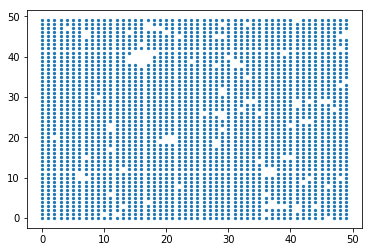

In [738]:
t=10000
plt.scatter([elm[0] for elm in np.loadtxt(flist[t], dtype=int)],[elm[1] for elm in np.loadtxt(flist[t], dtype=int)],s=5)

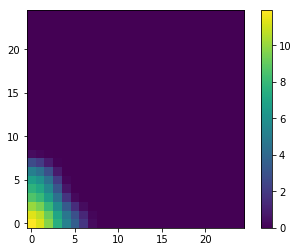

In [705]:
fig, ax = plt.subplots()
cs=ax.imshow(np.log(1+imgs[15500]),origin='lower')
#cs = ax.contourf(x, y, z,locator=ticker.LogLocator())
#locator=ticker.LogLocator()
cbar = fig.colorbar(cs)

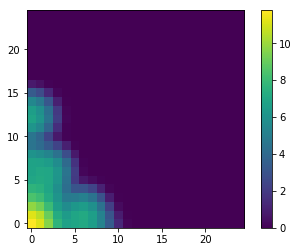

In [730]:
fig, ax = plt.subplots()
cs=ax.imshow(np.log(1+imgs[16000]),origin='lower')
#cs = ax.contourf(x, y, z,locator=ticker.LogLocator())
#locator=ticker.LogLocator()
cbar = fig.colorbar(cs)

In [556]:
np.shape(imgs)

(41726, 25, 25)

In [827]:
np.save("PIs_25",imgs)

In [4]:
imgs=np.load("PIs_25.npy")

In [5]:
np.shape(imgs)

(41726, 25, 25)

unwrap persistence images into vectors and feed into linear regression

In [9]:
imgs_array = np.array([img.flatten() for img in imgs])

In [975]:
imgs_scaled=preprocessing.scale(imgs_array)

In [10]:
labels=[int(elm<2.269) for elm in Tlist]

In [575]:
(np.shape(imgs_array),np.shape(Tlist),np.shape(labels))

((41726, 625), (41726,), (41726,))

In [1024]:
size=14000
imgs_alt=np.concatenate((imgs_array[:size],imgs_array[-size:]))
labels_alt=labels[:size]+labels[-size:]

In [602]:
np.shape(labels_alt)

(4000,)

In [1000]:
X_train, X_test, y_train, y_test = train_test_split(imgs_array, labels, test_size=0.40, random_state=42)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(preprocessing.scale(imgs_array), labels, test_size=0.40, random_state=42)

In [1025]:
X_train, X_test, y_train, y_test = train_test_split(preprocessing.scale(imgs_alt),labels_alt, test_size=0.40, random_state=42)

In [12]:
lr = LogisticRegression(solver='lbfgs',max_iter=5000)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [13]:
lr.score(X_test, y_test)

0.9838835300461326

In [15]:
#p=lr.predict(imgs_array)
p=lr.predict(preprocessing.scale(imgs_array))
diff=abs(p-labels)

In [16]:
TT=np.arange(1.5,3.01,0.01)
TT=np.round(TT,decimals=3)
len(TT)

151

In [17]:
avg=np.zeros(len(TT))
acc=np.zeros(len(TT))
for i in np.arange(len(TT)):
    avg[i]=np.mean(p[np.where(Tlist==TT[i])[0]])
    acc[i]=np.mean(1-diff[np.where(Tlist==TT[i])[0]])

In [24]:
(TT[75],acc[75])

(2.25, 0.765)

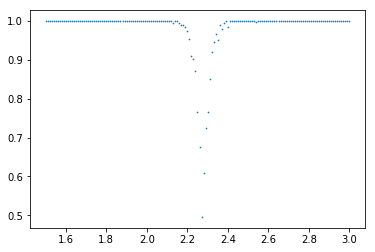

In [18]:
plt.scatter(TT,acc,s=0.5)

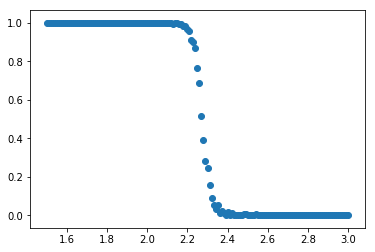

In [987]:
plt.scatter(TT,avg)

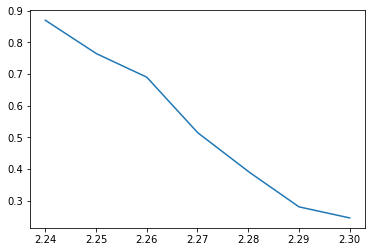

In [995]:
plt.plot(np.linspace(2.24,2.3,500),np.interp(np.linspace(2.24,2.3,500),TT,avg))

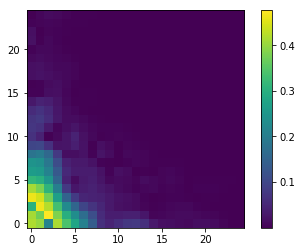

In [1028]:
inverse_image = np.copy(lr.coef_).reshape((25,25))
fig, ax = plt.subplots()
#cs=ax.imshow(inverse_image,origin='lower')
#cs=ax.imshow(np.log(1+abs(inverse_image)),origin='lower')
cs=ax.imshow(abs(inverse_image),origin='lower')
#cs = ax.contourf(x, y, z,locator=ticker.LogLocator())
#locator=ticker.LogLocator()
cbar = fig.colorbar(cs)

Now try k-means clustering with 2 clusters for "unsupervised" classification

In [582]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train)

In [583]:
kmeans.score(X_test)

-4724165143231.026

In [584]:
kmeans.score(X_train)

-7424164403768.941

# Some PCA

In [796]:
pca = PCA(n_components=2)

In [797]:
X_r = pca.fit(imgs_array).transform(imgs_array)

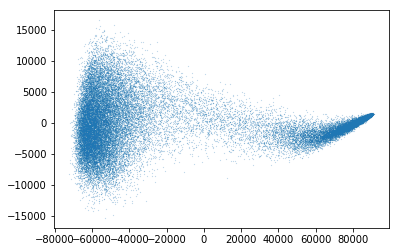

In [802]:
plt.scatter([elm[0] for elm in X_r],[elm[1] for elm in X_r],s=0.01)

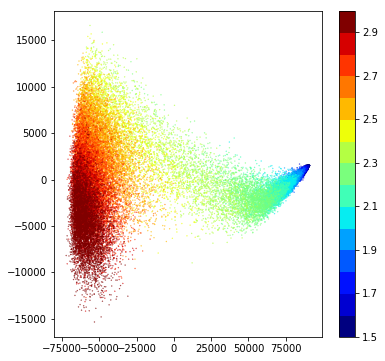

In [1031]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(1.5,3.0,16)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
scat = ax.scatter([elm[0] for elm in X_r],[elm[1] for elm in X_r],c=Tlist,s=0.1,cmap=cmap, norm=norm)
cbar = fig.colorbar(scat)
plt.show()

# Check magnetizations of samples

In [814]:
datas = [np.loadtxt(f, dtype=int) for f in flist]
bounds=[[x for x,y in enumerate(f) if y == '/'] for f in flist]

IndexError: index 200 is out of bounds for axis 0 with size 200

In [817]:
Tlist=[float(flist[i][bounds[i][0]+1:bounds[i][1]]) for i in np.arange(len(flist))]

In [822]:
m=[len(data) for data in datas]

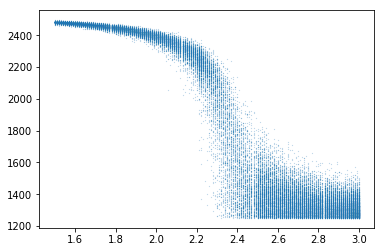

In [825]:
plt.scatter(Tlist,m,s=0.01)

# Dump status of kernel

In [1033]:
import dill
dill.dump_session('LR_env.db')

TypeError: can't pickle generator objects